I'm aiming to predict the number of social information in the ortho clinical notes dataset.

My first hunch is to use a zero-inflated Poission model even though I know it's imperfect. We'll start with this and iterate from there.

In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pymc3 as pm
import scipy.stats as stats
import seaborn as sns
from scipy.special import expit as logistic
import daft
from causalgraphicalmodels import CausalGraphicalModel

from scipy.optimize import curve_fit

In [4]:
%load_ext nb_black
%config InlineBackend.figure_format = 'retina'
%load_ext watermark
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89  # sets default credible interval used by arviz

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black
The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


<IPython.core.display.Javascript object>

In [5]:
sns.set_context("talk")

<IPython.core.display.Javascript object>

In [6]:
def standardize(x):
    x = (x - np.mean(x)) / np.std(x)
    return x

<IPython.core.display.Javascript object>

In [7]:
# UCSF primary
sf_navy = '#052049'
sf_teal = '#18A3AC'
sf_green = '#90BD31'
sf_blue = '#178CCB'
sf_orange = '#F48024'

# UCSF secondary
sf_purple = '#716FB2'
sf_red = '#EC1848'
sf_yellow = '#FFDD00'

# palette
sf_palette = [sf_navy, sf_teal, sf_green, sf_orange, sf_purple, sf_red, sf_yellow, sf_blue]


<IPython.core.display.Javascript object>

**McElreath's general structure**

Taken from [this YouTube video](https://youtu.be/zwRdO9_GGhY?t=2999).
- Express theory as probabilistic program
- Prove planned anlaysis could work (conditionally)
- Test pipeline on synthetic data
- Run pipeline on empirical data


# Import data (attempt 11/10/21)

In [10]:
interim_dir = "/Users/blacar/Documents/ds_projects/sdoh_text/cocoa/edemarchis_GRP/skippy-2020-02-12-per-type_output/211108_kfold/interim/"

#df_kw_vs_annotations4bayes.to_pickle(Path(interim_dir, "02_df_kw_vs_annotations4bayes.pkl"))

df_srfs_counts = pd.read_pickle(
    interim_dir + "02_df_kw_vs_annotations4bayes.pkl"
)
df_srfs_counts['note_type_code'] = pd.Categorical(df_srfs_counts['note_type']).codes
df_srfs_counts.head()

keywords  annotations                file          note_type  \
59        10.0          1.0  553297543_Matt.xml  ED_Provider_Notes   
544       19.0          7.0  557484673_Matt.xml  ED_Provider_Notes   
153       15.0          1.0  566328592_Matt.xml  ED_Provider_Notes   
263       12.0          1.0  573568852_Matt.xml  ED_Provider_Notes   
2688       8.0          2.0  581355631_Sara.xml                H&P   

      n_char_note  note_type_code  
59           5756               0  
544          6256               0  
153          5648               0  
263          7712               0  
2688         6834               1

<IPython.core.display.Javascript object>

## Exploration

Minimum number of tags, ED_Provider_Notes:  1.0
Minimum number of tags, H&P:  0.0
Minimum number of tags, Patient_Instructions:  0.0
Minimum number of tags, Progress_Notes:  0.0
Minimum number of tags, Telephone_Encounter:  0.0


<ipython-input-12-8e5abdd2b36b>:31: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  f.tight_layout()


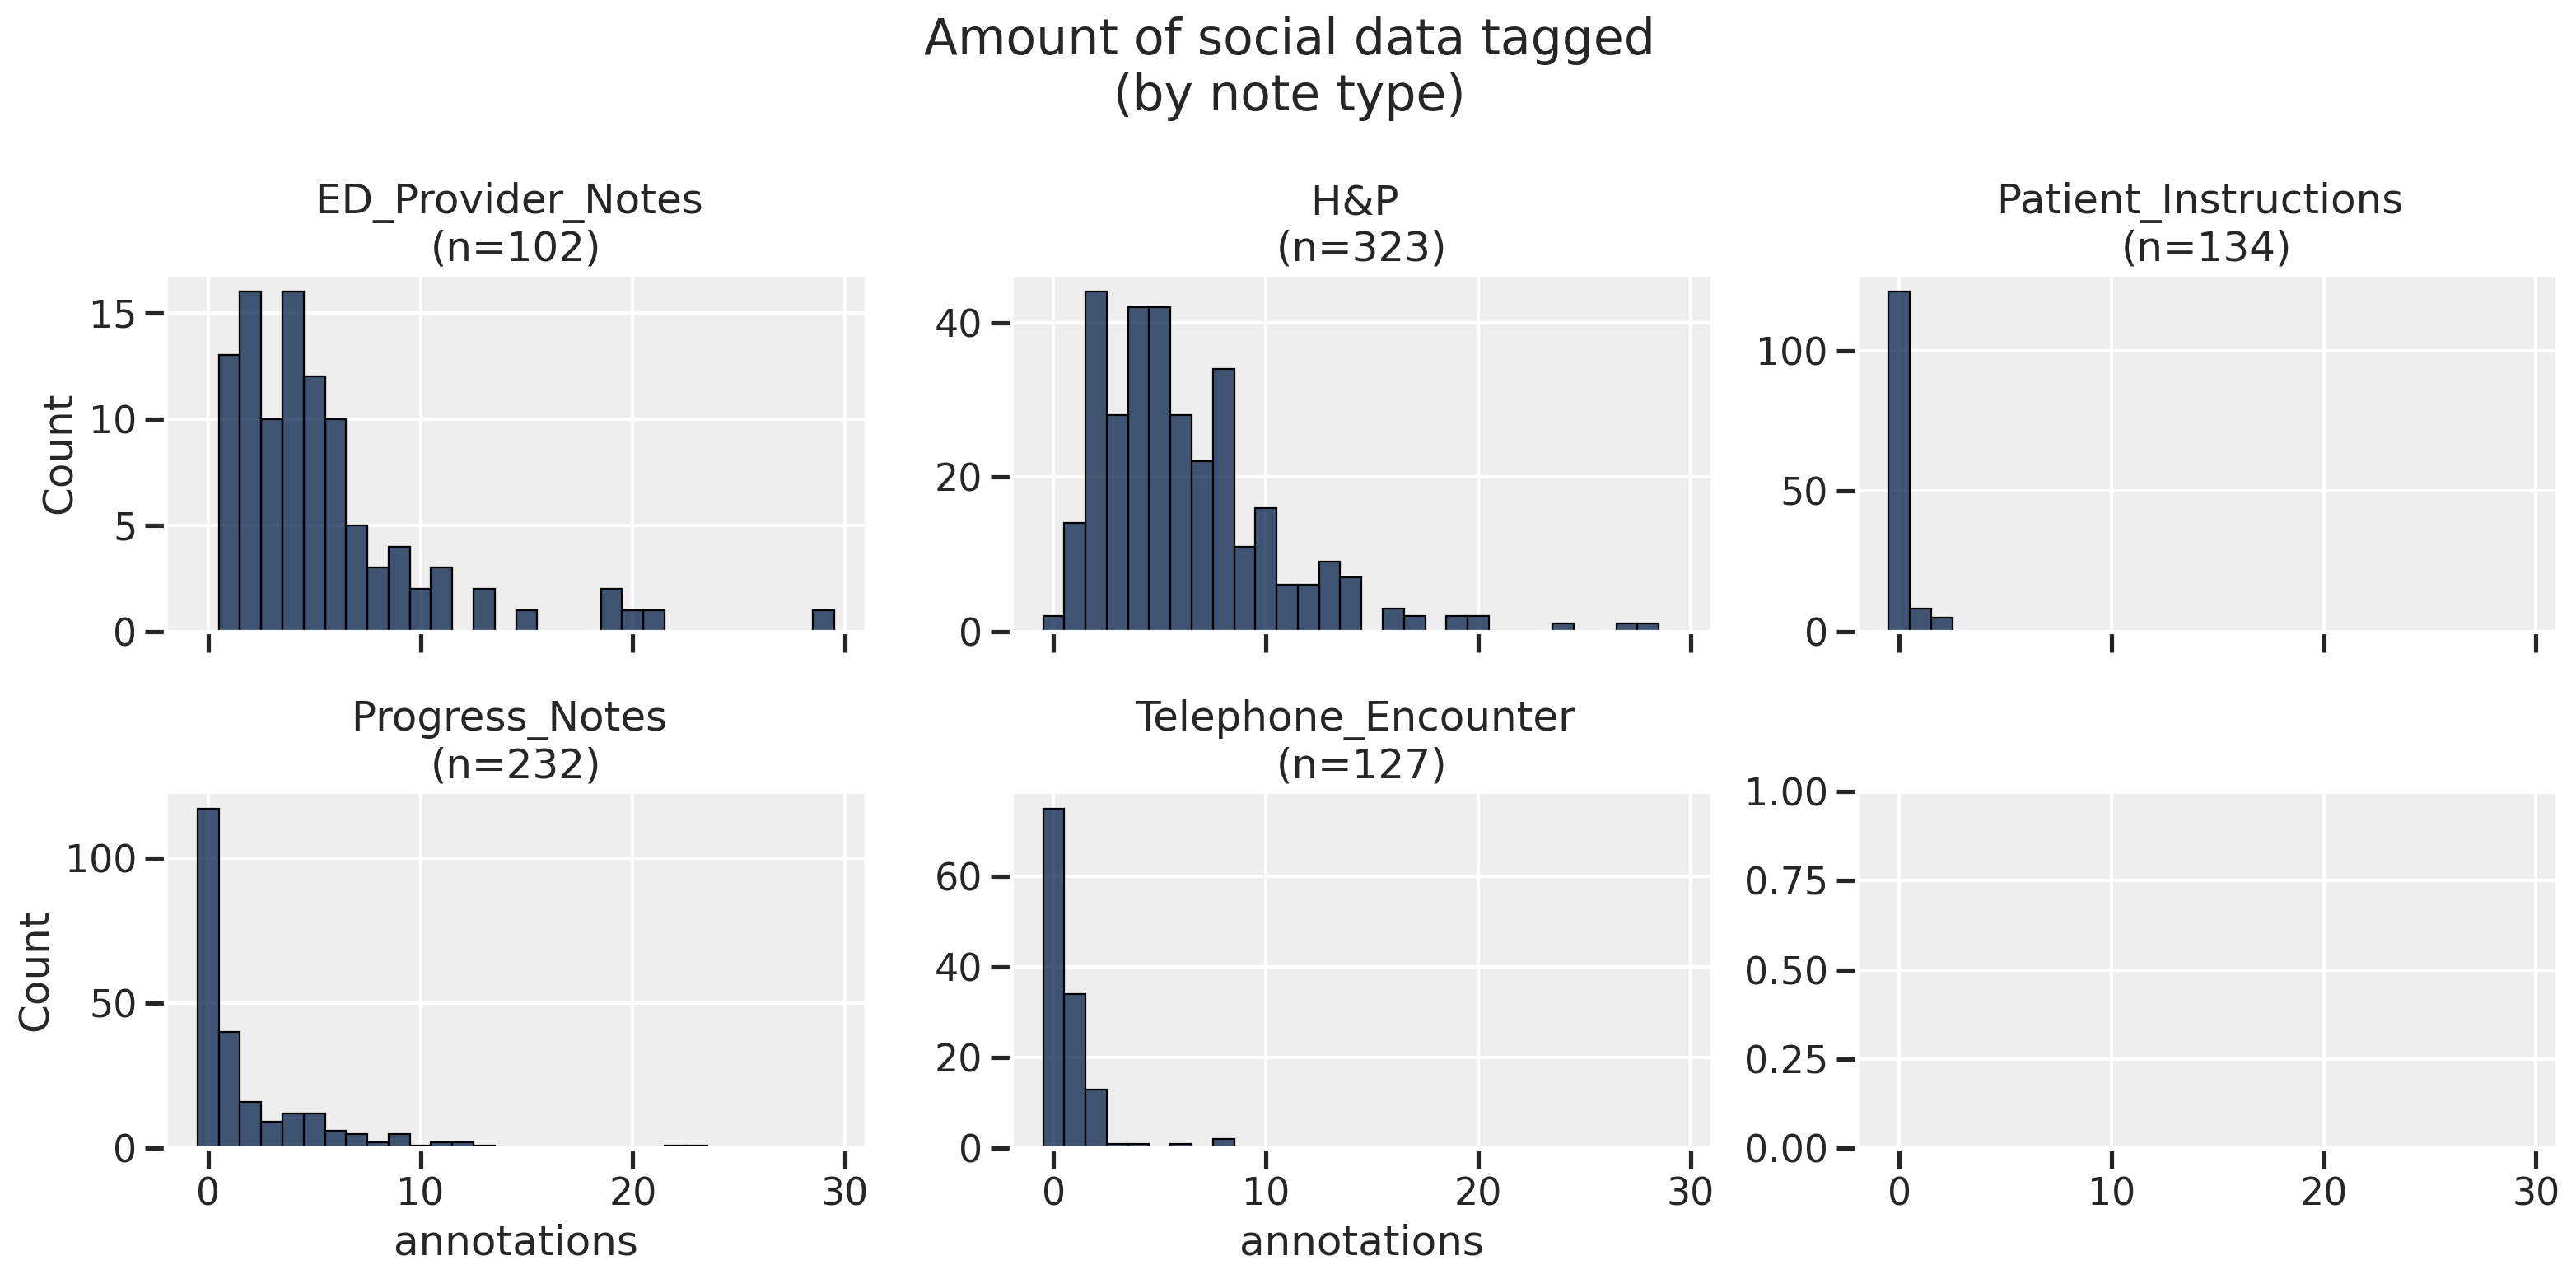

<IPython.core.display.Javascript object>

In [12]:
# Number of notes for each type

note_subfolders = [
    "ED_Provider_Notes",
    "H&P",
    "Patient_Instructions",
    "Progress_Notes",
    "Telephone_Encounter",
]

f, axs = plt.subplots(2, 3, figsize=[16, 8], sharex=True)

for note_type, ax in zip(note_subfolders, axs.flat):
    # Limit df to the note type
    df_temp = df_srfs_counts[df_srfs_counts["note_type"] == note_type].copy()
    annotations = len(df_temp)

    print("Minimum number of tags, " + note_type + ": ", df_temp["annotations"].min())

    # Plot histogram for that noteetype
    sns.histplot(df_temp["annotations"], discrete=True, ax=ax, color=sf_navy)

    # Formatting
    ax.set_title(f"{note_type} \n(n={annotations})")
    ax.set_ylabel("")

    if ax.is_first_col():
        ax.set_ylabel("Count")

f.suptitle("Amount of social data tagged\n(by note type)")
f.tight_layout()

[Text(0.5, 0, 'no. of social and behavioral risk-related keywords'),
 Text(0, 0.5, 'no. of manual annotations per note')]

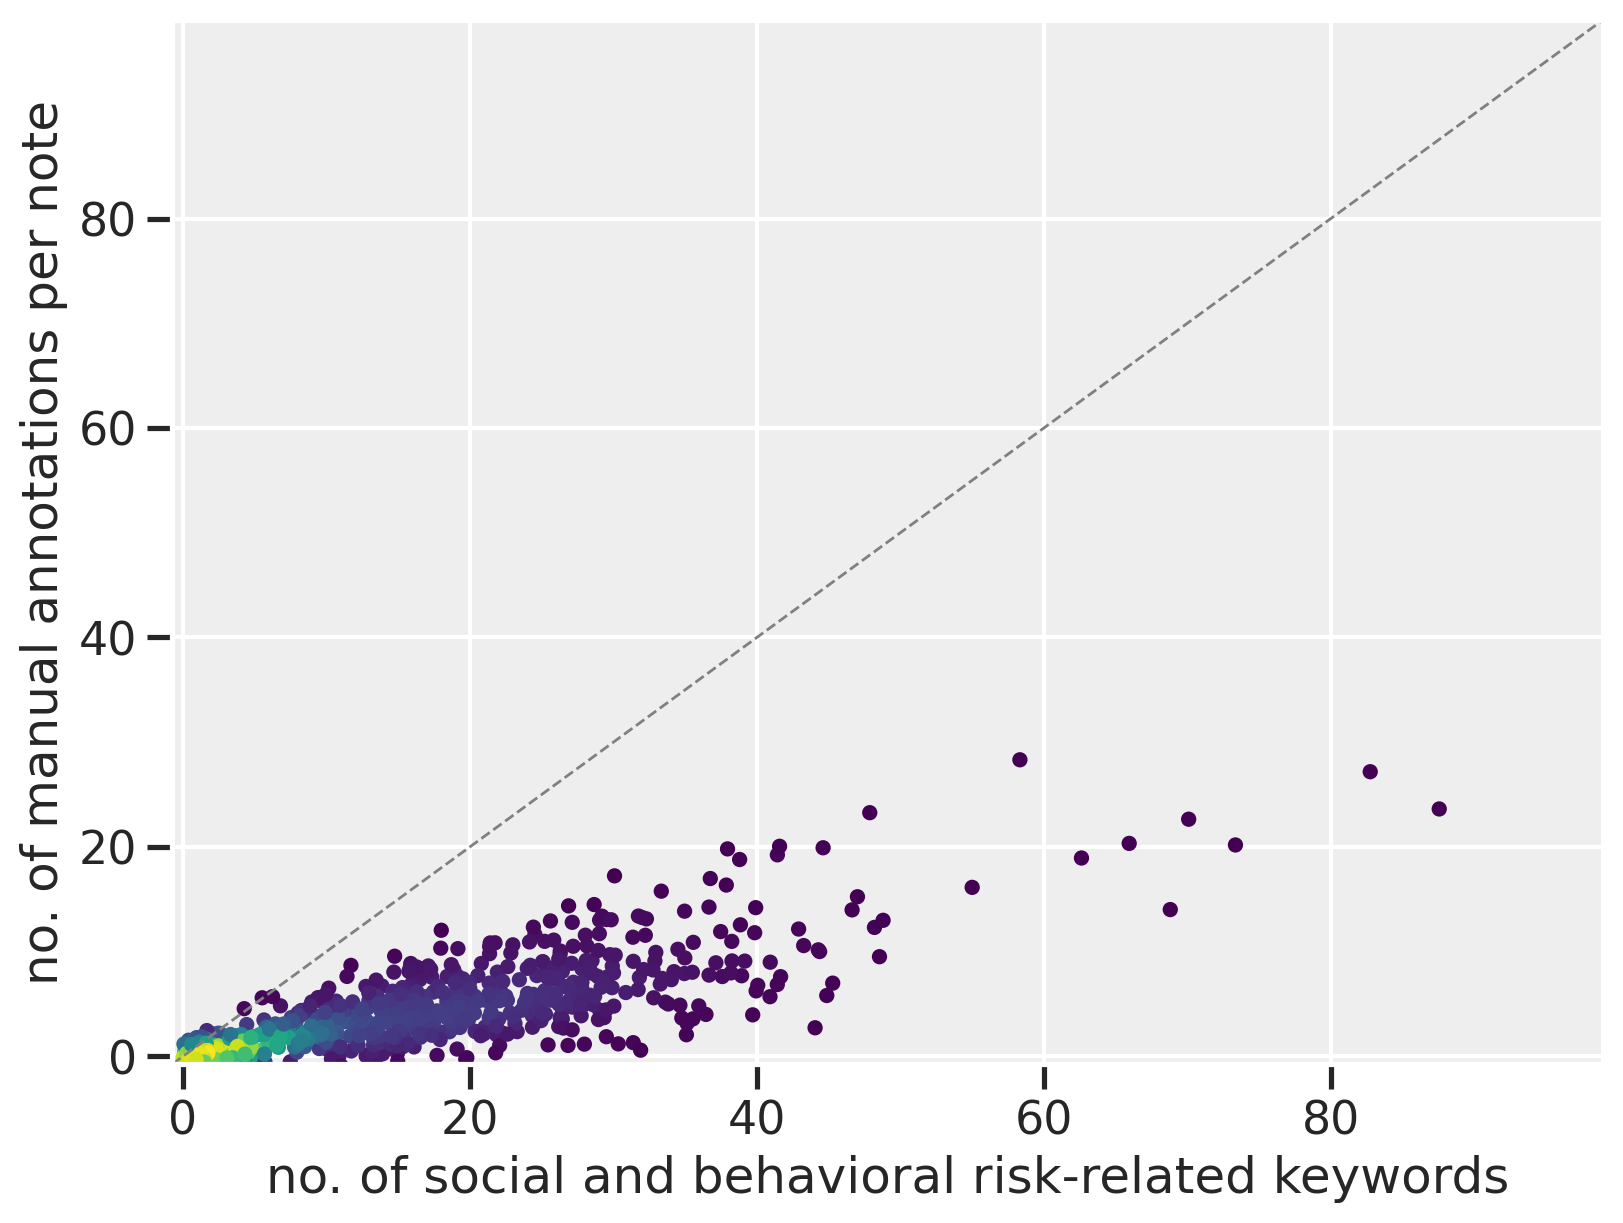

<IPython.core.display.Javascript object>

In [35]:
from scipy.stats import gaussian_kde

x_noise = np.random.normal(loc=0, scale=0.4, size=len(df_srfs_counts))
y_noise = np.random.normal(loc=0, scale=0.4, size=len(df_srfs_counts))

x_vals = df_srfs_counts["keywords"] + x_noise
y_vals = df_srfs_counts["annotations"] + y_noise
# Calculate the point density
xy_vals = np.vstack([x_vals, y_vals])
z_vals = gaussian_kde(xy_vals)(xy_vals)


f, ax1 = plt.subplots(1, 1, figsize=(8, 6))

# Whole plot
ax1.scatter(
    x=x_vals,
    y=y_vals,
    s=2 ** 4,
    c=z_vals
)

ax1.set_xlim([-0.75, df_srfs_counts[['keywords', 'annotations']].max().max()])
ax1.set_ylim([-0.75, df_srfs_counts[['keywords', 'annotations']].max().max()])
ax1.axline((-1, -1), (1, 1), linewidth=1, linestyle="dashed", color="gray")
ax1.set(
    xlabel="no. of social and behavioral risk-related keywords",
    ylabel="no. of manual annotations per note",
)


# Poission model

Zero-inflated makes more sense, but let's start with this to understand the mechanics of the model.

## Note type (intercept) only

Let's just start with the different note types as the only variable on the right side of the equation (intercept only).

$$y_i \sim \text{Poisson}(\lambda_i) $$ 

$$\text{log}(\lambda_i) = \alpha_{\text{type}[i]} \tag{log link}$$ 

$$\alpha_{j} \sim \text{Normal}(2, 0.5) $$

In [23]:
# Intercept only model
with pm.Model() as m_notes1:
    # Prior chosen based on above
    a = pm.Normal("a", 2, 0.5, shape=5)

    # The link function, use `pm.math.exp` to get lambda
    lam = pm.math.exp(a[df_srfs_counts["note_type_code"]])

    # Likelihood,
    t = pm.Poisson("t", mu=lam, observed=df_srfs_counts["annotations"])

    trace_m_notes1 = pm.sample(1000, tune=1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


<IPython.core.display.Javascript object>

In [39]:
df_m1_summary = az.summary(trace_m_notes1).reset_index()
df_m1_summary

index   mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_mean  \
0  a[0]  1.698  0.042     1.632      1.765      0.001    0.000    6145.0   
1  a[1]  1.828  0.023     1.791      1.864      0.000    0.000    8031.0   
2  a[2] -1.453  0.165    -1.719     -1.204      0.002    0.002    5578.0   
3  a[3]  0.679  0.048     0.605      0.755      0.001    0.000    7620.0   
4  a[4] -0.264  0.098    -0.422     -0.108      0.001    0.001    6663.0   

   ess_sd  ess_bulk  ess_tail  r_hat  
0  6145.0    6167.0    2962.0    1.0  
1  8031.0    8027.0    3575.0    1.0  
2  5462.0    5601.0    3234.0    1.0  
3  7444.0    7609.0    3040.0    1.0  
4  5426.0    6698.0    3420.0    1.0

<IPython.core.display.Javascript object>

In [66]:
note_type_dict = (
    df_srfs_counts[['note_type', 'note_type_code']]
    .drop_duplicates()
    .sort_values(by='note_type_code')
    .set_index('note_type_code')
).to_dict(orient='dict')['note_type']
note_type_dict

{0: 'ED_Provider_Notes',
 1: 'H&P',
 2: 'Patient_Instructions',
 3: 'Progress_Notes',
 4: 'Telephone_Encounter'}

<IPython.core.display.Javascript object>

Text(0.5, 0.98, 'note type\n(intercept only)')

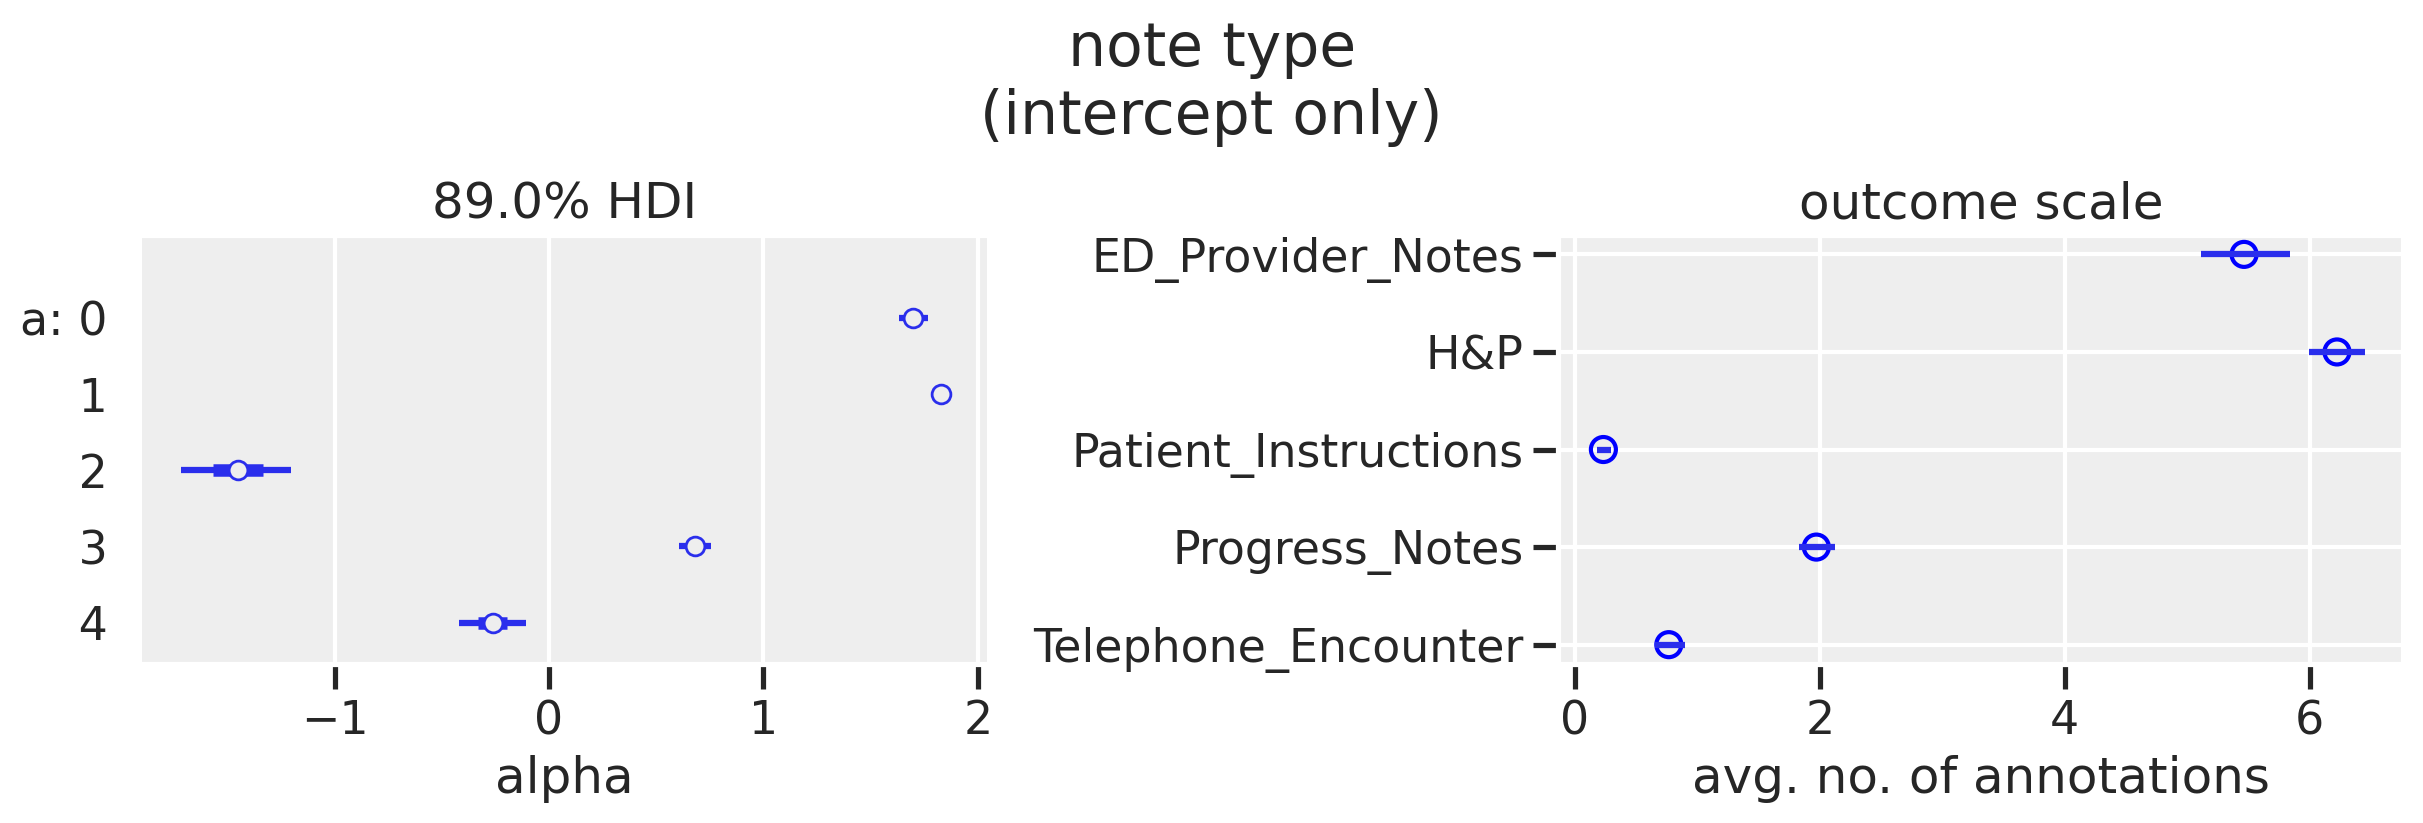

<IPython.core.display.Javascript object>

In [105]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
az.plot_forest(trace_m_notes1, var_names='a', combined=True, ax=ax1)
ax1.set_xlabel('alpha')

ax2.scatter(np.exp(df_m1_summary['mean']), df_m1_summary.index, facecolors='none', edgecolors='blue')
for i in df_m1_summary.index:
    ax2.hlines(y=i, xmin=np.exp(df_m1_summary.loc[i, 'hdi_5.5%']), xmax=np.exp(df_m1_summary.loc[i, 'hdi_94.5%']))
ax2.set_yticks(range(5))
ax2.set_yticklabels(list(note_type_dict.values()))
ax2.invert_yaxis()
ax2.set_xlabel('avg. no. of annotations')
ax2.set_title('outcome scale')

f.suptitle('note type\n(intercept only)')

In [29]:
df_srfs_counts.groupby('note_type').mean()['annotations']

note_type
ED_Provider_Notes       5.450980
H&P                     6.219814
Patient_Instructions    0.134328
Progress_Notes          1.952586
Telephone_Encounter     0.700787
Name: annotations, dtype: float64

<IPython.core.display.Javascript object>

## One predictor with interaction

In [96]:
df_srfs_counts.head()

keywords  annotations                file          note_type  \
59        10.0          1.0  553297543_Matt.xml  ED_Provider_Notes   
544       19.0          7.0  557484673_Matt.xml  ED_Provider_Notes   
153       15.0          1.0  566328592_Matt.xml  ED_Provider_Notes   
263       12.0          1.0  573568852_Matt.xml  ED_Provider_Notes   
2688       8.0          2.0  581355631_Sara.xml                H&P   

      n_char_note  note_type_code  
59           5756               0  
544          6256               0  
153          5648               0  
263          7712               0  
2688         6834               1

<IPython.core.display.Javascript object>

$$y_i \sim \text{Poisson}(\lambda_i) $$ 

$$\text{log}(\lambda_i) = \alpha_{\text{type}[i]} + \beta_{\text{type}}k \tag{log link}$$ 

$$\alpha_{j} \sim \text{Normal}(2, 0.5) $$

$$\beta_{k} \sim \text{Normal}(0, 1) $$

Where $k$ is the number of keywords. I'll standardize this variable.

In [98]:
df_srfs_counts['keywords_std'] = standardize(df_srfs_counts['keywords'])

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'no. of keywords')

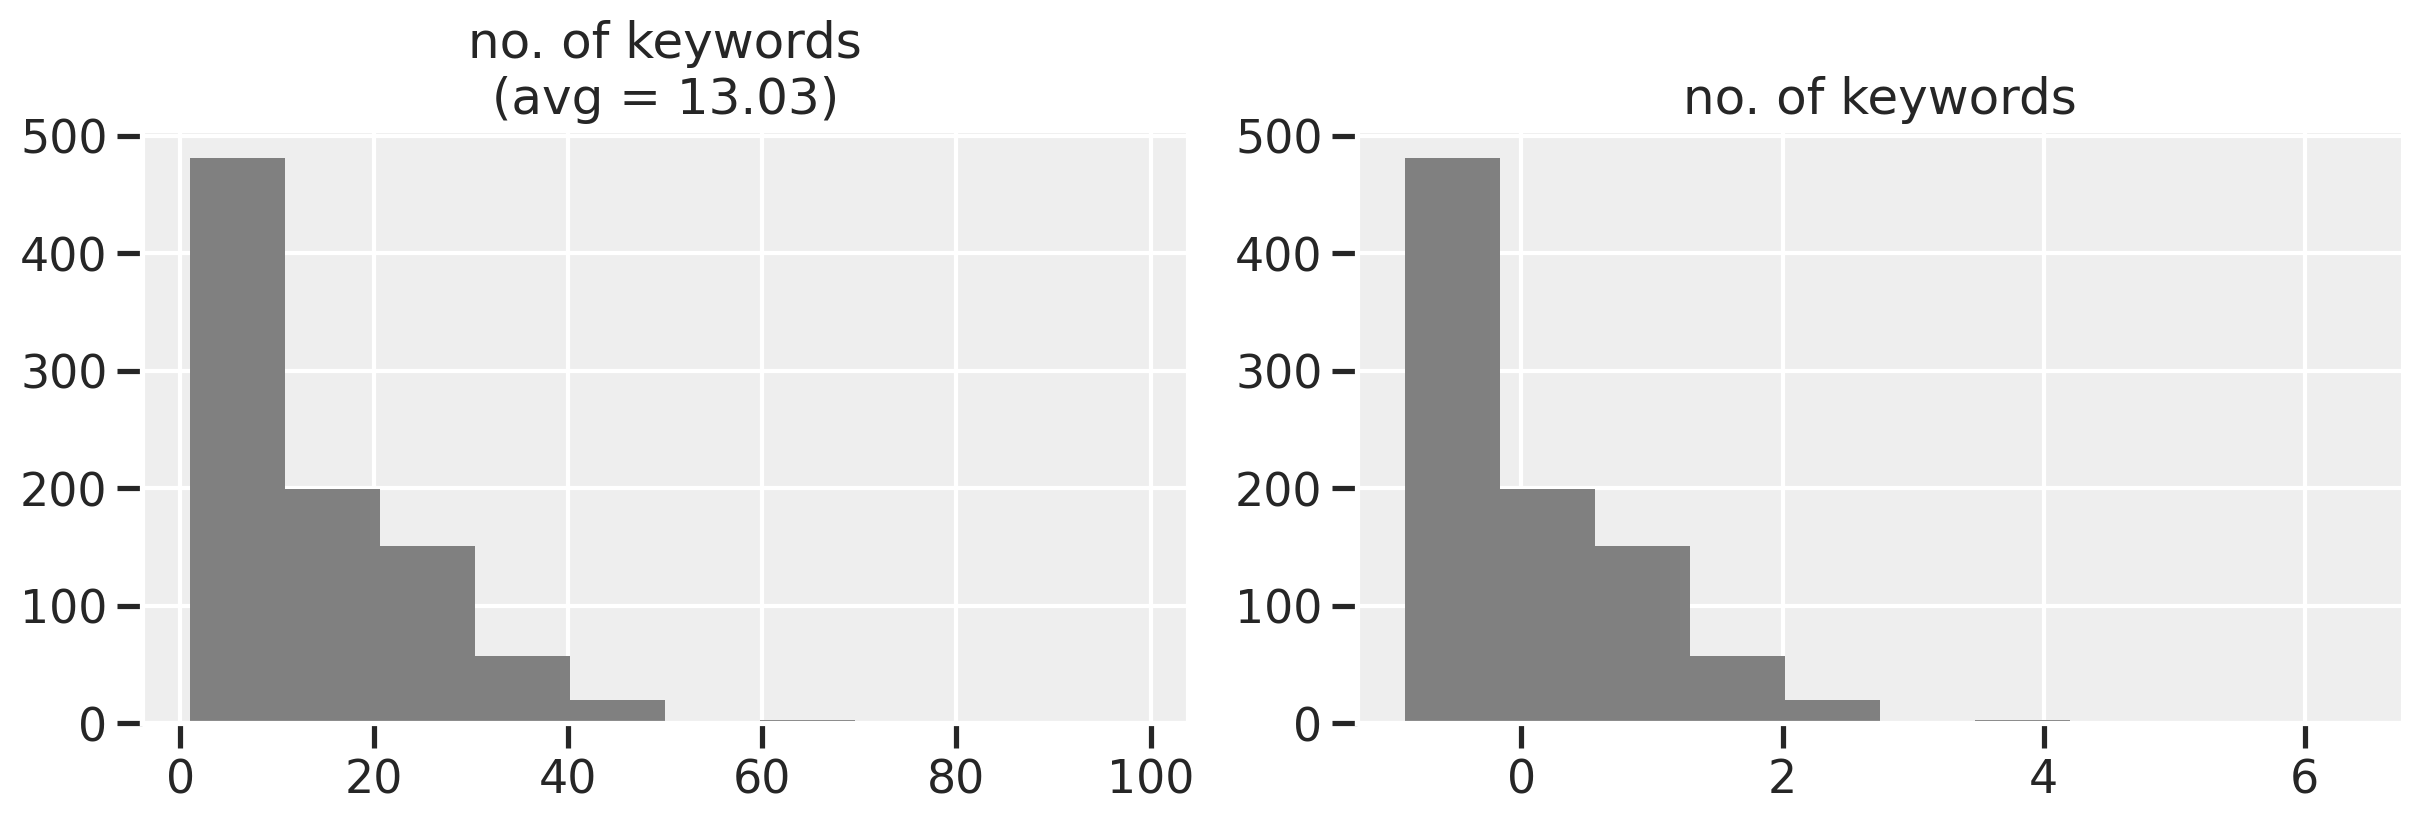

<IPython.core.display.Javascript object>

In [110]:
f, (ax1, ax2) = plt.subplots(1, 2,  figsize=(12, 4))
df_srfs_counts['keywords'].hist(ax=ax1, color='gray')
ax1.set_title(f"no. of keywords\n(avg = {df_srfs_counts['keywords'].mean():0.2f})")

df_srfs_counts['keywords_std'].hist(ax=ax2, color='gray')
ax2.set_title("no. of keywords")

In [111]:
df_srfs_counts['keywords'].mean() + df_srfs_counts['keywords'].std()

26.484793870407387

<IPython.core.display.Javascript object>

In [113]:
# Intercept and number of keywords
with pm.Model() as m_notes2:
    # Prior chosen based on above
    a = pm.Normal("a", 2, 0.5, shape=5)
    b = pm.Normal("b", 0, 1, shape=5)

    # The link function, use `pm.math.exp` to get lambda
    lam = pm.math.exp(a[df_srfs_counts["note_type_code"]] + b[df_srfs_counts["note_type_code"]] * df_srfs_counts['keywords_std'])

    # Likelihood,
    t = pm.Poisson("t", mu=lam, observed=df_srfs_counts["annotations"])

    trace_m_notes2 = pm.sample(1000, tune=1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a]
INFO:pymc3:NUTS: [b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


<IPython.core.display.Javascript object>

In [101]:
az.summary(trace_m_notes2)

mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
a[0]  1.344  0.053     1.257      1.427      0.001    0.001    4477.0  4477.0   
a[1]  1.470  0.031     1.420      1.518      0.000    0.000    4044.0  4030.0   
a[2] -0.643  0.244    -1.018     -0.258      0.004    0.003    4013.0  3610.0   
a[3]  0.624  0.051     0.545      0.708      0.001    0.001    4711.0  4711.0   
a[4]  0.856  0.127     0.640      1.038      0.002    0.001    4142.0  4142.0   
b[0]  0.375  0.022     0.339      0.410      0.000    0.000    4269.0  4269.0   
b[1]  0.404  0.019     0.376      0.435      0.000    0.000    4004.0  4004.0   
b[2]  1.422  0.352     0.867      1.971      0.006    0.004    3860.0  3860.0   
b[3]  0.796  0.027     0.748      0.837      0.000    0.000    4609.0  4589.0   
b[4]  1.707  0.163     1.439      1.956      0.003    0.002    4060.0  4060.0   

      ess_bulk  ess_tail  r_hat  
a[0]    4467.0    3102.0    1.0  
a[1]    4060.0    3016.0    1.0  
a[2]    4083.0    3021.0    1.0  
a[3]    4705.0    3187.0    1.0  
a[4]    4200.0    3020.0    1.0  
b[0]    4272.0    3035.0    1.0  
b[1]    4020.0    2965.0    1.0  
b[2]    3881.0    3108.0    1.0  
b[3]    4615.0    2999.0    1.0  
b[4]    4098.0    3483.0    1.0

<IPython.core.display.Javascript object>

Text(0.5, 0.98, 'note type and no. of keywords')

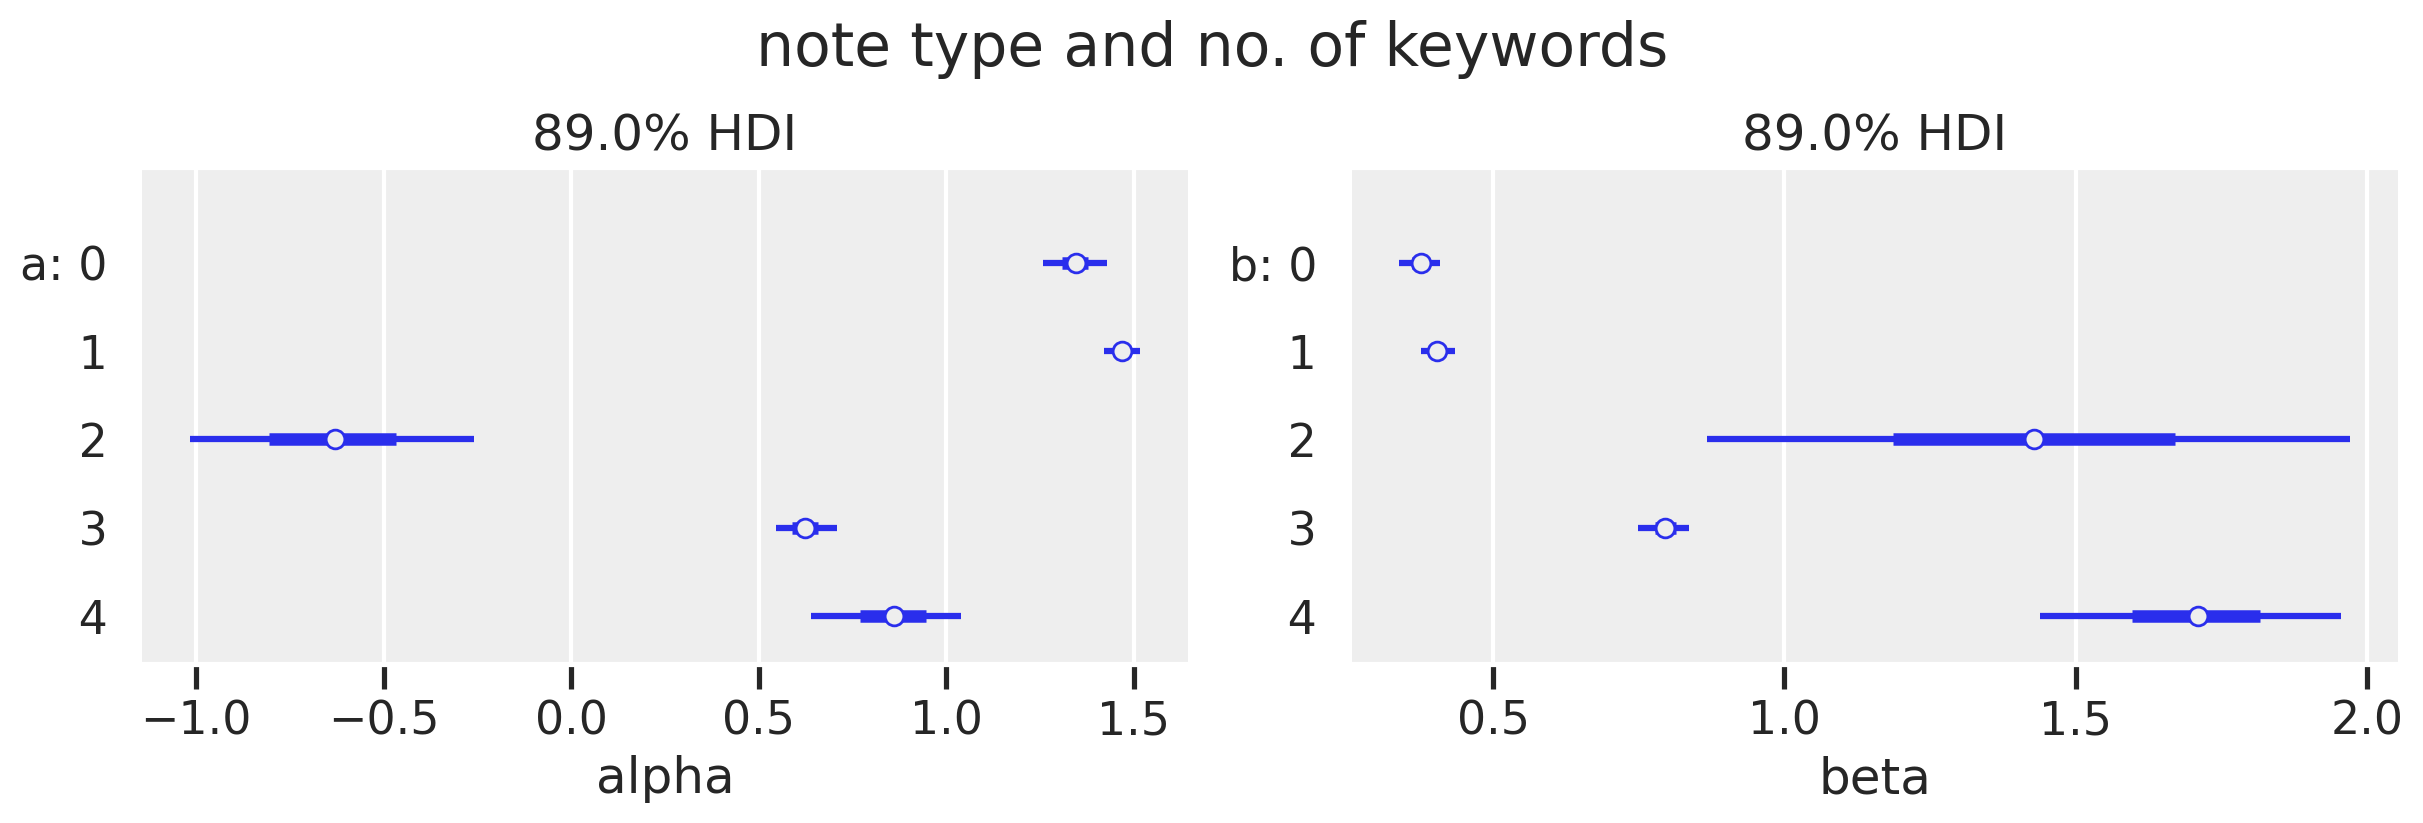

<IPython.core.display.Javascript object>

In [104]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
az.plot_forest(trace_m_notes2, var_names='a', combined=True, ax=ax1)
ax1.set_xlabel('alpha')

az.plot_forest(trace_m_notes2, var_names='b', combined=True, ax=ax2)
ax2.set_xlabel('beta')

f.suptitle('note type and no. of keywords')

## Two predictors with interaction

$$y_i \sim \text{Poisson}(\lambda_i) $$ 

$$\text{log}(\lambda_i) = \alpha_{\text{type}[i]} + \beta_{\text{type}}k + \gamma_{\text{type}}l \tag{log link}$$ 

$$\alpha_{j} \sim \text{Normal}(2, 0.5) $$

$$\beta_{k} \sim \text{Normal}(0, 1) $$

$$\gamma_{l} \sim \text{Normal}(0, 1) $$

Where $k$ is the number of keywords and $l$ is the note length. I'll also standardize this variable.

In [116]:
df_srfs_counts['n_char_note_std'] = standardize(df_srfs_counts['n_char_note'])
df_srfs_counts.head()

keywords  annotations                file          note_type  \
59        10.0          1.0  553297543_Matt.xml  ED_Provider_Notes   
544       19.0          7.0  557484673_Matt.xml  ED_Provider_Notes   
153       15.0          1.0  566328592_Matt.xml  ED_Provider_Notes   
263       12.0          1.0  573568852_Matt.xml  ED_Provider_Notes   
2688       8.0          2.0  581355631_Sara.xml                H&P   

      n_char_note  note_type_code  keywords_std  n_char_note_std  
59           5756               0     -0.225168         0.010877  
544          6256               0      0.444019         0.124750  
153          5648               0      0.146602        -0.013720  
263          7712               0     -0.076460         0.456351  
2688         6834               1     -0.373877         0.256388

<IPython.core.display.Javascript object>

In [117]:
# Intercept, number of keywords, note length
with pm.Model() as m_notes3:
    # Prior chosen based on above
    a = pm.Normal("a", 2, 0.5, shape=5)
    b = pm.Normal("b", 0, 1, shape=5)
    g = pm.Normal("g", 0, 1, shape=5)

    # The link function, use `pm.math.exp` to get lambda
    lam = pm.math.exp(a[df_srfs_counts["note_type_code"]] + b[df_srfs_counts["note_type_code"]] * df_srfs_counts['keywords_std'] + g[df_srfs_counts["note_type_code"]] * df_srfs_counts['n_char_note_std'])

    # Likelihood,
    t = pm.Poisson("t", mu=lam, observed=df_srfs_counts["annotations"])

    trace_m_notes3 = pm.sample(1000, tune=1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [g, b, a]
INFO:pymc3:NUTS: [g, b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.


<IPython.core.display.Javascript object>

In [118]:
az.summary(trace_m_notes3)

mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
a[0]  1.348  0.058     1.251      1.436      0.001    0.001    6698.0  6685.0   
a[1]  1.426  0.036     1.368      1.482      0.000    0.000    5536.0  5499.0   
a[2] -0.599  0.255    -1.001     -0.200      0.003    0.003    5785.0  4629.0   
a[3]  0.499  0.057     0.412      0.593      0.001    0.000    7012.0  6987.0   
a[4]  1.015  0.148     0.775      1.240      0.002    0.001    5441.0  5441.0   
b[0]  0.387  0.048     0.309      0.464      0.001    0.001    4180.0  4180.0   
b[1]  0.371  0.023     0.333      0.406      0.000    0.000    5767.0  5767.0   
b[2]  2.241  0.627     1.312      3.307      0.009    0.006    5105.0  4752.0   
b[3]  0.373  0.049     0.295      0.451      0.001    0.000    5165.0  5063.0   
b[4]  1.125  0.355     0.514      1.647      0.005    0.004    4308.0  3873.0   
g[0] -0.020  0.073    -0.141      0.089      0.001    0.001    3913.0  2003.0   
g[1]  0.088  0.037     0.034      0.152      0.001    0.000    4847.0  4567.0   
g[2] -0.670  0.433    -1.363      0.020      0.006    0.005    5524.0  3875.0   
g[3]  0.644  0.062     0.548      0.743      0.001    0.001    4817.0  4797.0   
g[4]  0.619  0.333     0.095      1.152      0.005    0.004    3989.0  3879.0   

      ess_bulk  ess_tail  r_hat  
a[0]    6720.0    3285.0    1.0  
a[1]    5523.0    2808.0    1.0  
a[2]    5879.0    3042.0    1.0  
a[3]    7013.0    3073.0    1.0  
a[4]    5644.0    3273.0    1.0  
b[0]    4217.0    2887.0    1.0  
b[1]    5776.0    2886.0    1.0  
b[2]    5111.0    2775.0    1.0  
b[3]    5170.0    3020.0    1.0  
b[4]    4341.0    2922.0    1.0  
g[0]    3935.0    2744.0    1.0  
g[1]    4858.0    3130.0    1.0  
g[2]    5561.0    2866.0    1.0  
g[3]    4819.0    2815.0    1.0  
g[4]    4022.0    2557.0    1.0

<IPython.core.display.Javascript object>

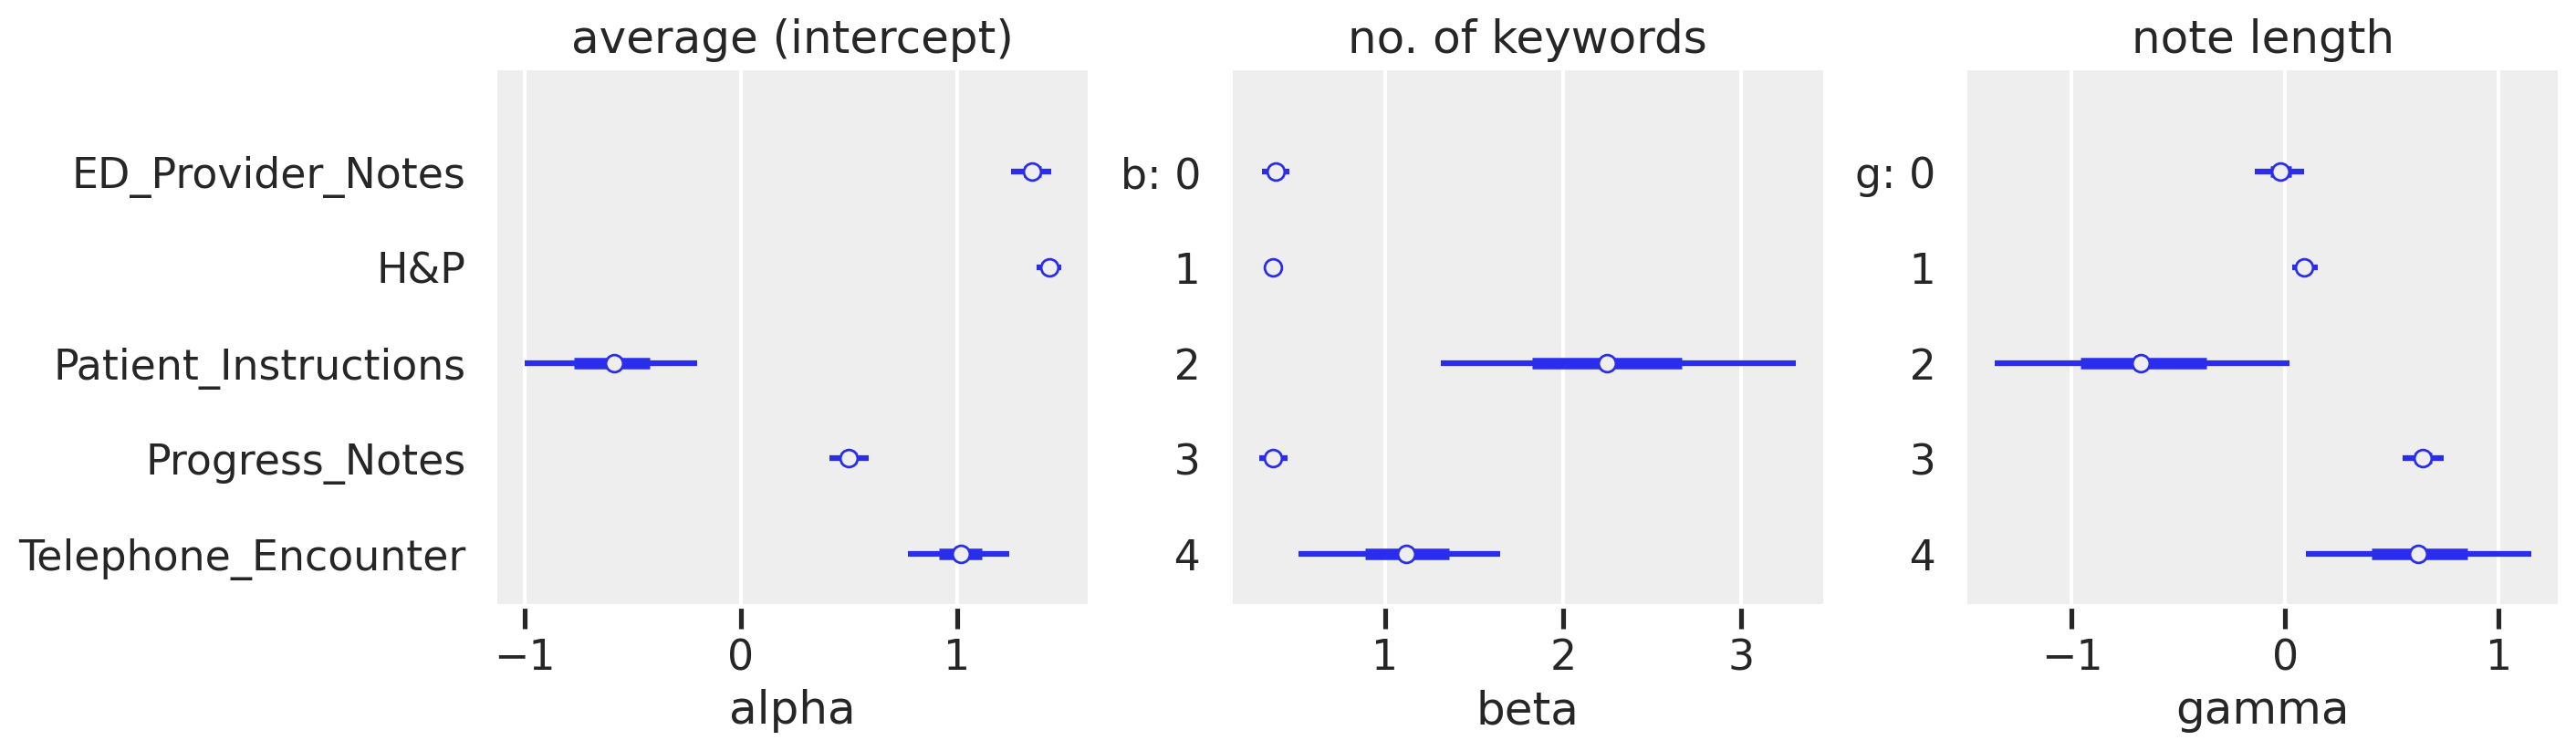

<IPython.core.display.Javascript object>

In [186]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))
az.plot_forest(trace_m_notes3, var_names='a', combined=True, ax=ax1)
ax1.set(xlabel = 'alpha', title='average (intercept)')
ax1.set_yticklabels(list(note_type_dict.values())[::-1])

az.plot_forest(trace_m_notes3, var_names='b', combined=True, ax=ax2)
ax2.set(xlabel='beta', title='no. of keywords')

az.plot_forest(trace_m_notes3, var_names='g', combined=True, ax=ax3)
ax3.set(xlabel='gamma', title='note length');

In [121]:
df_srfs_counts.head()

keywords  annotations                file          note_type  \
59        10.0          1.0  553297543_Matt.xml  ED_Provider_Notes   
544       19.0          7.0  557484673_Matt.xml  ED_Provider_Notes   
153       15.0          1.0  566328592_Matt.xml  ED_Provider_Notes   
263       12.0          1.0  573568852_Matt.xml  ED_Provider_Notes   
2688       8.0          2.0  581355631_Sara.xml                H&P   

      n_char_note  note_type_code  keywords_std  n_char_note_std  
59           5756               0     -0.225168         0.010877  
544          6256               0      0.444019         0.124750  
153          5648               0      0.146602        -0.013720  
263          7712               0     -0.076460         0.456351  
2688         6834               1     -0.373877         0.256388

<IPython.core.display.Javascript object>

In [136]:
df_srfs_counts_PI = df_srfs_counts[df_srfs_counts['note_type'] == 'Patient_Instructions']
df_srfs_counts_PI

keywords  annotations                file             note_type  \
2836       4.0          0.0  623347252_Sara.xml  Patient_Instructions   
2713       1.0          0.0  624297453_Sara.xml  Patient_Instructions   
2957      13.0          0.0  626132734_Sara.xml  Patient_Instructions   
2810       1.0          0.0  628374661_Sara.xml  Patient_Instructions   
3028       1.0          0.0  628859625_Sara.xml  Patient_Instructions   
...        ...          ...                 ...                   ...   
2858       3.0          0.0  913156597_Sara.xml  Patient_Instructions   
3019       1.0          0.0  913406052_Sara.xml  Patient_Instructions   
3030       1.0          0.0  913453435_Sara.xml  Patient_Instructions   
2814       1.0          0.0  920960318_Sara.xml  Patient_Instructions   
2950       2.0          0.0  921259086_Sara.xml  Patient_Instructions   

      n_char_note  note_type_code  keywords_std  n_char_note_std  
2836         3652               2     -0.671294        -0.468304  
2713          836               2     -0.894356        -1.109641  
2957         4545               2     -0.002106        -0.264926  
2810          498               2     -0.894356        -1.186620  
3028          989               2     -0.894356        -1.074796  
...           ...             ...           ...              ...  
2858          563               2     -0.745648        -1.171816  
3019         1048               2     -0.894356        -1.061358  
3030          485               2     -0.894356        -1.189580  
2814         1224               2     -0.894356        -1.021275  
2950          937               2     -0.820002        -1.086638  

[134 rows x 8 columns]

<IPython.core.display.Javascript object>

In [148]:
len(y_noise)

918

<IPython.core.display.Javascript object>

[Text(0.5, 0, 'keywords'), Text(0, 0.5, 'no. of annotations')]

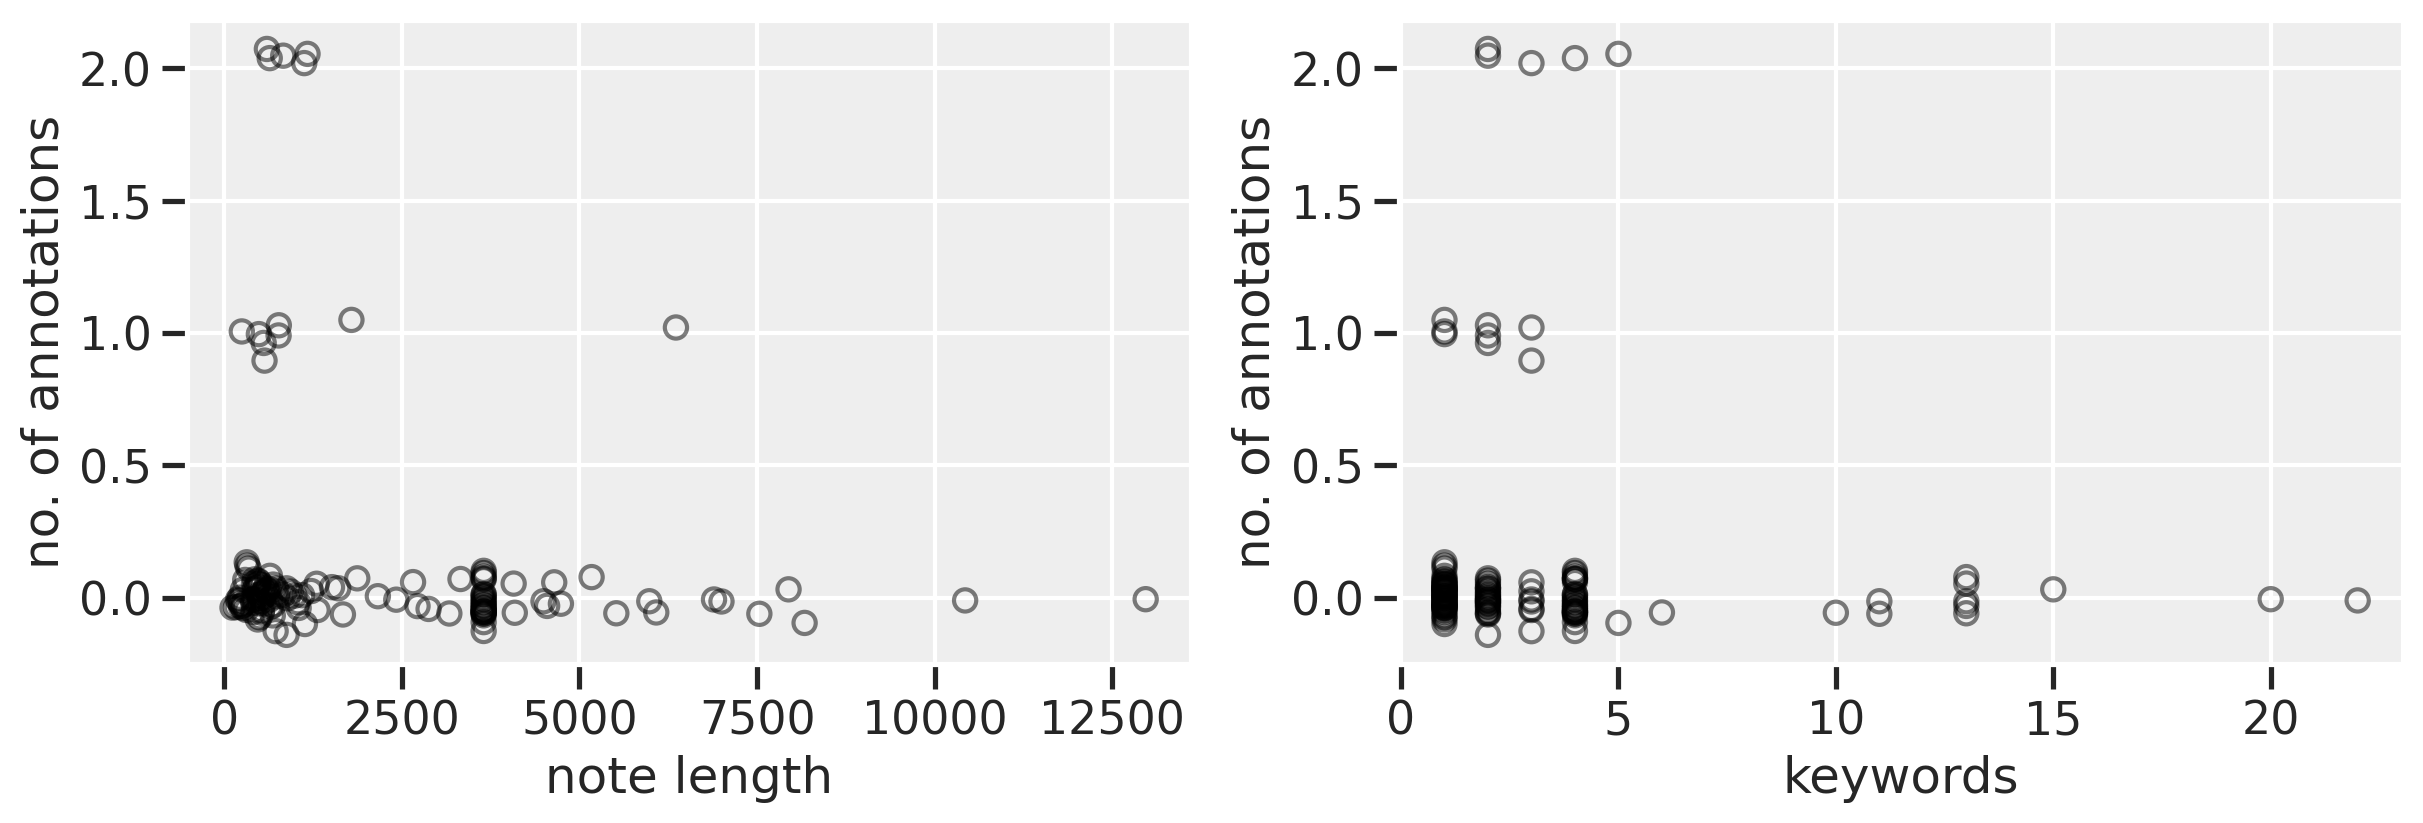

<IPython.core.display.Javascript object>

In [188]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

x_noise = np.random.normal(0, 0.04, size=len(df_srfs_counts_PI))
y_noise = np.random.normal(0, 0.05, size=len(df_srfs_counts_PI))
ax1.scatter(
    df_srfs_counts_PI['n_char_note'],
    df_srfs_counts_PI['annotations'] + y_noise,
    s=2**6,
    facecolors='none',
    edgecolors='k',
    #color='gray',
    alpha=0.5)
ax1.set(xlabel='note length', ylabel='no. of annotations')

ax2.scatter(
    df_srfs_counts_PI['keywords'],
    df_srfs_counts_PI['annotations'] + y_noise,
    s=2**6,
    facecolors='none',
    edgecolors='k',
    #color='gray',
    alpha=0.5)
ax2.set(xlabel='keywords', ylabel='no. of annotations')

In [170]:
az.compare(
    {"intercept" : trace_m_notes1,
    "one predictor" : trace_m_notes2,
    "two predictors" : trace_m_notes3}, ic='loo')

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/stats/stats.py:146: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/stats/stats.py:692: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/stats/stats.py:692: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is 

rank          loo      p_loo       d_loo        weight  \
two predictors     0 -1576.746715  32.494684    0.000000  9.594334e-01   
one predictor      1 -1625.023459  31.805552   48.276744  4.056656e-02   
intercept          2 -2203.175120  15.915958  626.428405  3.818668e-11   

                       se        dse  warning loo_scale  
two predictors  41.809298   0.000000     True       log  
one predictor   45.654479  12.289290     True       log  
intercept       88.511366  65.651873    False       log

<IPython.core.display.Javascript object>

We use the log link because the Poisson parameter lambda requires a positive value. This ensures that the result  of the intercept (and after we include the beta coefficient) will still work. Let's plot different lambda values to see what the Poisson distribution looks like.

In [23]:
from scipy.stats import poisson

<IPython.core.display.Javascript object>

In [111]:
# taken from documentation
mu = 0.6
mean, var, skew, kurt = poisson.stats(mu, moments="mvsk")

x = np.arange(poisson.ppf(0.01, mu), poisson.ppf(0.99, mu))

<IPython.core.display.Javascript object>

In [112]:
x

array([0., 1., 2.])

<IPython.core.display.Javascript object>

[0. 1. 2.] [0.54881164 0.32928698 0.09878609]


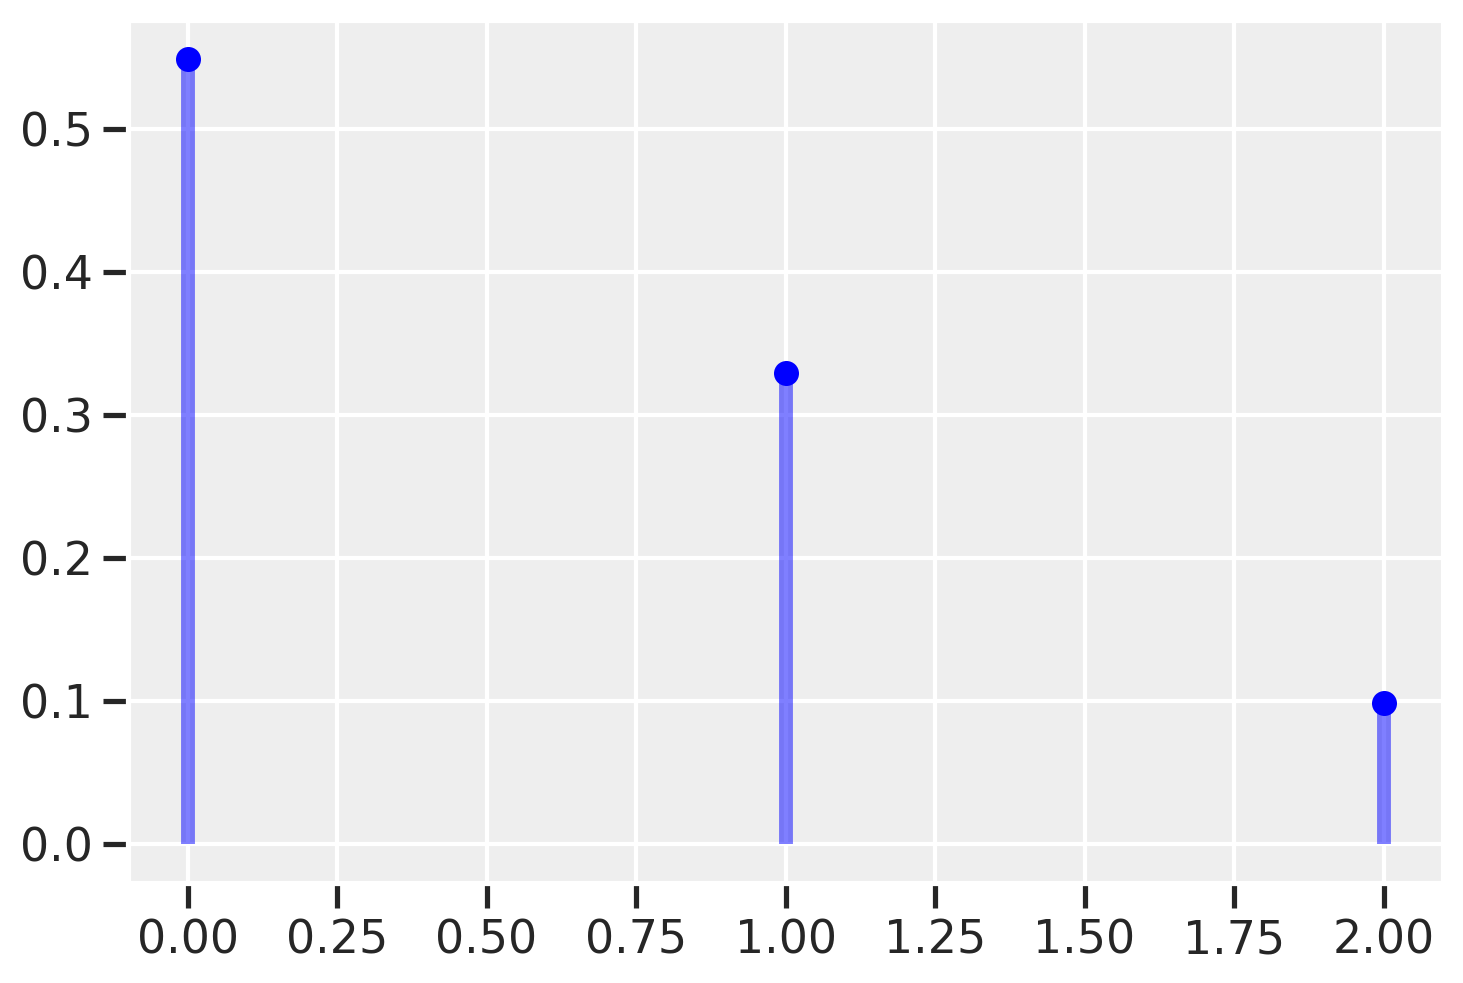

<IPython.core.display.Javascript object>

In [29]:
f, ax1 = plt.subplots()
ax1.plot(x, poisson.pmf(x, mu), "bo", ms=8, label="poisson pmf")
print(x, poisson.pmf(x, mu))
ax1.vlines(x, 0, poisson.pmf(x, mu), colors="b", lw=5, alpha=0.5)

In [31]:
np.sum([0.54881164, 0.32928698, 0.09878609])

0.97688471

<IPython.core.display.Javascript object>

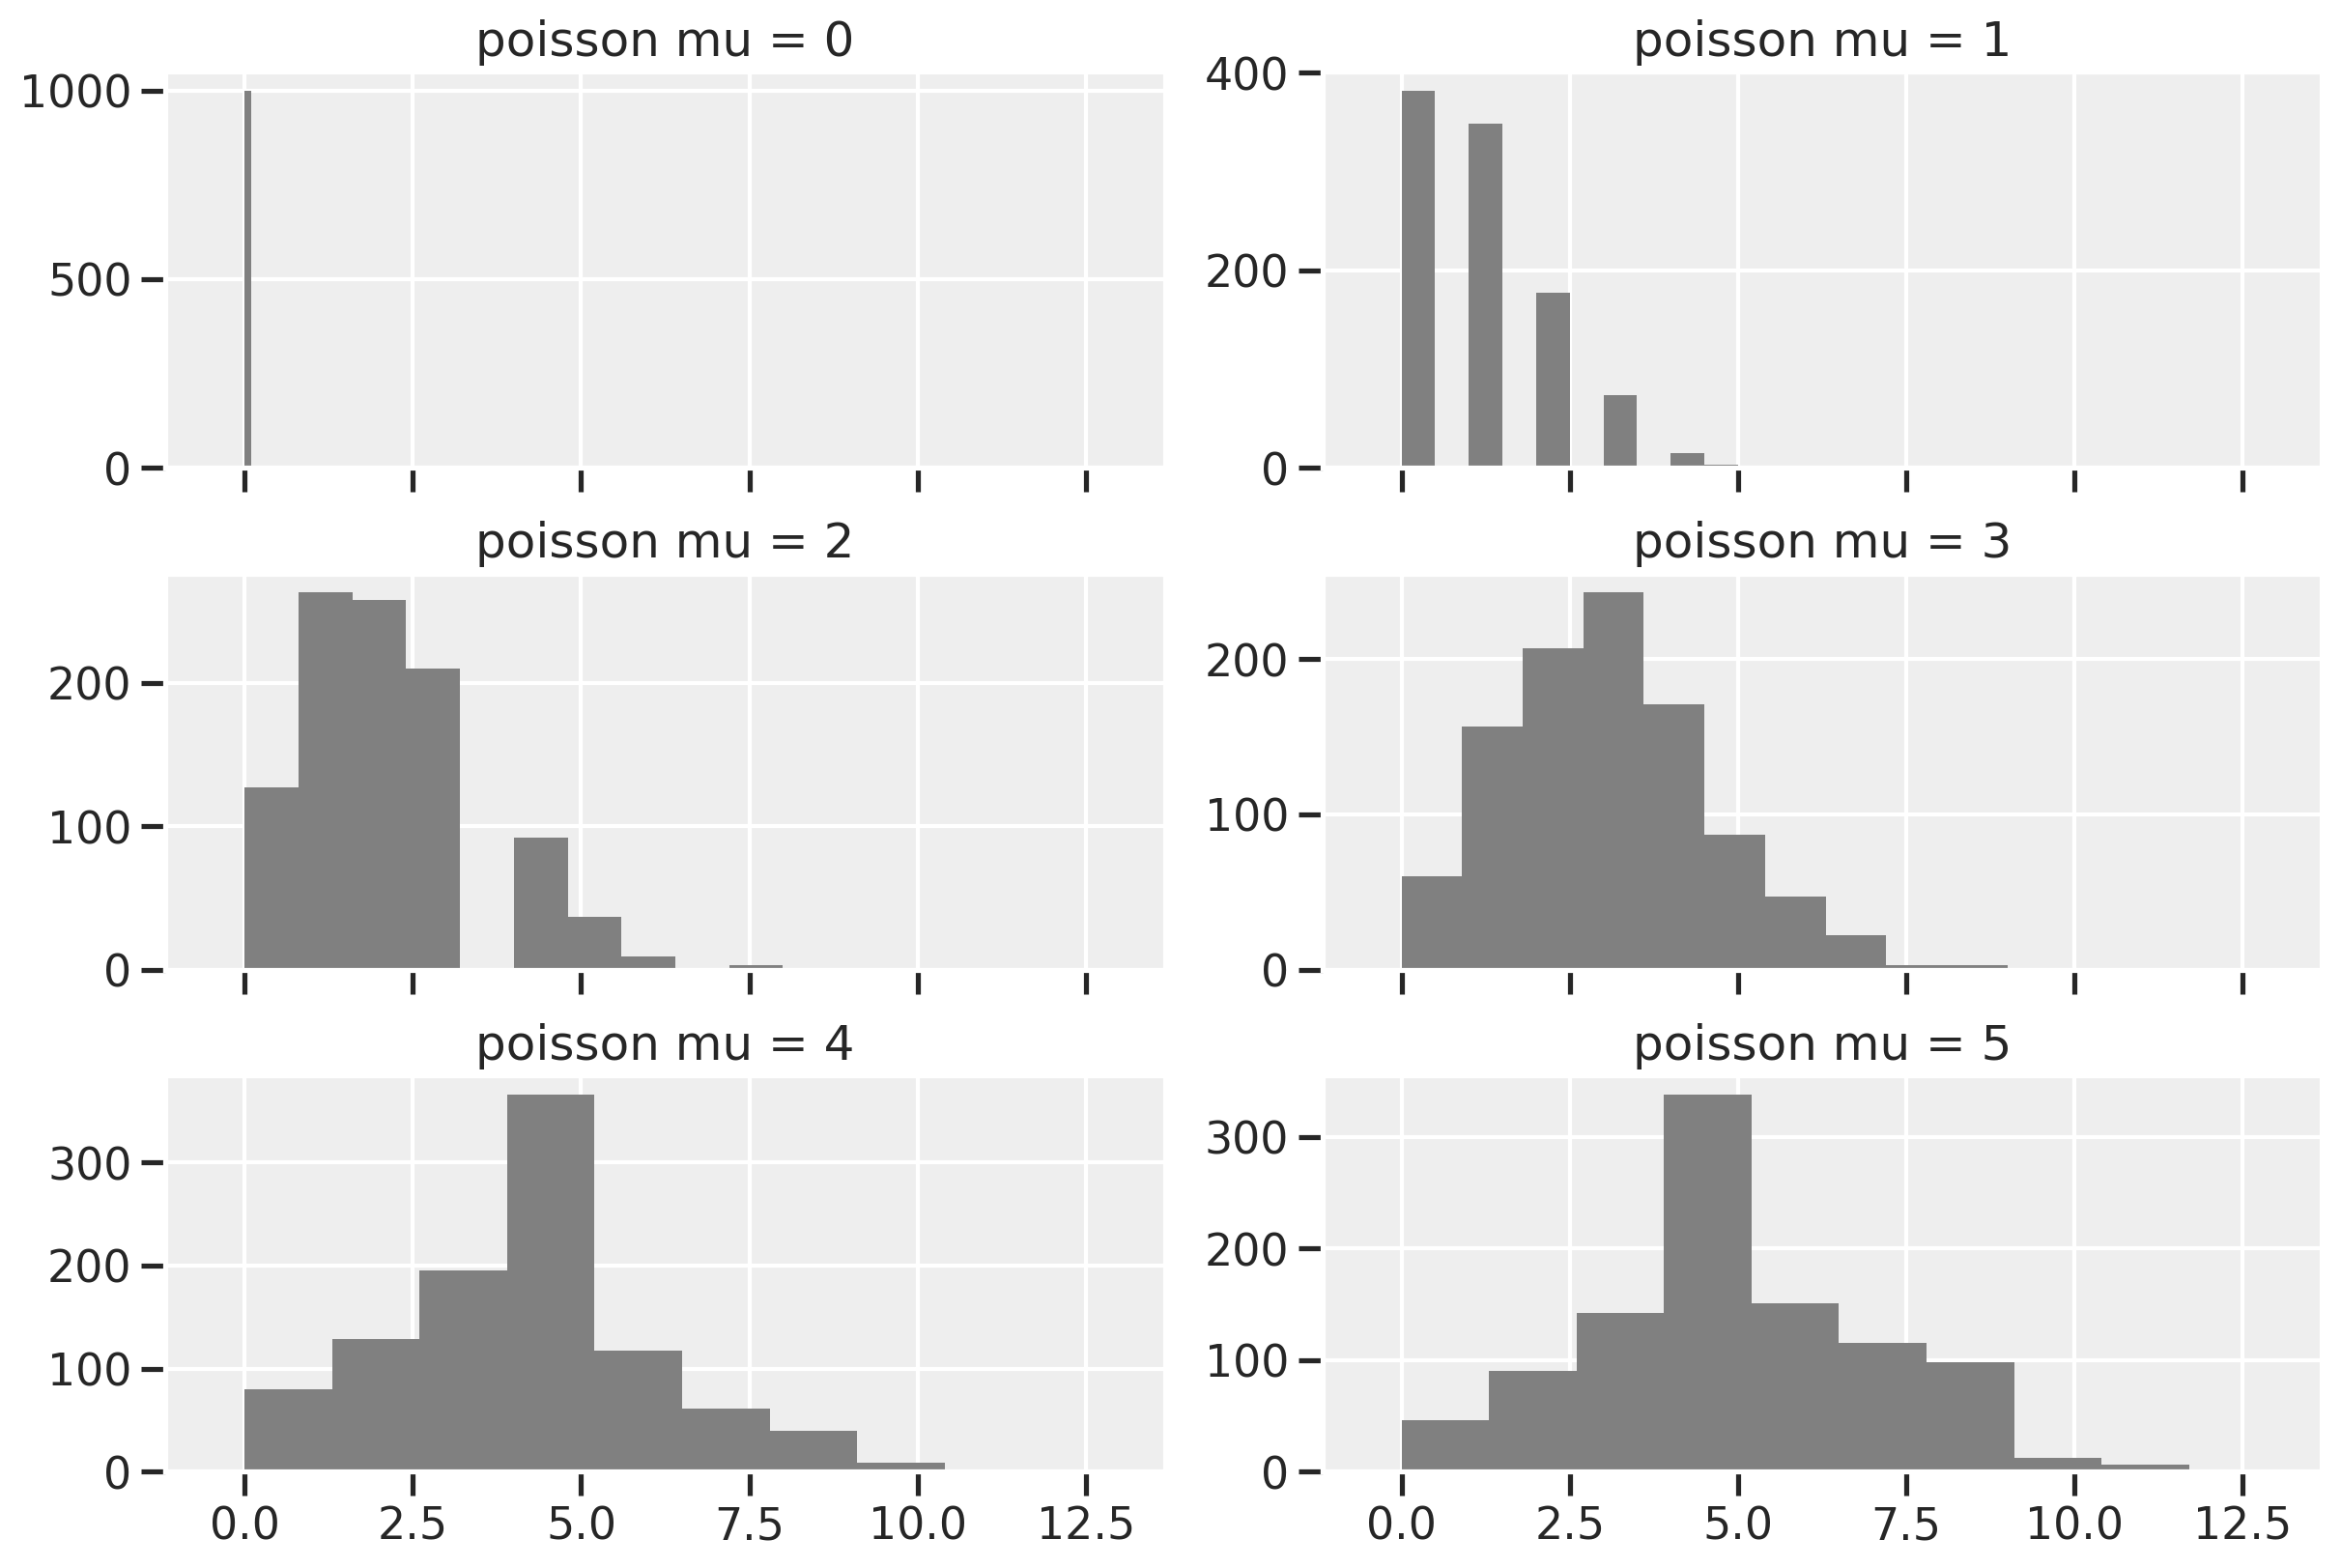

<IPython.core.display.Javascript object>

In [48]:
f, axes = plt.subplots(3, 2, figsize=(12, 8), sharex=True)
for i, ax in zip(range(6), axes.flat):
    r = poisson.rvs(i, size=1000)
    ax.hist(r, color="gray")
    ax.set_title(f"poisson mu = {i}")

### Different levels of lambda

Some code from [here](https://www.datacamp.com/community/tutorials/probability-distributions-python).

<ipython-input-130-1cbb3d326c7e>:14: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


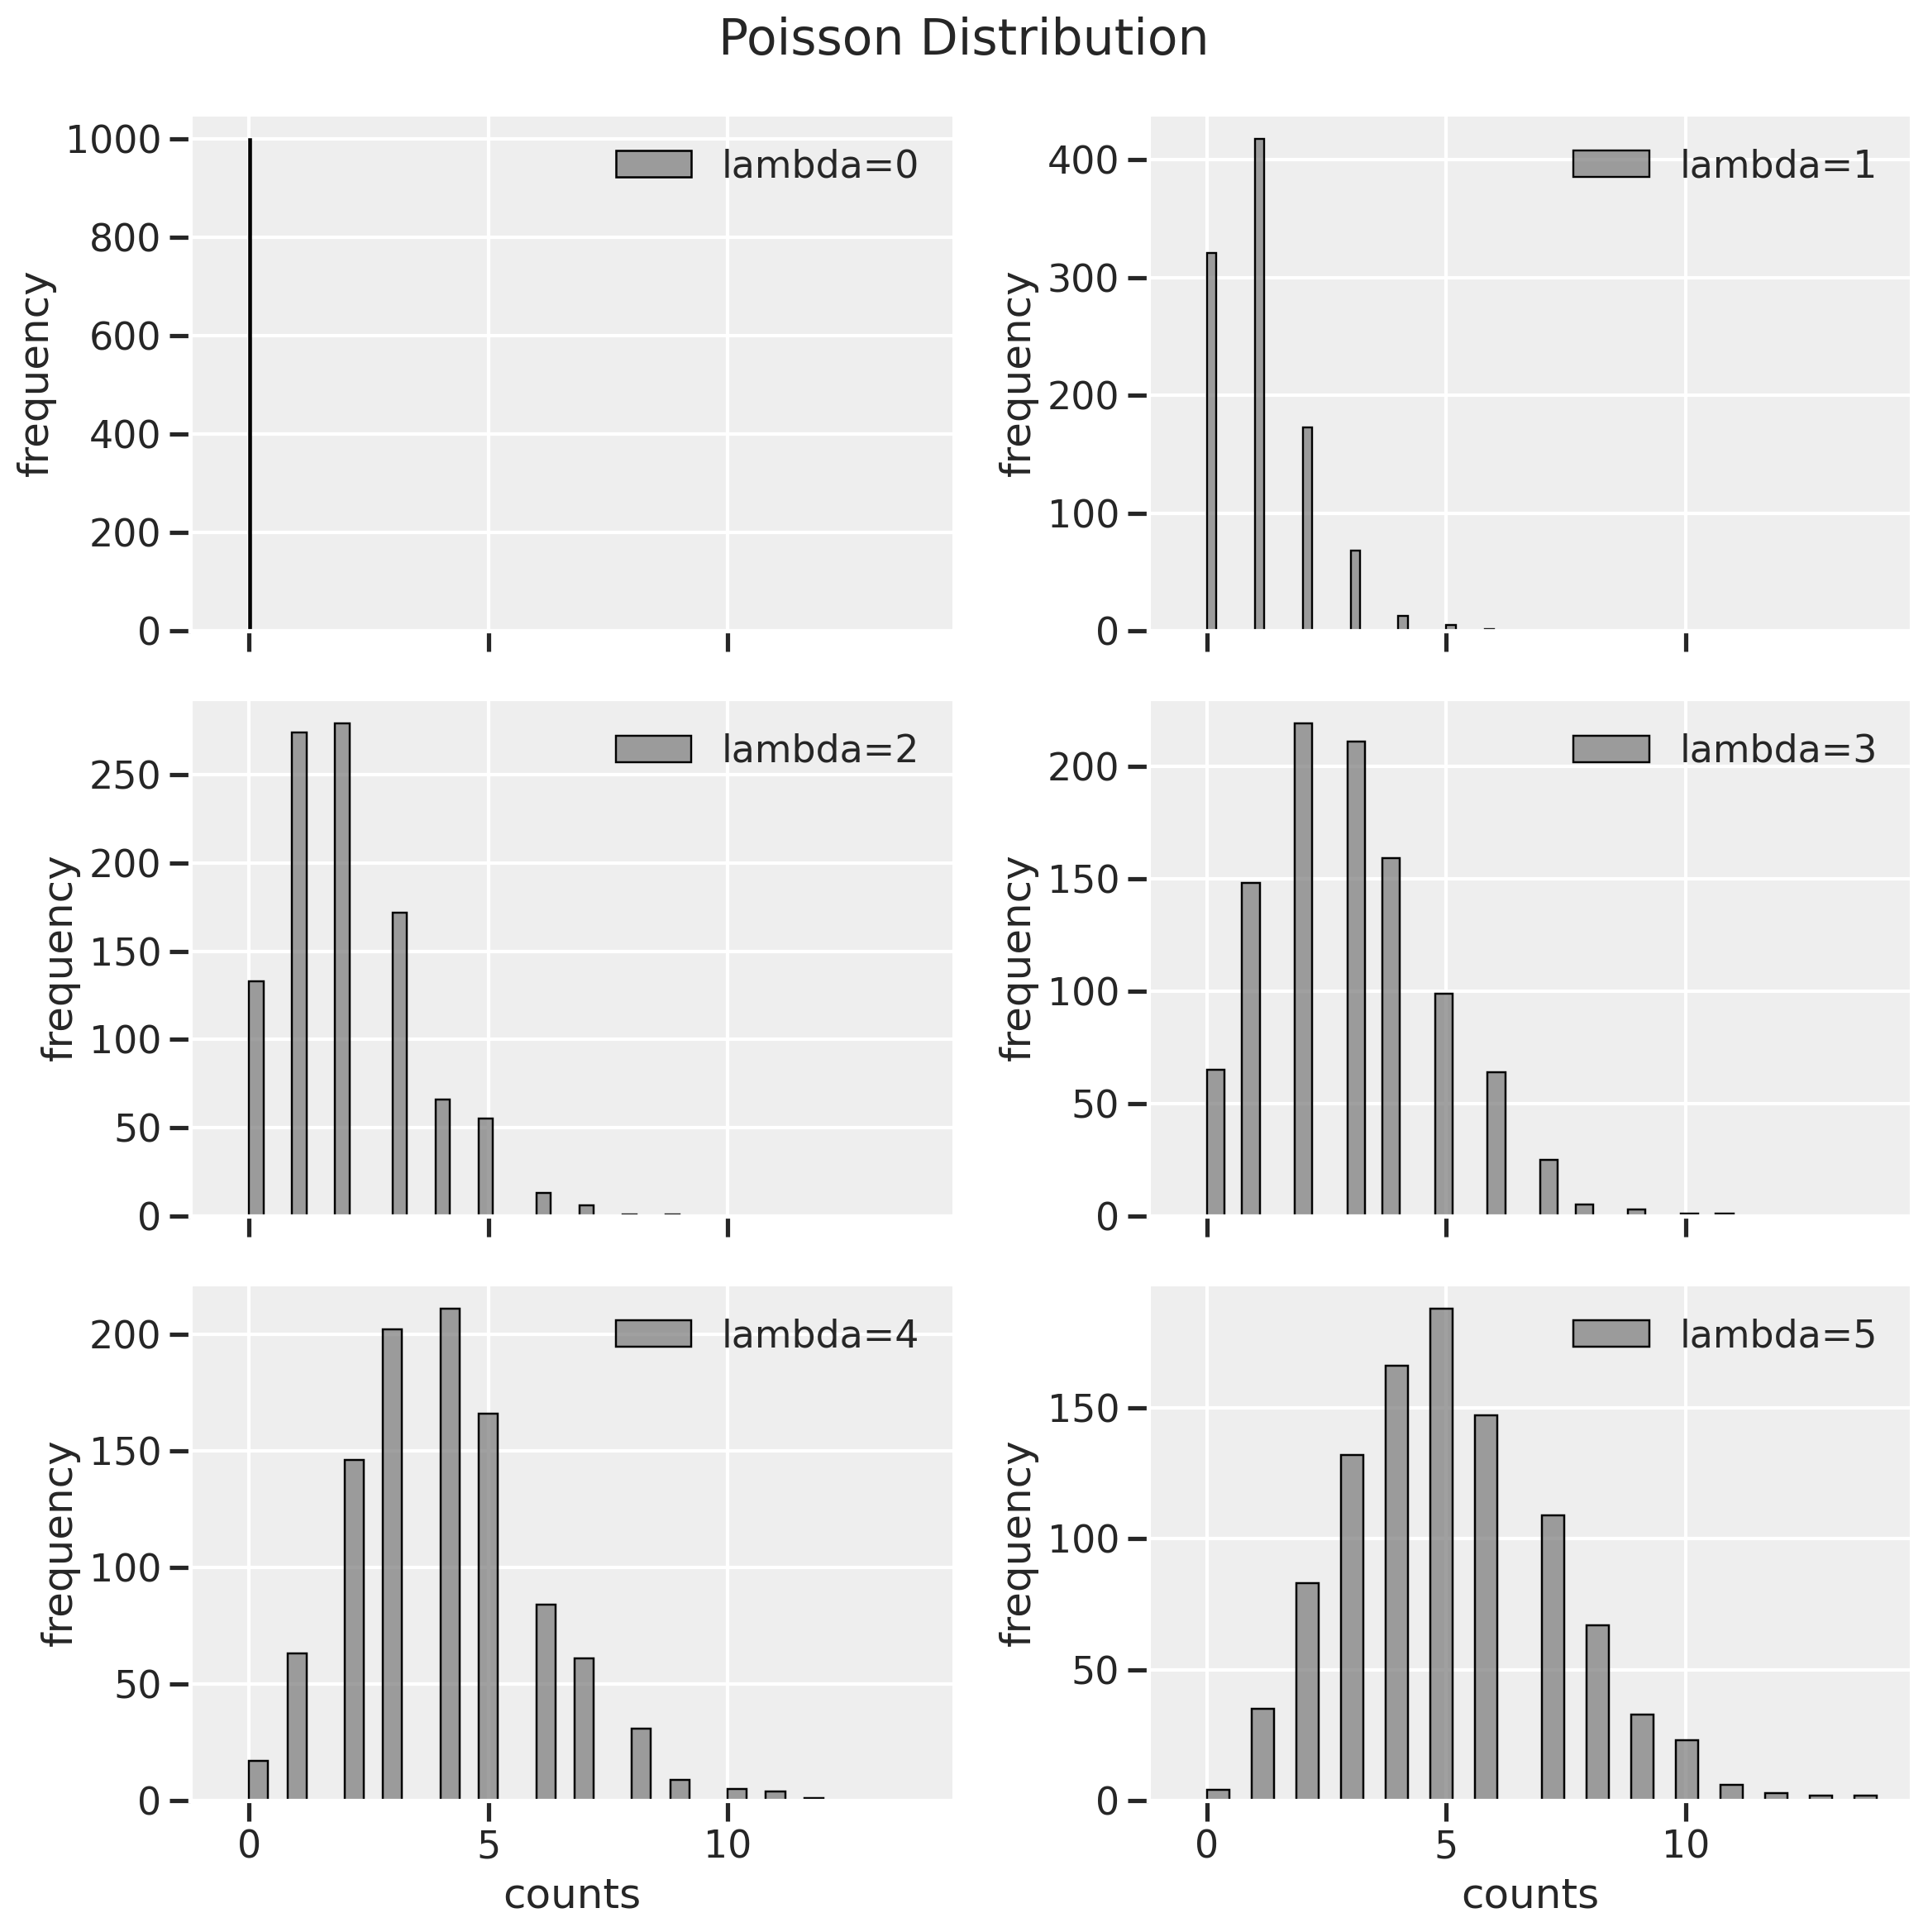

<IPython.core.display.Javascript object>

In [130]:
f, axes = plt.subplots(3, 2, figsize=(12, 12), sharex=True)

for i, ax in zip(range(6), axes.flat):
    data_poisson = poisson.rvs(mu=i, size=1000)
    sns.histplot(
        data_poisson, bins=30, kde=False, color="gray", ax=ax, label=f"lambda={i}"
    )
    
    ax.set(xlabel="counts", ylabel="frequency")
    ax.legend()

f.suptitle("Poisson Distribution")
plt.tight_layout()

A sensical prior was from doing the following exercise. Another consideration is that when choosing alpha, the log term will blow things up on the outcome scale. Remember from the book's tools example:

In [131]:
print(
    "Mean number of tools with alpha with Normal(0,10):  {0:0.2f}".format(
        pm.Lognormal.dist(0, 10).random(size=20_000).mean()
    )
)

print(
    "Mean number of tools with alpha with Normal(3,0.5): {0:0.2f}".format(
        pm.Lognormal.dist(3, 0.5).random(size=20_000).mean()
    ),
)

Mean number of tools with alpha with Normal(0,10):  14090045474734.54
Mean number of tools with alpha with Normal(3,0.5): 22.76


<IPython.core.display.Javascript object>

I peeked at the data, but we can choose something on the scale of the latter as a more sensible prior for the notes data.

### Prior prediction check for alpha

If alpha has a normal distribution, then lambda has a lognormal distribution.

In [132]:
print(
    "Mean of LogNormal(1, 0.5): {0:0.4f}".format(
        pm.Lognormal.dist(1, 0.5).random(size=20_000).mean()
    )
)

Mean of LogNormal(1, 0.5): 3.0852


<IPython.core.display.Javascript object>

It's more intuitive to me to exponentiate the normal distribution and this also works

In [133]:
print(
    "Mean after exponentiating Normal(1, 0.5): {0:0.4f}".format(
        np.exp(pm.Normal.dist(1, 0.5).random(size=20_000)).mean()
    )
)


Mean after exponentiating Normal(1, 0.5): 3.0931


<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Prior distribution for alpha (check)\n exponentiate normal dist')

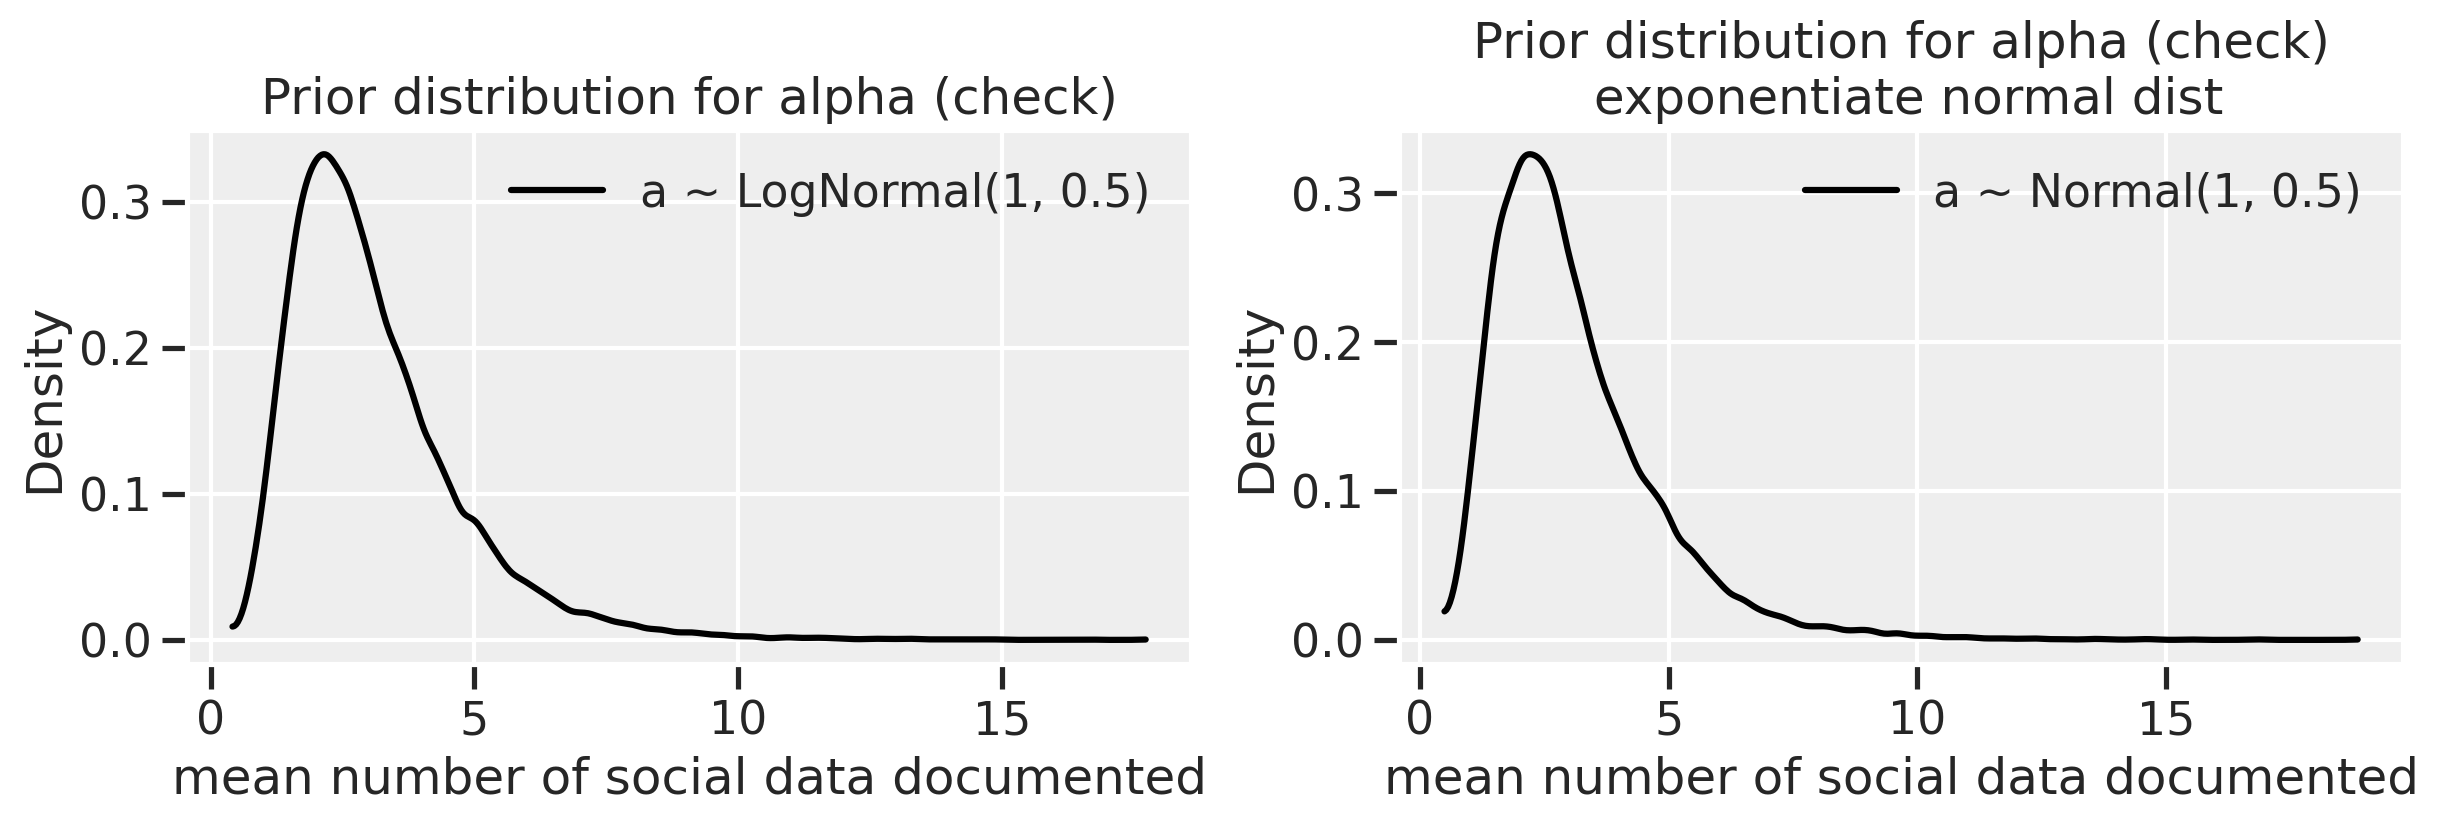

<IPython.core.display.Javascript object>

In [134]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
az.plot_kde(
    pm.Lognormal.dist(1, 0.5).random(size=20_000),
    label="a ~ LogNormal(1, 0.5)",
    plot_kwargs={"color": "k"},
    ax=ax1,
)
ax1.set_xlabel("mean number of social data documented")
ax1.set_ylabel("Density")
ax1.set_title("Prior distribution for alpha (check)")


az.plot_kde(
    np.exp(pm.Normal.dist(1, 0.5).random(size=20_000)),
    label="a ~ Normal(1, 0.5)",
    plot_kwargs={"color": "k"},
    ax=ax2,
)
ax2.set_xlabel("mean number of social data documented")
ax2.set_ylabel("Density")
ax2.set_title("Prior distribution for alpha (check)\n exponentiate normal dist")

Check out how high the number of social data can be supported in this distribution.

In [135]:
print(
    "Max of LogNormal(1, 1): {0:0.4f}".format(
        pm.Lognormal.dist(1, 0.5).random(size=20_000).max()
    )
)

Max of LogNormal(1, 1): 25.6336


<IPython.core.display.Javascript object>

This is probably too restrictive. Let's try a few more values for both mu and sigma to see if we can get broader distributions.

In [136]:
def plot_alpha_dist(mu, sigma, ax):
    min_dist, mean_dist, max_dist = (
        pm.Lognormal.dist(mu, sigma).random(size=20_000).min(),
        pm.Lognormal.dist(mu, sigma).random(size=20_000).mean(),
        pm.Lognormal.dist(mu, sigma).random(size=20_000).max(),
    )
    az.plot_kde(
        pm.Lognormal.dist(mu, sigma).random(size=20_000),
        plot_kwargs={"color": "k"},
        label=f"Min: {min_dist:0.2f}\nMean: {mean_dist:0.2f}\nMax: {max_dist:0.2f}",
        ax=ax,
    )

    ax.set_xlabel("number of social data documented")
    ax.set_ylabel("Density")
    ax.set_title(f"a ~ LogNormal({mu}, {sigma})")

<IPython.core.display.Javascript object>

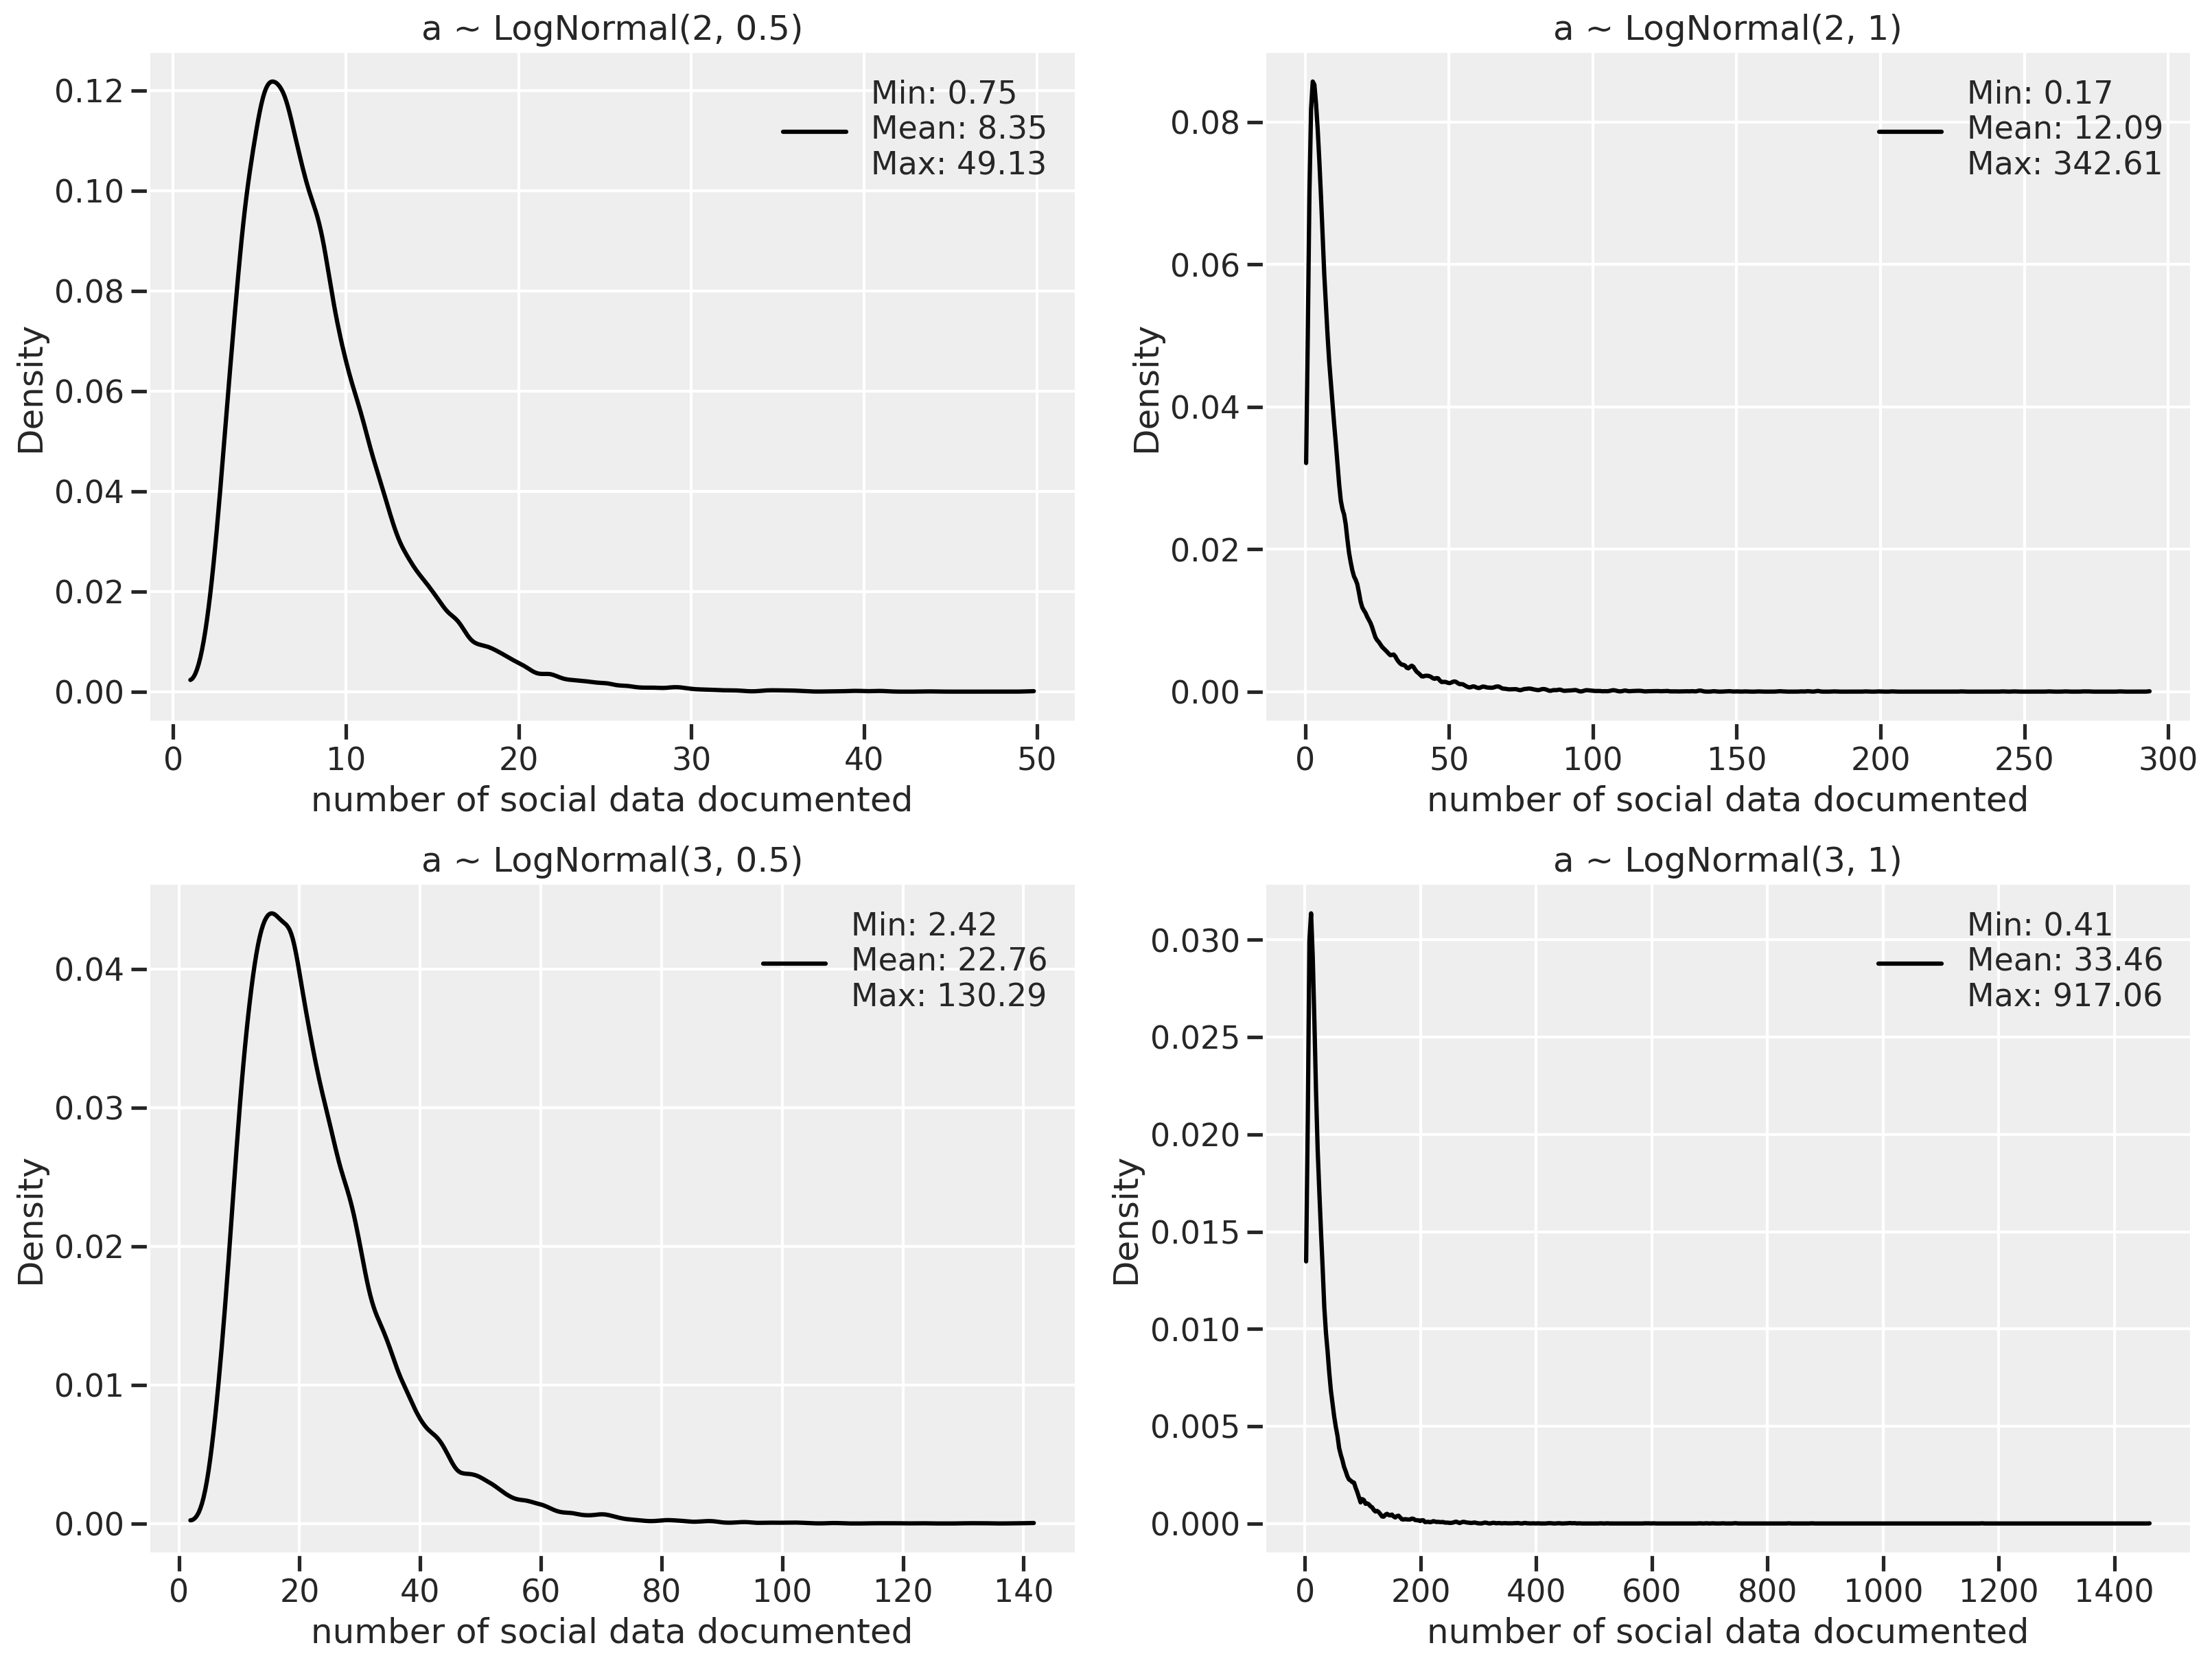

<IPython.core.display.Javascript object>

In [137]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
plot_alpha_dist(2, 0.5, ax1)
plot_alpha_dist(2, 1, ax2)
plot_alpha_dist(3, 0.5, ax3)
plot_alpha_dist(3, 1, ax4)

There are several decent options but I'll go with an alpha prior of `LogNormal(2,1)`. The distribution provides support for near 0 and the mean and max number of social data documented look reasonable.

In [138]:
# Intercept only model
with pm.Model() as m_notes1:
    # Prior chosen based on above
    a = pm.Normal("a", 2, 1, shape=5)

    # The link function, use `pm.math.exp` to get lambda
    lam = pm.Deterministic("lam", pm.math.exp(a[df_srfs_counts["note_type_code"]]))

    # Likelihood,
    t = pm.Poisson("t", mu=lam, observed=df_srfs_counts["n_tags"])

    trace_m_notes1 = pm.sample(1000, tune=1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]
INFO:pymc3:NUTS: [a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


<IPython.core.display.Javascript object>

In [139]:
az.summary(trace_m_notes1, var_names="a", round_to=2)

mean    sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_mean   ess_sd  \
a[0]  1.74  0.04      1.67       1.80        0.0      0.0   6437.53  6427.58   
a[1]  1.85  0.02      1.82       1.89        0.0      0.0   6298.26  6291.79   
a[2] -2.85  0.20     -3.14      -2.50        0.0      0.0   7681.73  7547.73   
a[3]  0.20  0.05      0.13       0.27        0.0      0.0   6614.47  6291.30   
a[4] -1.33  0.10     -1.50      -1.18        0.0      0.0   6980.87  6800.05   

      ess_bulk  ess_tail  r_hat  
a[0]   6434.94   3137.20    1.0  
a[1]   6303.84   3240.34    1.0  
a[2]   7319.62   3206.15    1.0  
a[3]   6633.65   3134.85    1.0  
a[4]   7021.82   2965.13    1.0

<IPython.core.display.Javascript object>

In [140]:
# Verification that code assignment is alphabetical order
df_srfs_counts[["note_type", "note_type_code"]].drop_duplicates()

note_type  note_type_code
0        ED_Provider_Notes               0
102                    H&P               1
433   Patient_Instructions               2
819         Progress_Notes               3
1205   Telephone_Encounter               4

<IPython.core.display.Javascript object>

Since this model is pretty simple, we can have some interpretation of the alpha parameters. The pattern of alpha being negative for `Patient_Instructions` and `Telephone_Encounter` is in line with most notes of these types having a low number of social data documented.

To get more intuition of these parameters, we can make posterior predictions.

In [141]:
with m_notes1:
    post_pc = pm.sample_posterior_predictive(trace=trace_m_notes1)

<IPython.core.display.Javascript object>

In [142]:
post_pc["t"].shape

(4000, 1577)

<IPython.core.display.Javascript object>

In [143]:
post_pc["t"][0, :]

array([5, 7, 2, ..., 0, 1, 1])

<IPython.core.display.Javascript object>

In [144]:
# Make a temp dataframe so I can use seaborn scatterplot
df_srfs_counts_temp = df_srfs_counts.copy()
df_srfs_counts_temp["model1_postpred_sample0"] = post_pc["t"][0, :]
df_srfs_counts_temp.head()

note_type                file  n_tags n_chars_note  note_type_code  \
0  ED_Provider_Notes  646702875_Matt.xml    10.0         8644               0   
1  ED_Provider_Notes  742238643_Matt.xml     4.0         8122               0   
2  ED_Provider_Notes  658813952_Matt.xml     9.0         6672               0   
3  ED_Provider_Notes  650368122_Matt.xml    20.0        15323               0   
4  ED_Provider_Notes  705769932_Matt.xml    15.0         7870               0   

   model1_postpred_sample0  
0                        5  
1                        7  
2                        2  
3                        6  
4                        8

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'observed vs. predicted (first sample)')

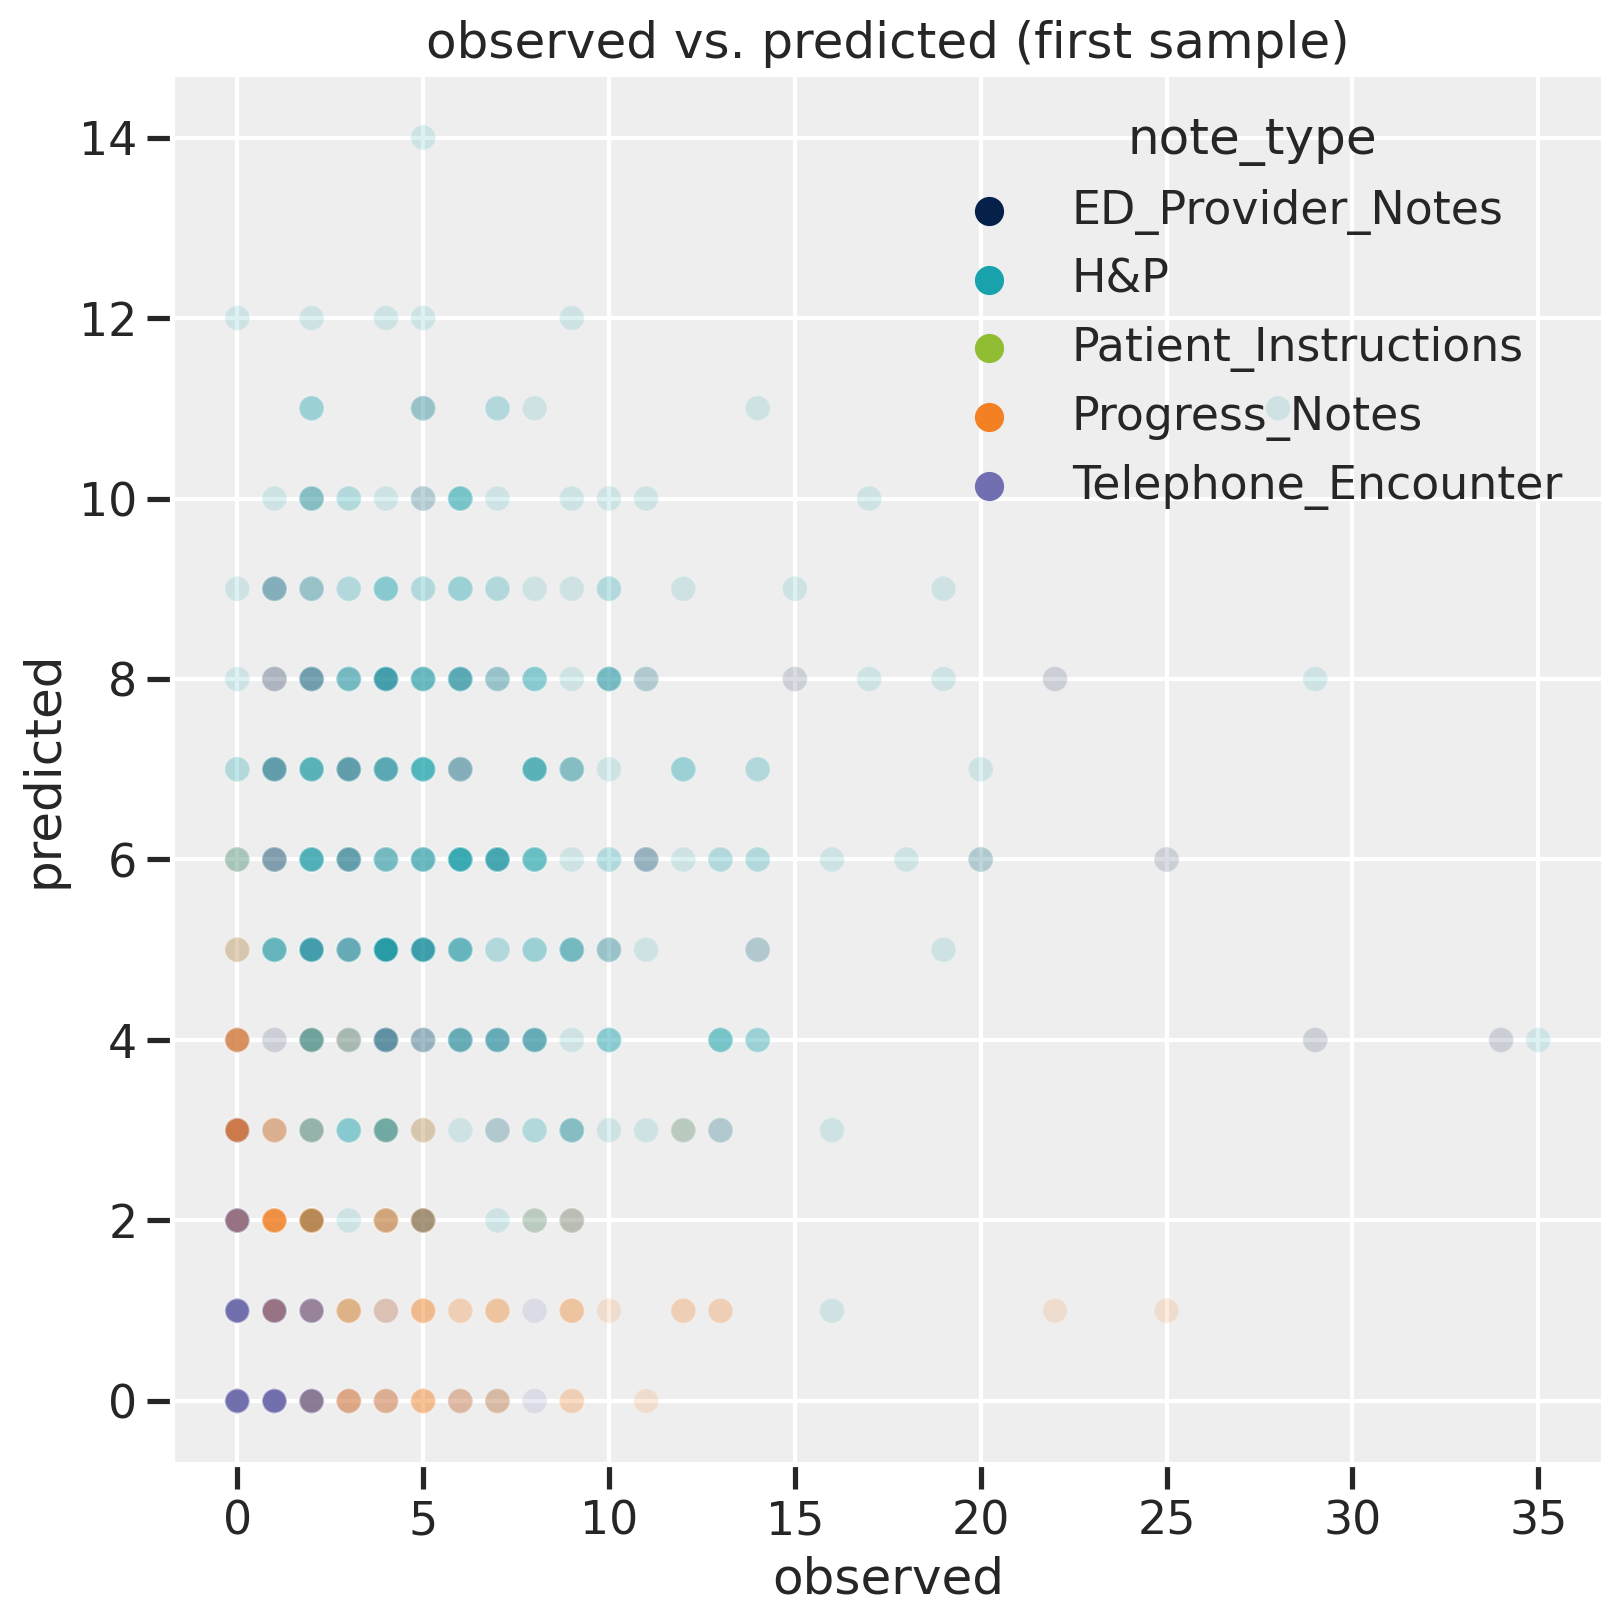

<IPython.core.display.Javascript object>

In [145]:
f, ax1 = plt.subplots(figsize=(8, 8))
sns.scatterplot(
    data=df_srfs_counts_temp,
    x="n_tags",
    y="model1_postpred_sample0",
    hue="note_type",
    palette=sf_palette[0:5],
    alpha=0.15,
    ax=ax1,
)

ax1.set_xlabel("observed")
ax1.set_ylabel("predicted")
ax1.set_title("observed vs. predicted (first sample)")

It's hard to see overlaps so let's plot it separately.

In [385]:
# can't get this to work, just write own code
# g, ax1 = plt.subplots(figsize=(12, 12))
# g = sns.FacetGrid(df_srfs_counts_temp, col="note_type")
# g.map(sns.scatterplot, "n_tags", "model1_postpred_sample0")

# ax1.set_xlabel("test")

<IPython.core.display.Javascript object>

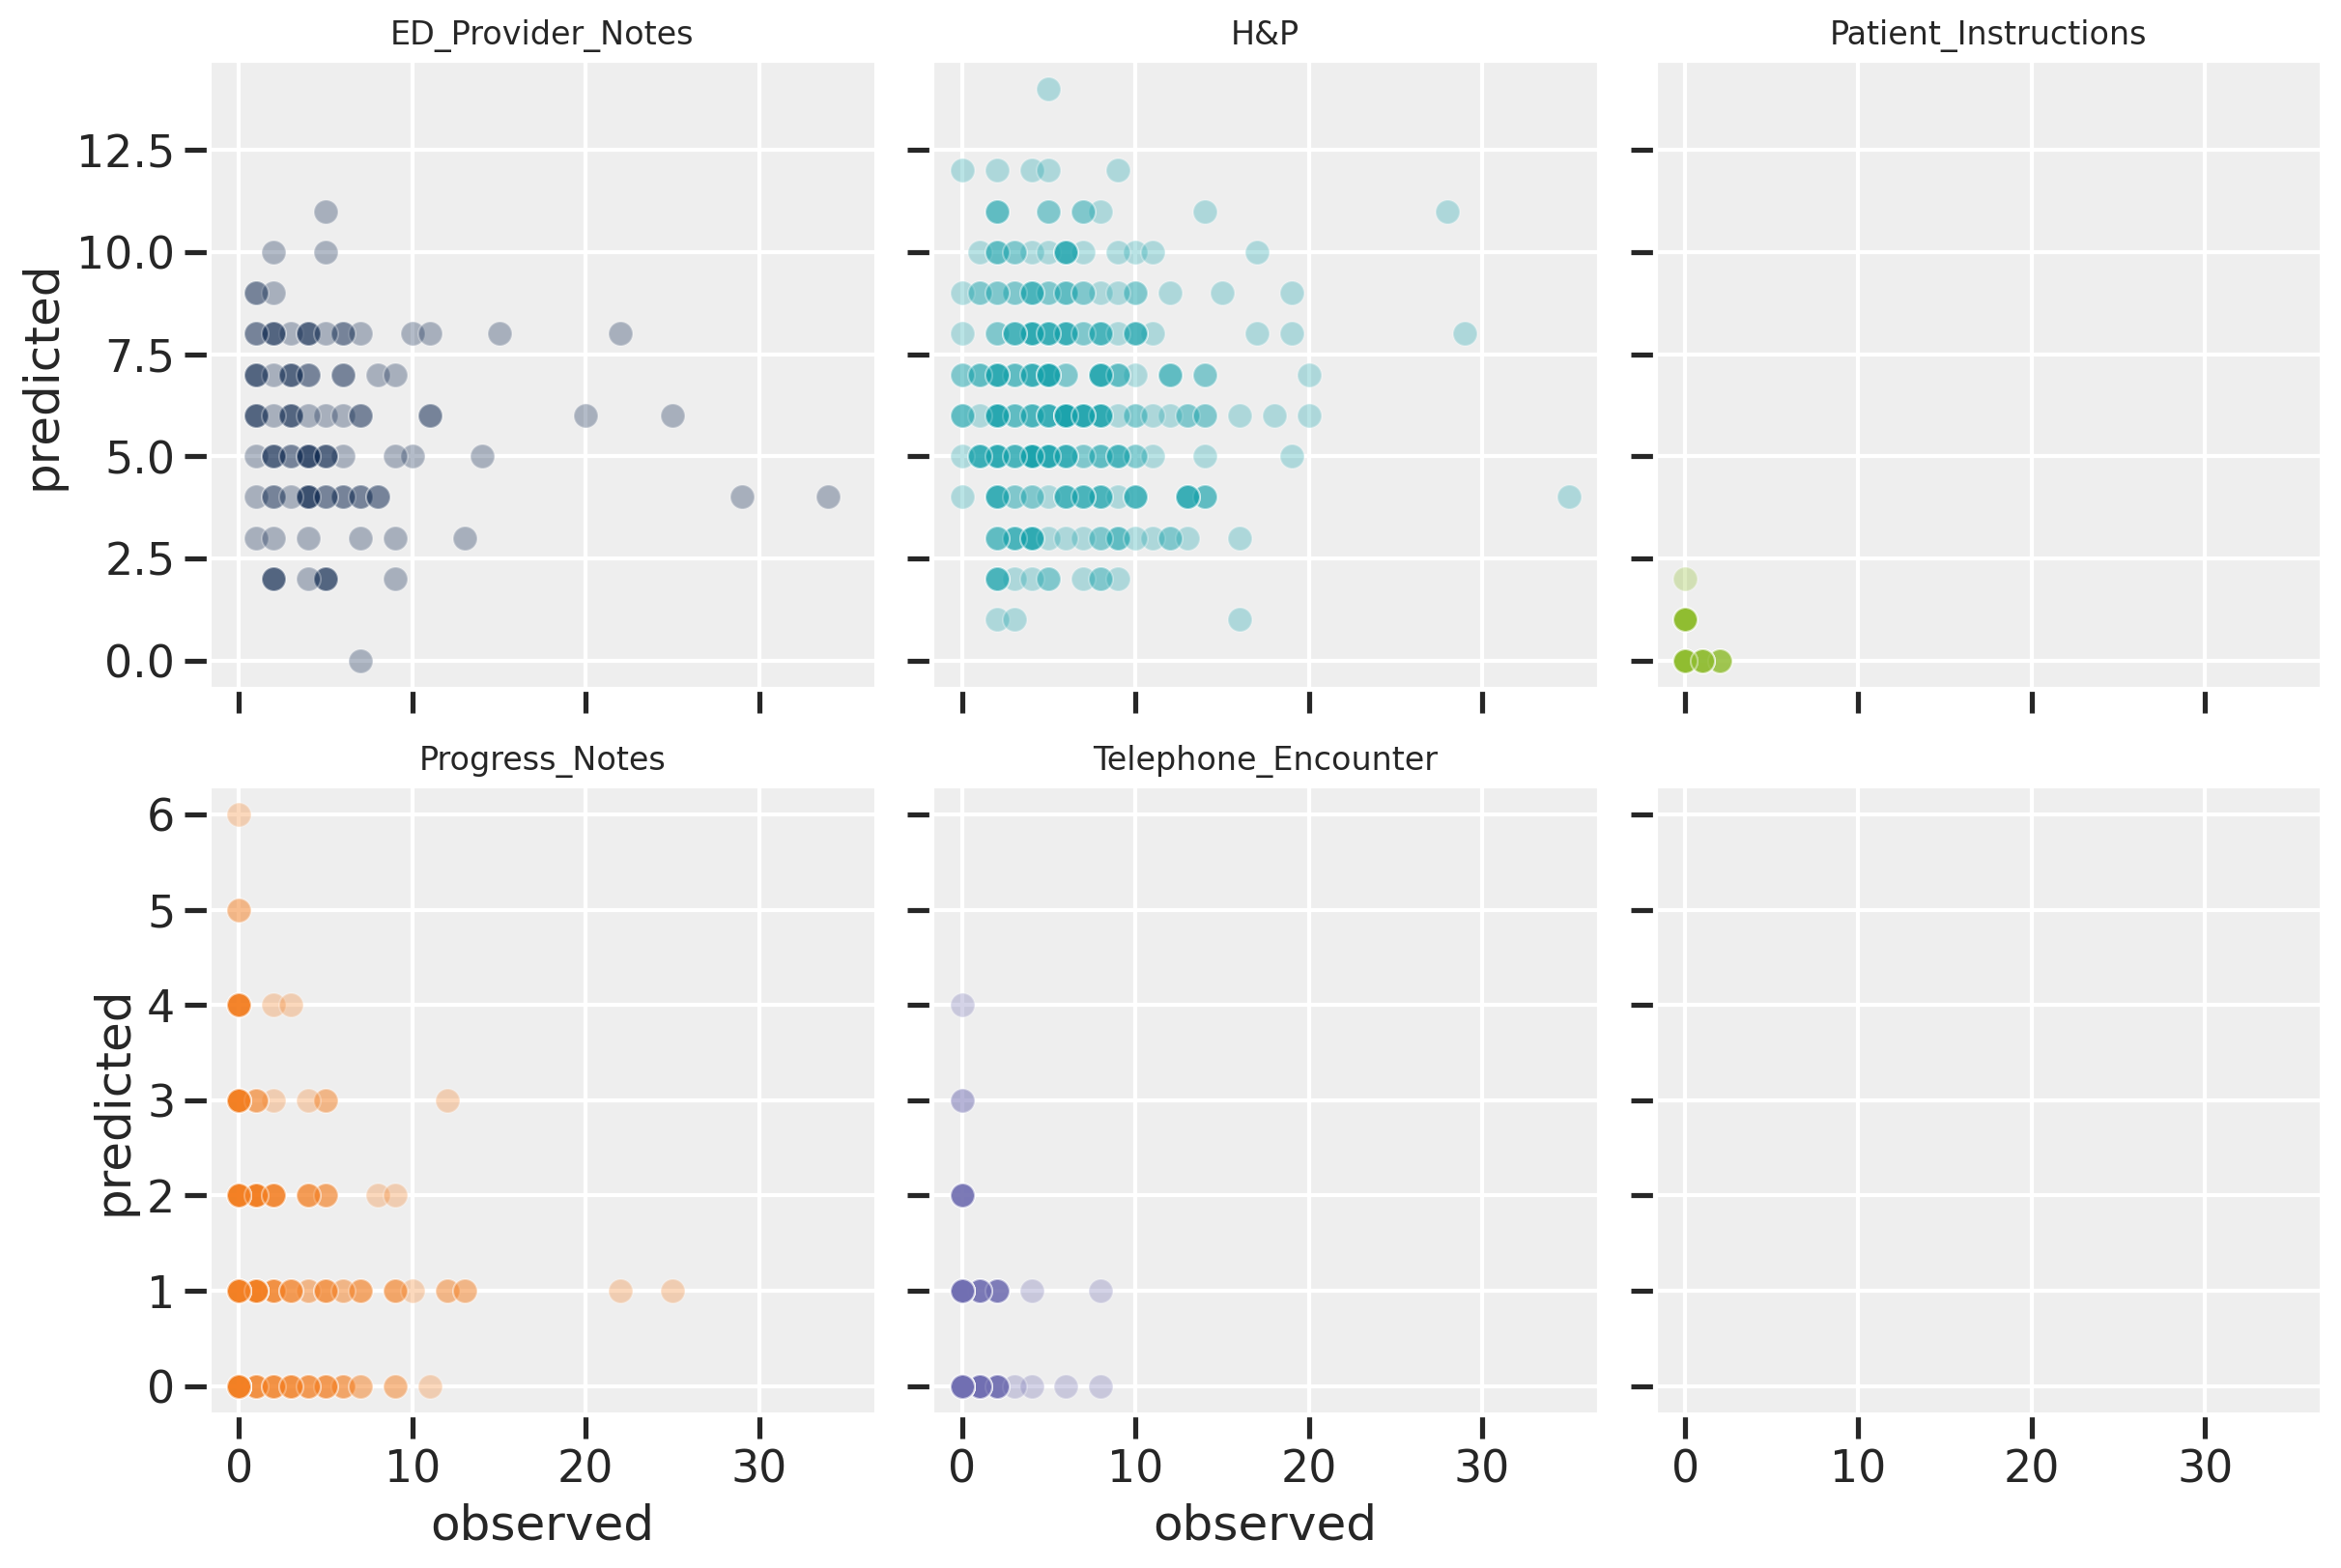

<IPython.core.display.Javascript object>

In [146]:
f, axs = plt.subplots(2, 3, figsize=(12, 8), sharex=True, sharey="row")
note_types = df_srfs_counts_temp["note_type"].unique()
colors = sf_palette[0:5]

for note_type, color, ax in zip(note_types, colors, axs.flat):
    df_srfs_counts_temp_note = df_srfs_counts_temp[
        df_srfs_counts_temp["note_type"] == note_type
    ].copy()

    sns.scatterplot(
        data=df_srfs_counts_temp_note,
        x="n_tags",
        y="model1_postpred_sample0",
        color=color,
        alpha=0.3,
        ax=ax,
    )

    ax.set_xlabel("observed")
    ax.set_ylabel("predicted")
    ax.set_title(f"{note_type}", fontsize=12)

# f.tight_layout()

The outcome scale of the predictions look reasonable, and it seems to do okay predicting the categories with few social tags, but there's very little predictive power with this alpha only model.

## Note type and note length (linear) model

Let's extend this by including note length in the model. We know that some note types are generally shorter, meaning therefore the counts of social tags would also be lower, so we should factor that into the model.

- Patient instruction notes are generally short, but is there more social data in patient_instruction notes that are long? Include the note type as an interaction with note length (denoted as x below).

$$y_i \text{ ~ } \text{Poisson}(\lambda_i) $$ 

$$\text{log}(\lambda_i) = \alpha_{\text{type}[i]} + \beta_{\text{type}[i]} x_i$$ 

$$\alpha_{j} \text{ ~ Normal}(2, 1) $$
$$\beta_{j} \text{~ TBD} $$

Like the process for determining alpha, we'll do prior predictive simulations to see what values we should do for beta. Here, we confirm with some data visualization that some note type categories are associated with variability in length of the the note.

Text(0.5, 0, '')

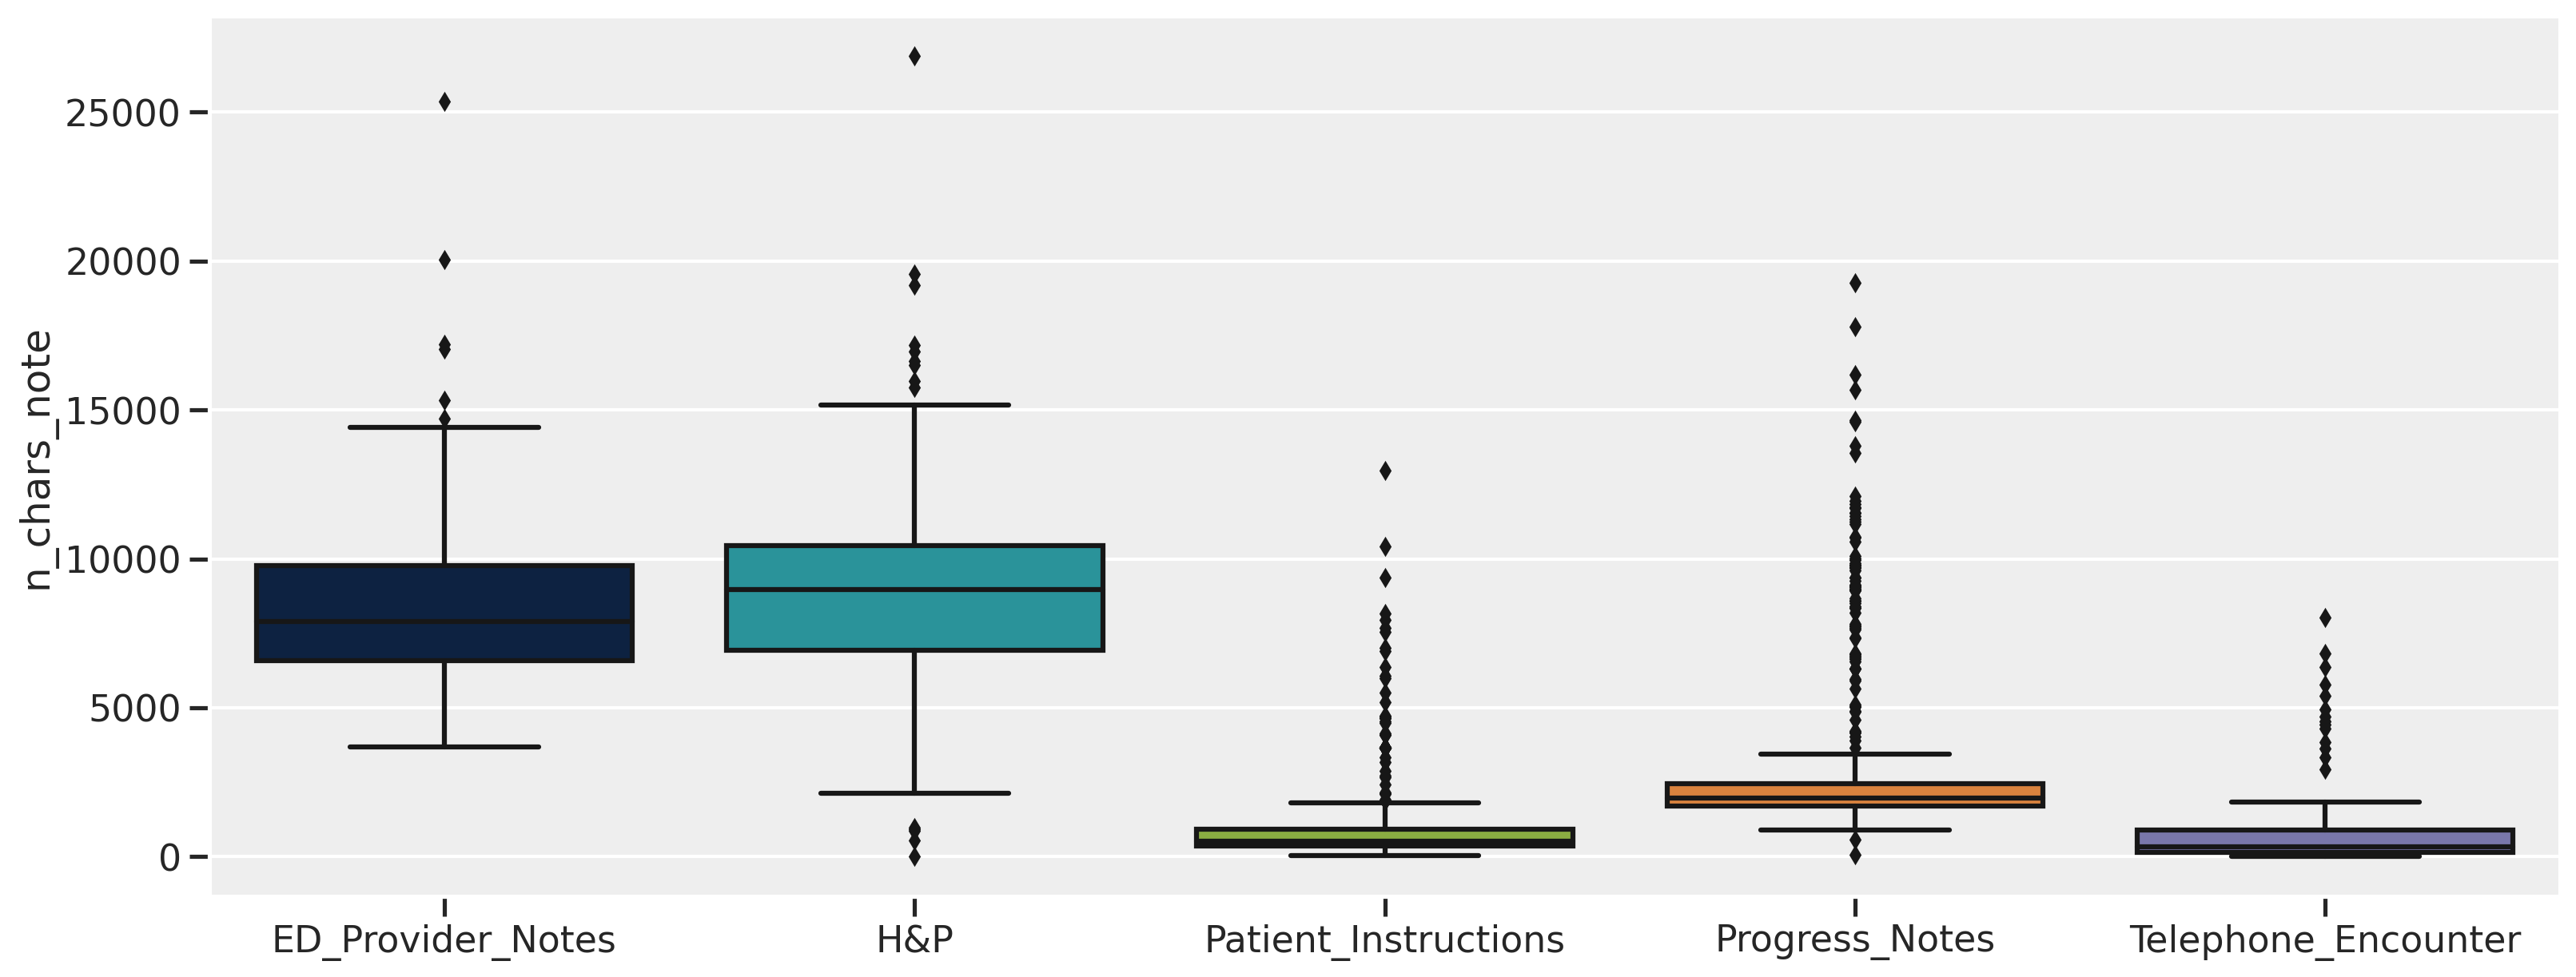

<IPython.core.display.Javascript object>

In [147]:
f, ax1 = plt.subplots(figsize=(16, 6))
sns.boxplot(data=df_srfs_counts, x="note_type", y="n_chars_note", palette=sf_palette)
ax1.set_xlabel("")

Text(0.5, 0, '')

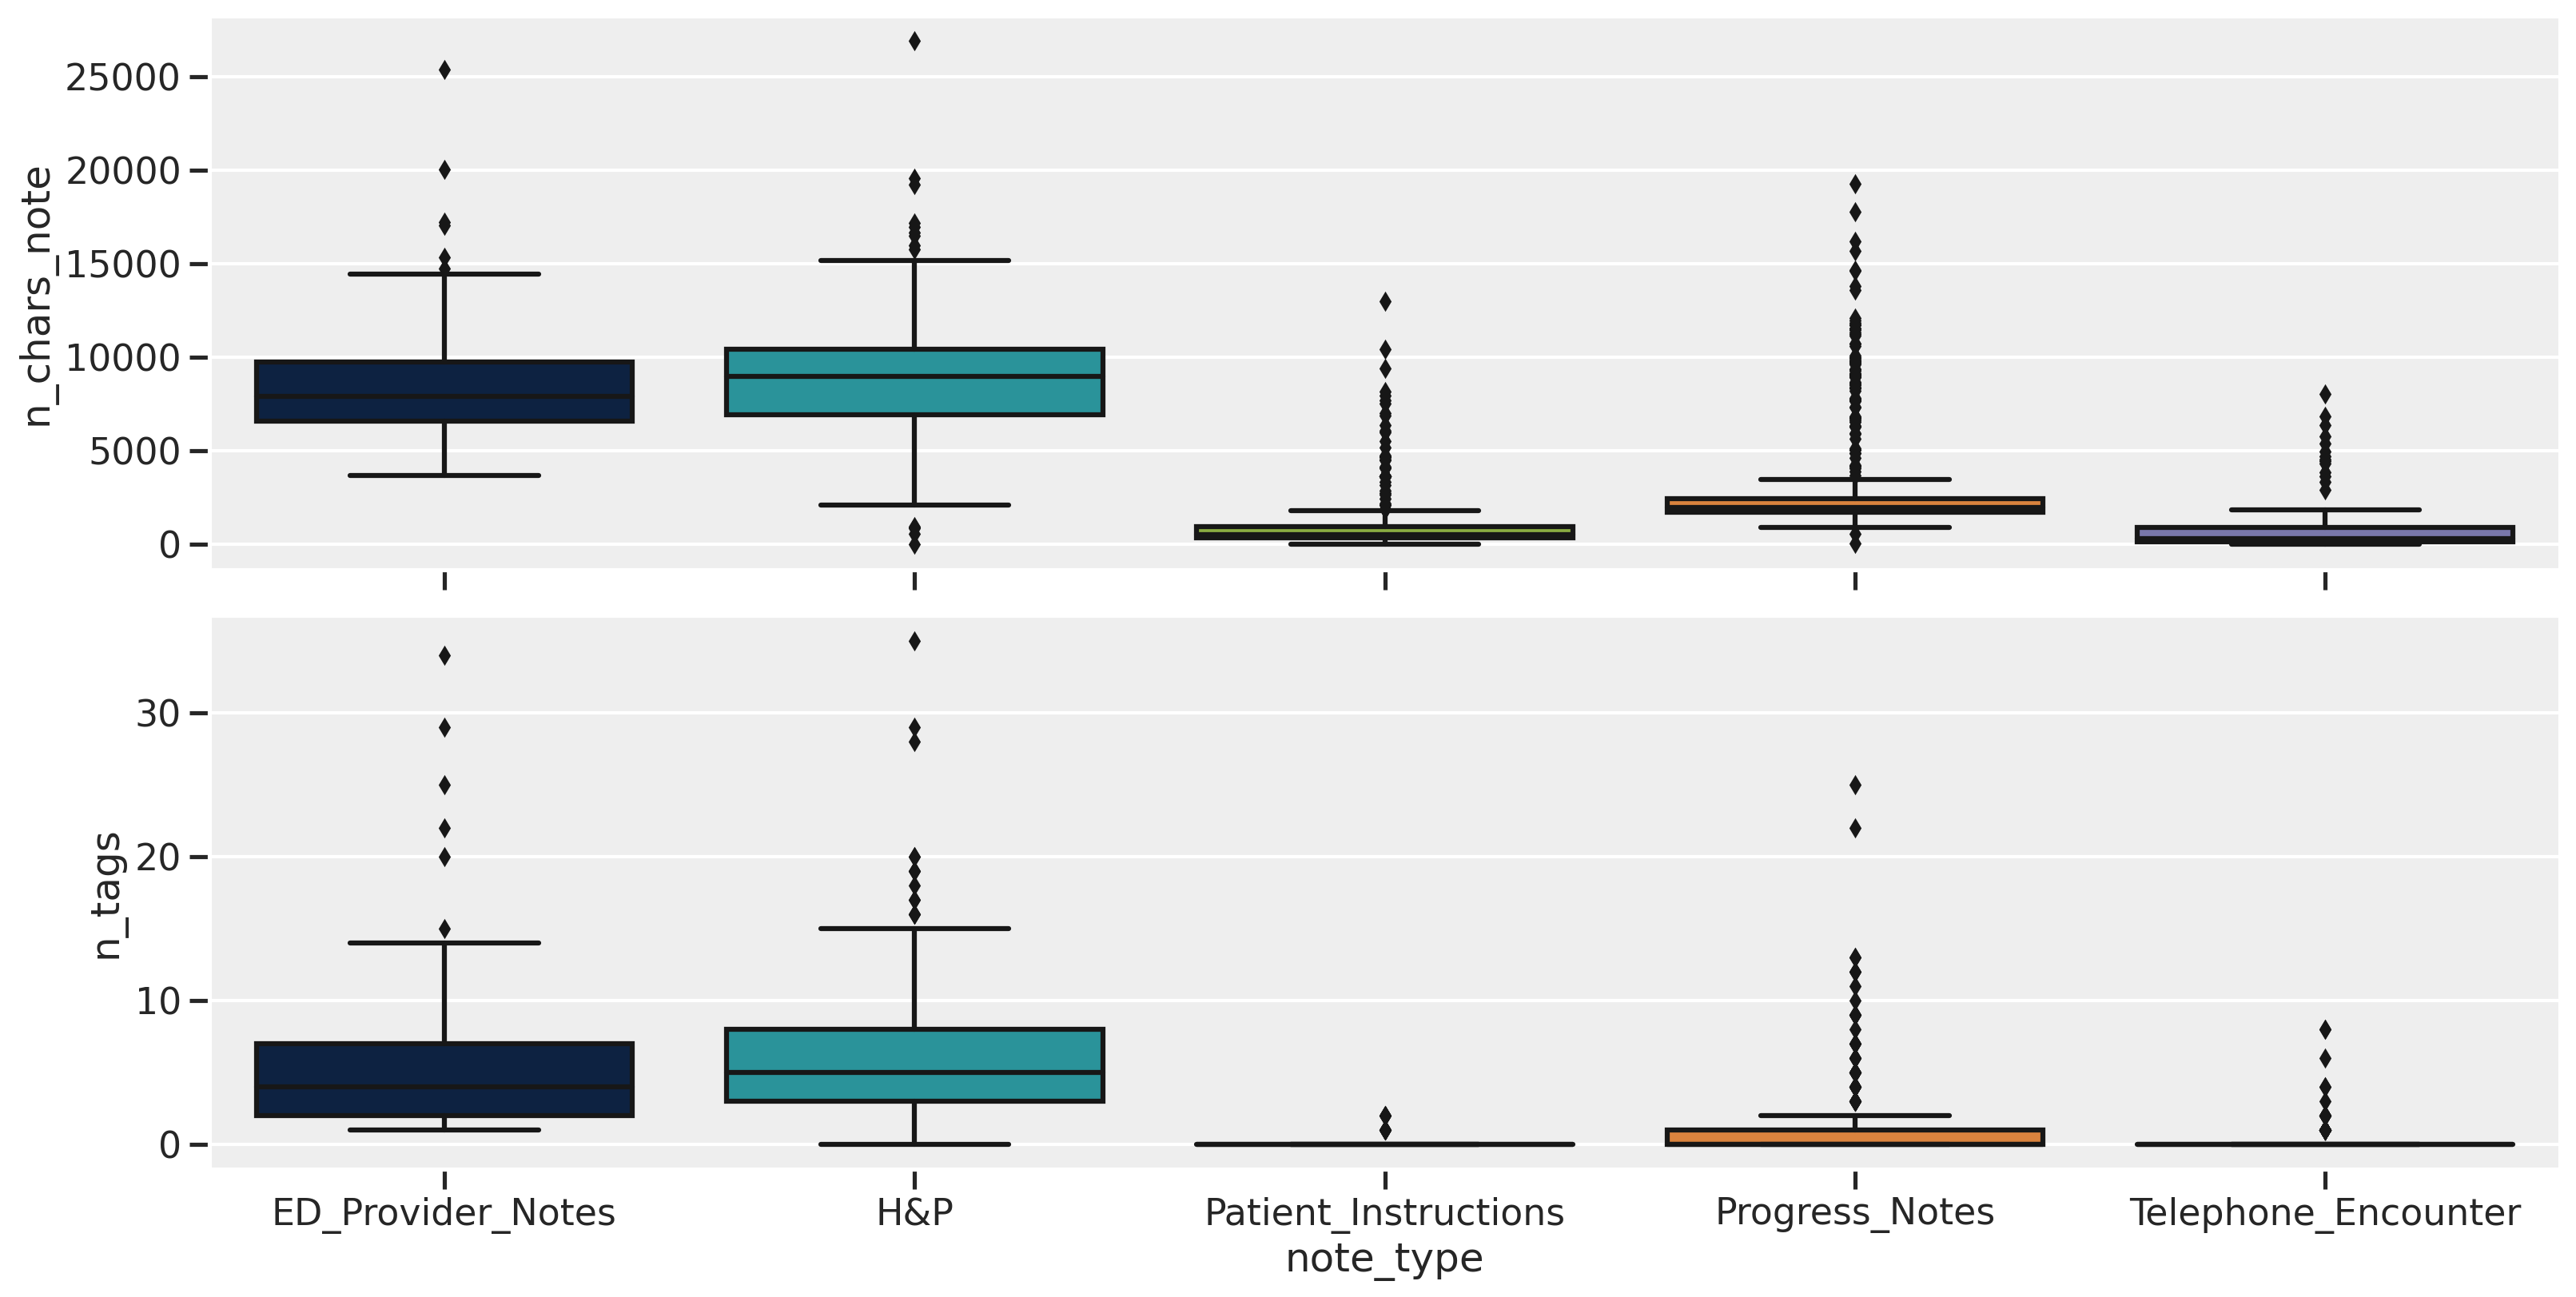

<IPython.core.display.Javascript object>

In [148]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 8), sharex=True)
sns.boxplot(
    data=df_srfs_counts, x="note_type", y="n_chars_note", palette=sf_palette, ax=ax1
)
sns.boxplot(data=df_srfs_counts, x="note_type", y="n_tags", palette=sf_palette, ax=ax2)
ax1.set_xlabel("")

In [149]:
output_dir2

'/Users/blacar/Documents/ds_projects/sdoh_text/cocoa/edemarchis_GRP/skippy-2020-02-12-per-type_output/'

<IPython.core.display.Javascript object>

In [150]:
"/Users/blacar/Documents/ds_projects/sdoh_text/cocoa/edemarchis_GRP/skippy-2020-02-12-per-type_output"

'/Users/blacar/Documents/ds_projects/sdoh_text/cocoa/edemarchis_GRP/skippy-2020-02-12-per-type_output'

<IPython.core.display.Javascript object>

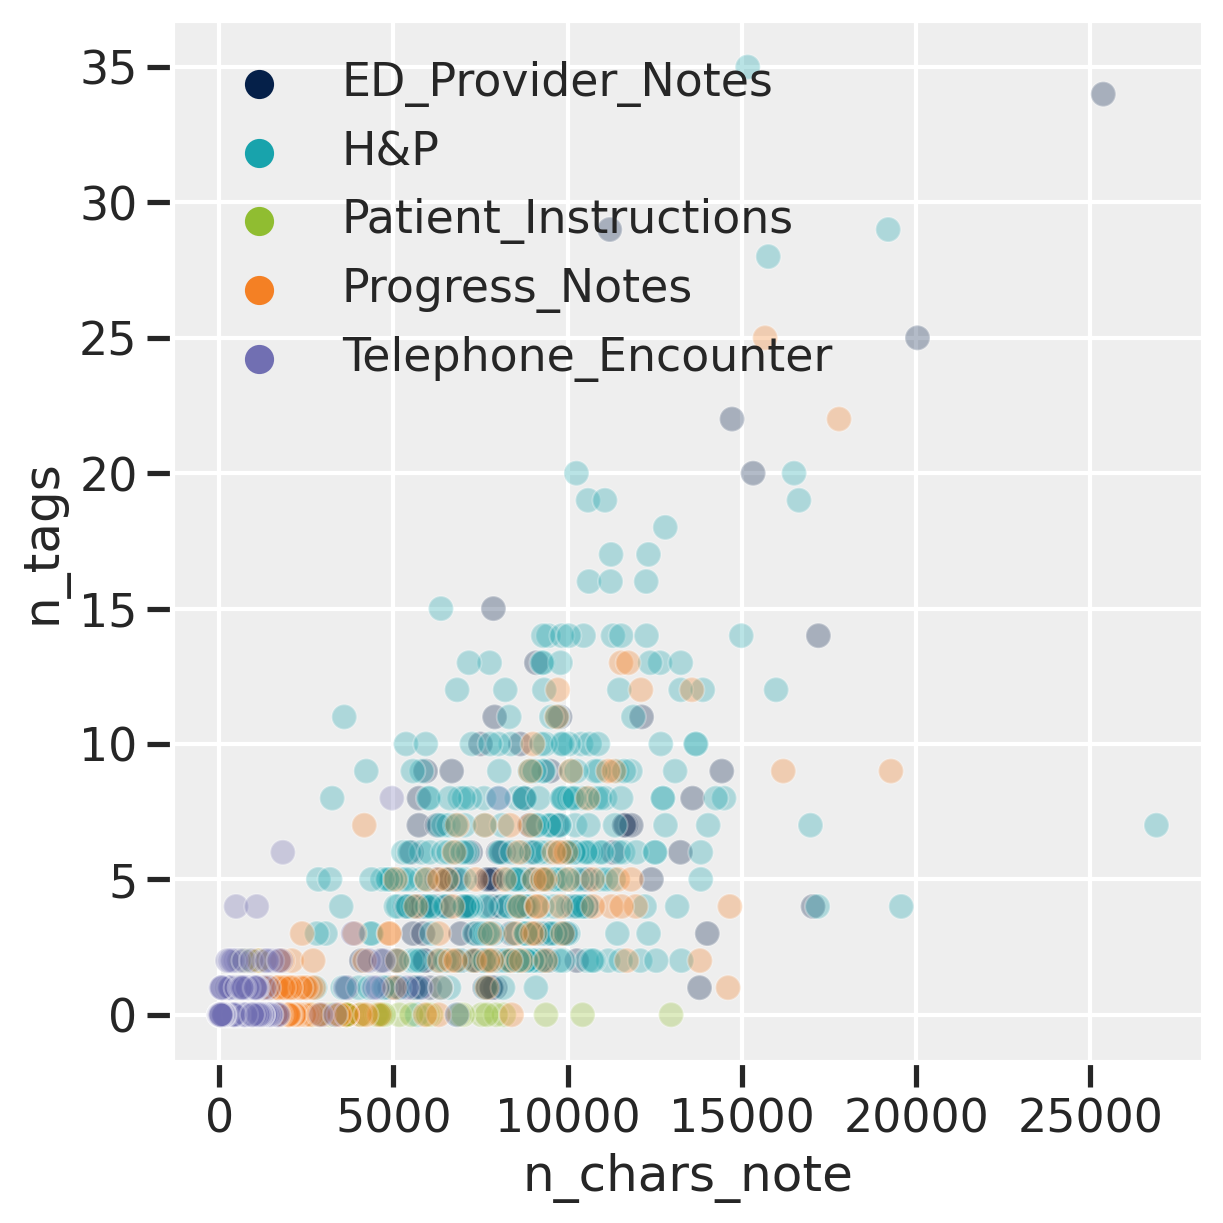

<IPython.core.display.Javascript object>

In [330]:
f, ax1 = plt.subplots(figsize=(6, 6))

sns.scatterplot(
    data=df_srfs_counts,
    x="n_chars_note",
    y="n_tags",
    hue="note_type",
    palette=sf_palette[0:5],
    alpha=0.3,
)
ax1.legend(title=None)

# sns.regplot(data=df_srfs_counts, x="n_chars_note", y="n_tags", ci=False, ax=ax1)

# plt.savefig(output_dir2 + "/scatter_notelength_tags.png", bbox_inches="tight")

Check that the `Patient_Instructions` note type really does have few tags.

In [152]:
df_srfs_counts[df_srfs_counts["note_type"] == "Patient_Instructions"].sort_values(
    by="n_chars_note", ascending=False
)

note_type                file  n_tags n_chars_note  \
712  Patient_Instructions  750277445_Sara.xml     0.0        12969   
590  Patient_Instructions  904785807_Sara.xml     0.0        10428   
757  Patient_Instructions  682526920_Sara.xml     0.0         9379   
456  Patient_Instructions  657541460_Sara.xml     0.0         8169   
591  Patient_Instructions  706084881_Sara.xml     0.0         7943   
..                    ...                 ...     ...          ...   
509  Patient_Instructions  721313991_Sara.xml     0.0           44   
750  Patient_Instructions  683471317_Sara.xml     0.0           33   
441  Patient_Instructions  674130338_Sara.xml     0.0           32   
656  Patient_Instructions  637068419_Sara.xml     0.0           27   
563  Patient_Instructions  633647935_Sara.xml     0.0           23   

     note_type_code  
712               2  
590               2  
757               2  
456               2  
591               2  
..              ...  
509               2  
750               2  
441               2  
656               2  
563               2  

[386 rows x 5 columns]

<IPython.core.display.Javascript object>

### Prior prediction check for beta

Here, we would use a combination of alpha (already established above as `Normal(2,1)`) and different beta distribution values to generate log(lambda), then exponentiate to generate predictions.'

The `x` in this case would be the range of characters for a note. **Right now, I'm assuming there's a linear relationship between number of characters and number of tags. Just do a linear model?**



#### Model specification


$$y_i \text{ ~ } \text{Poisson}(\lambda_i) $$ 

$$\text{log}(\lambda_i) = \alpha_{\text{type}[i]} + \beta_{\text{type}[i]} x_i$$ 

$$\alpha_{j} \text{ ~ Normal}(1, 0.5) $$
$$\beta_{j} \text{ ~ Normal}(1, 0.5) $$

In [163]:
# standardize number of characters
df_srfs_counts["n_chars_note_std"] = standardize(df_srfs_counts["n_chars_note"])

# Doing this due to an error with pymc
df_srfs_counts["n_chars_note_std"] = df_srfs_counts["n_chars_note_std"].astype("float")

<IPython.core.display.Javascript object>

In [164]:
df_srfs_counts["n_chars_note_std"]

0       1.194551
1       1.069144
2       0.720790
3       2.799138
4       1.008602
          ...   
1572   -0.081383
1573   -0.873947
1574   -0.867461
1575   -0.653163
1576   -0.870103
Name: n_chars_note_std, Length: 1577, dtype: float64

<IPython.core.display.Javascript object>

In [165]:
print(
    "range of characters: ",
    df_srfs_counts["n_chars_note"].min(),
    df_srfs_counts["n_chars_note"].max(),
)

range of characters:  1 26897


<IPython.core.display.Javascript object>

#### Multiplying by linear x

In [166]:
# Plot 50 lines over the range of (0, 30000) characters
N = 50
xrange = np.linspace(0, 30_000, N)
# alpha values
alphas = pm.Normal.dist(2, 1).random(size=N)
# beta values
betas = pm.Normal.dist(0, 0.5).random(size=N)


<IPython.core.display.Javascript object>

In [167]:
xrange

array([    0.        ,   612.24489796,  1224.48979592,  1836.73469388,
        2448.97959184,  3061.2244898 ,  3673.46938776,  4285.71428571,
        4897.95918367,  5510.20408163,  6122.44897959,  6734.69387755,
        7346.93877551,  7959.18367347,  8571.42857143,  9183.67346939,
        9795.91836735, 10408.16326531, 11020.40816327, 11632.65306122,
       12244.89795918, 12857.14285714, 13469.3877551 , 14081.63265306,
       14693.87755102, 15306.12244898, 15918.36734694, 16530.6122449 ,
       17142.85714286, 17755.10204082, 18367.34693878, 18979.59183673,
       19591.83673469, 20204.08163265, 20816.32653061, 21428.57142857,
       22040.81632653, 22653.06122449, 23265.30612245, 23877.55102041,
       24489.79591837, 25102.04081633, 25714.28571429, 26326.53061224,
       26938.7755102 , 27551.02040816, 28163.26530612, 28775.51020408,
       29387.75510204, 30000.        ])

<IPython.core.display.Javascript object>

In [168]:
alphas

array([1.27720328, 1.52993414, 1.84498491, 1.81996891, 1.92885588,
       3.65936055, 3.35814893, 1.05341953, 2.03556708, 1.28902052,
       2.25293854, 1.08774804, 2.33421321, 3.92285737, 2.12459183,
       2.14229678, 2.31147162, 2.15331259, 1.8938379 , 1.85847008,
       1.43110837, 1.87712713, 1.71921939, 1.95332002, 4.18245499,
       2.68441034, 1.33889161, 2.09559689, 2.02093413, 1.08971764,
       3.08970026, 2.28811535, 2.14847471, 1.14920839, 1.67652297,
       0.96130806, 1.27136891, 3.57045962, 0.70572805, 2.853365  ,
       2.75119808, 1.86957173, 1.10471624, 1.92874197, 2.5809277 ,
       1.66113609, 2.17107188, 0.53884824, 1.61781044, 2.37414741])

<IPython.core.display.Javascript object>

In [169]:
betas

array([ 0.38003661,  1.0735438 ,  0.19330302,  0.9293576 , -0.18956291,
       -0.16857388,  0.1489663 ,  0.10477809, -0.38720284, -0.06129708,
       -0.23869407,  0.13232936, -0.3820509 ,  0.05244845,  0.75688975,
       -0.76046065,  0.22548093,  0.16710383,  0.37890747,  0.51717594,
       -0.29592098,  0.31693641, -0.11615067,  0.01545341,  0.35605696,
       -0.57817086,  0.06786497, -0.26074905, -0.19332688,  0.78767247,
        0.00870557,  0.0443158 ,  0.47061962, -0.1559956 , -0.45109726,
        0.03066125, -0.64996226, -0.354741  , -0.58952184, -0.04067517,
        0.12639046,  0.50239623,  0.43418768,  1.13428645, -0.64317776,
       -0.27285822,  1.17691493,  0.02565724,  0.27320125, -0.67829468])

<IPython.core.display.Javascript object>

<ipython-input-170-342f03b3a366>:3: RuntimeWarning: overflow encountered in exp
  ax1.plot(xrange, np.exp(a + b * xrange), "k", alpha=0.4)
<ipython-input-170-342f03b3a366>:3: RuntimeWarning: overflow encountered in exp
  ax1.plot(xrange, np.exp(a + b * xrange), "k", alpha=0.4)
<ipython-input-170-342f03b3a366>:3: RuntimeWarning: overflow encountered in exp
  ax1.plot(xrange, np.exp(a + b * xrange), "k", alpha=0.4)
<ipython-input-170-342f03b3a366>:3: RuntimeWarning: overflow encountered in exp
  ax1.plot(xrange, np.exp(a + b * xrange), "k", alpha=0.4)
<ipython-input-170-342f03b3a366>:3: RuntimeWarning: overflow encountered in exp
  ax1.plot(xrange, np.exp(a + b * xrange), "k", alpha=0.4)
<ipython-input-170-342f03b3a366>:3: RuntimeWarning: overflow encountered in exp
  ax1.plot(xrange, np.exp(a + b * xrange), "k", alpha=0.4)
<ipython-input-170-342f03b3a366>:3: RuntimeWarning: overflow encountered in exp
  ax1.plot(xrange, np.exp(a + b * xrange), "k", alpha=0.4)
<ipython-input-170-342f03b3

(0.0, 500.0)

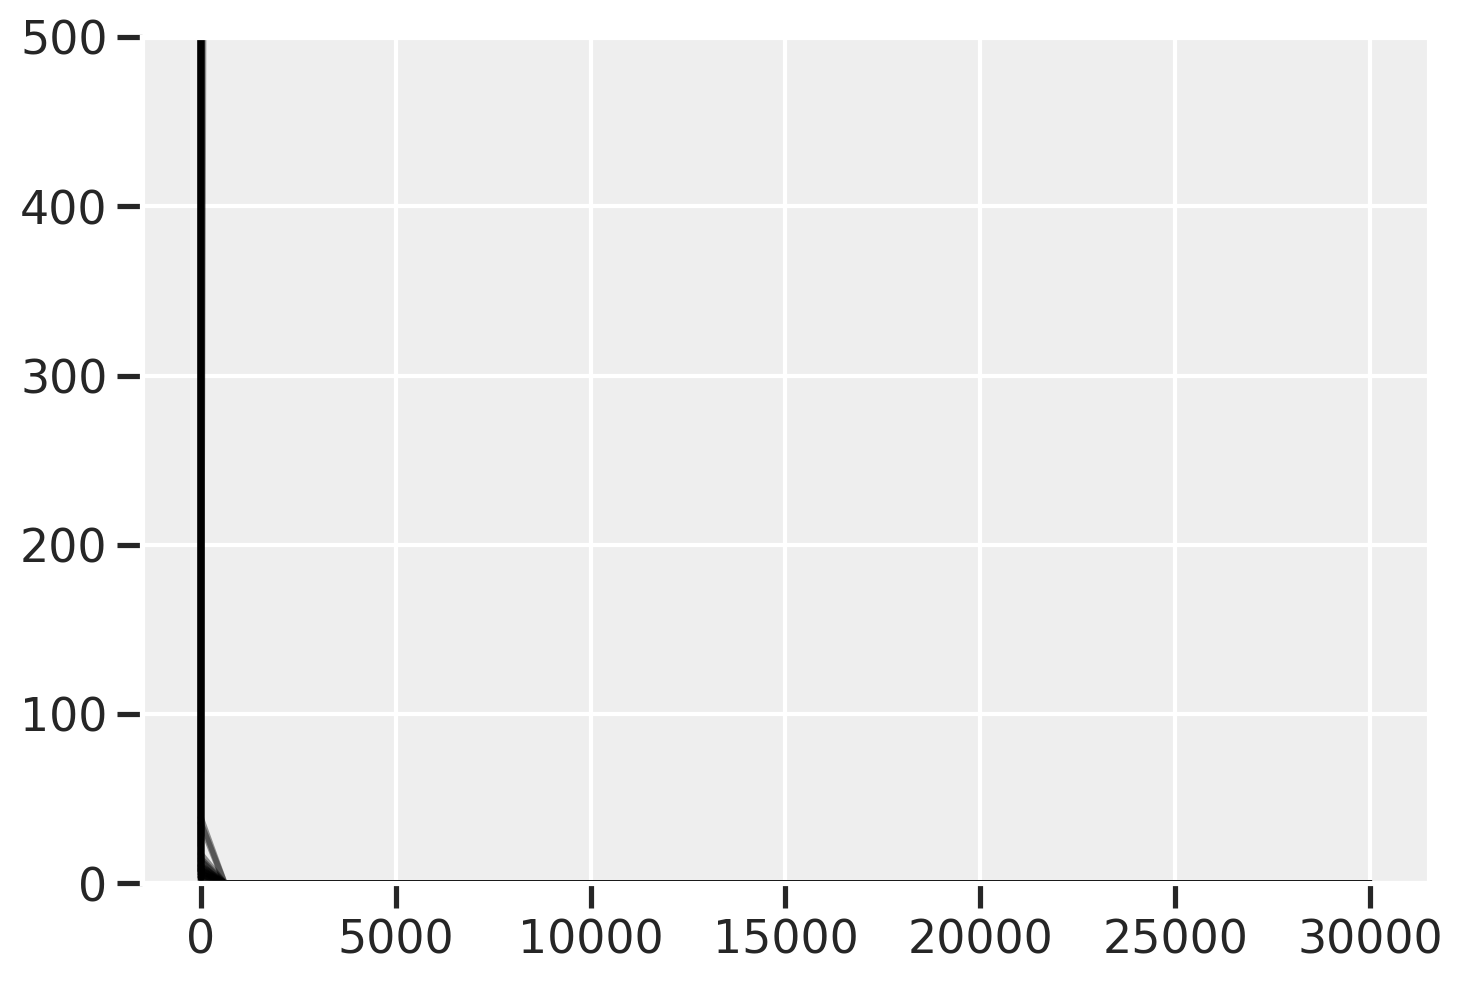

<IPython.core.display.Javascript object>

In [170]:
f, ax1 = plt.subplots()
for a, b in zip(alphas, betas):
    ax1.plot(xrange, np.exp(a + b * xrange), "k", alpha=0.4)

# Limiting
ax1.set_ylim(0, 500)

I get an overflow warning. This is a rationale for using logs.

#### Multiplying by log x

In [174]:
# Plot 50 lines over the range of (0, 30000) characters
N = 50
xrange_log = np.log(np.linspace(1, 30_000, N))
xrange_log

array([ 0.        ,  6.41873108,  7.11106257,  7.51625563,  7.80380165,
        8.02686357,  8.20913069,  8.36324249,  8.49674472,  8.61450508,
        8.71984745,  8.81514278,  8.90214178,  8.98217402,  9.05627302,
        9.12525812,  9.18978983,  9.25040845,  9.30756153,  9.36162397,
        9.41291297,  9.46169924,  9.50821572,  9.55266426,  9.59522091,
        9.63604019,  9.67525839,  9.71299639,  9.74936187,  9.78445118,
        9.81835086,  9.85113892,  9.88288597,  9.91365609,  9.94350759,
        9.97249376, 10.00066334, 10.02806109, 10.05472817, 10.08070256,
       10.10601932, 10.13071093, 10.15480754, 10.17833713, 10.20132578,
       10.22379782, 10.24577593, 10.26728138, 10.28833407, 10.30895266])

<IPython.core.display.Javascript object>

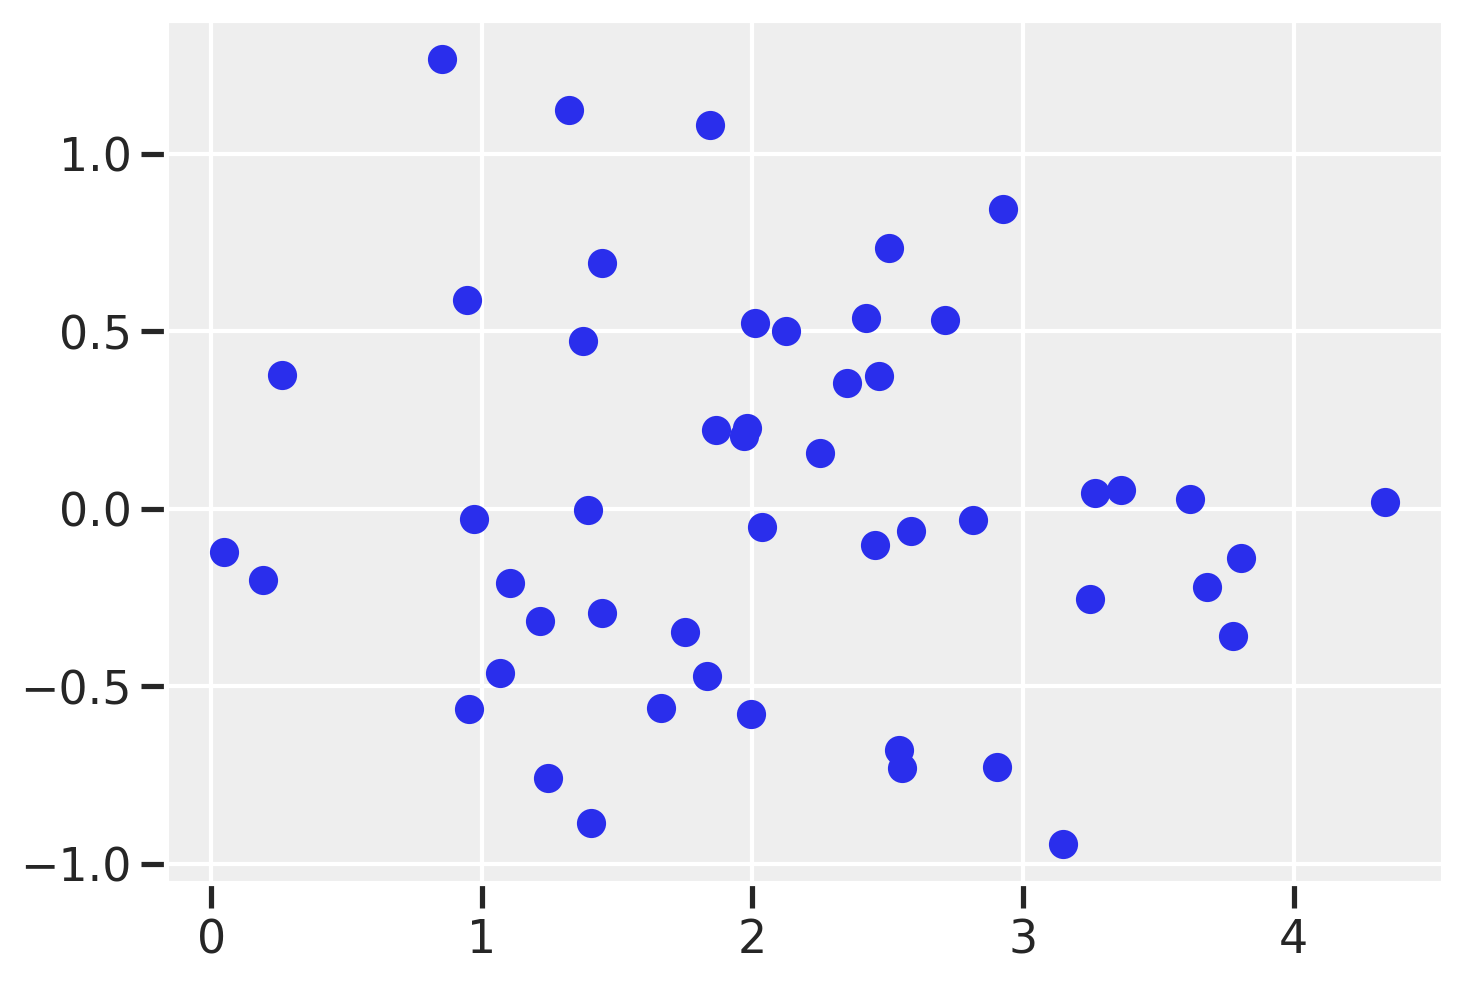

<IPython.core.display.Javascript object>

In [160]:
# Look at the sampling space of parameters
plt.scatter(alphas, betas)

[Text(0.5, 0, 'log number of characters'),
 Text(0.5, 1.0, 'Prior predictions\nalpha ~ N(2,1), beta ~ N(0,0.5)')]

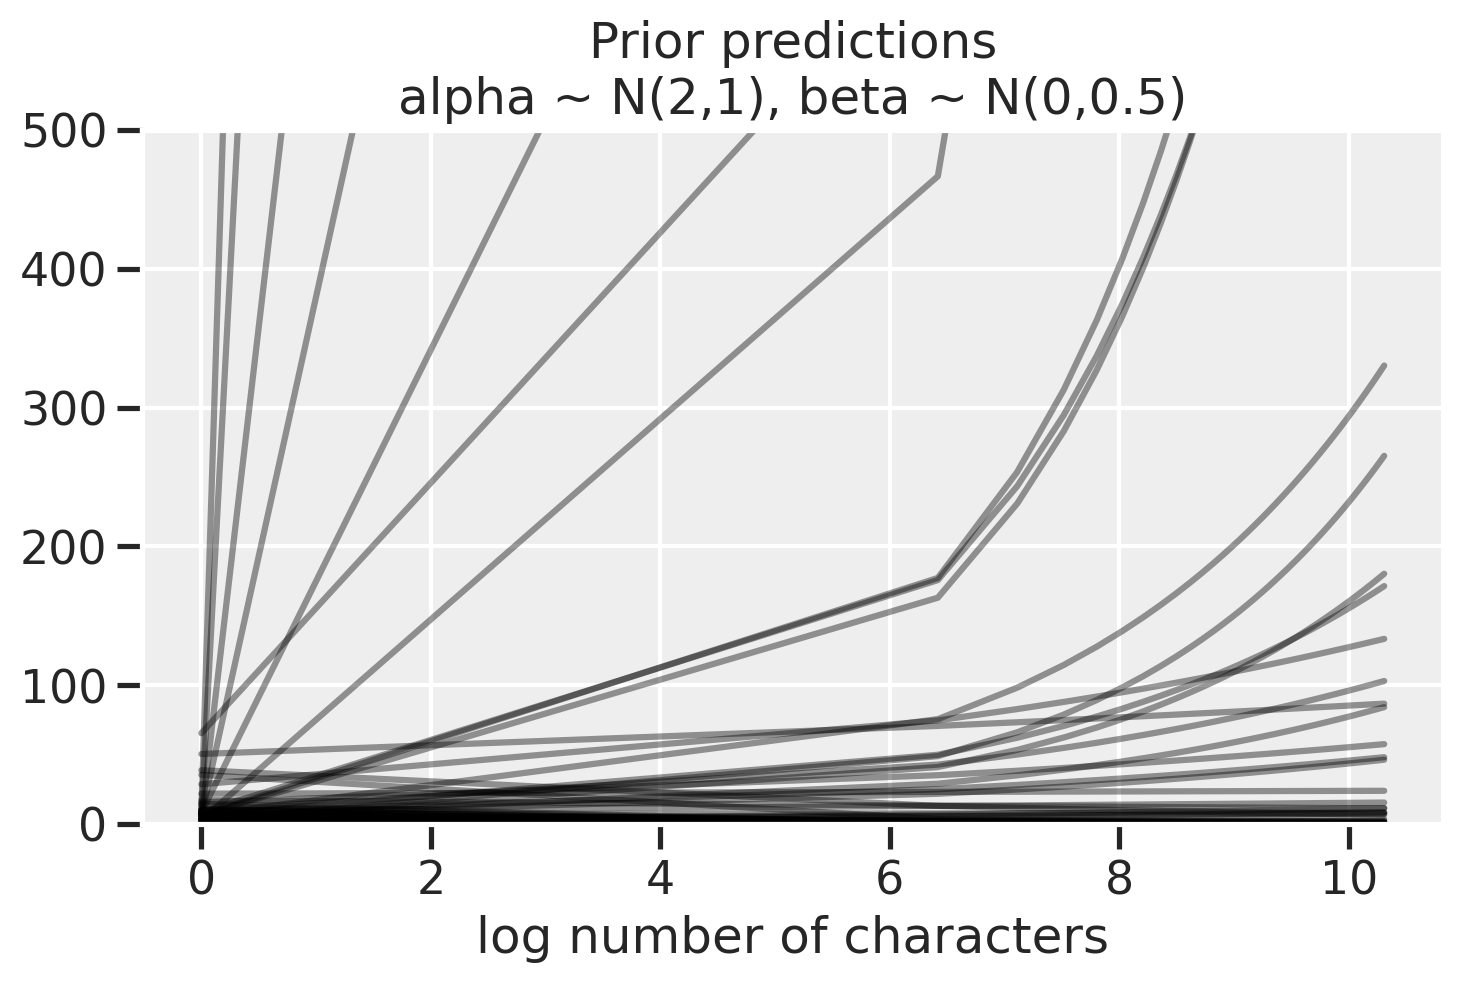

<IPython.core.display.Javascript object>

In [177]:
f, ax1 = plt.subplots()
for a, b in zip(alphas, betas):
    ax1.plot(xrange_log, np.exp(a + b * xrange_log), "k", alpha=0.4)

# It's necessary to limit the y-axis for visualization
ax1.set_ylim(0, 500)
ax1.set(
    xlabel="log number of characters",
    title="Prior predictions\nalpha ~ N(2,1), beta ~ N(0,0.5)",
)

#### Sidebar (start): Why is there a kink in the curve?

Is it a bigger range? Let's try a larger upper value as the tools example had. 

In [187]:
N = 50
x_seq = np.linspace(np.log(100), np.log(200_000), N)
x_seq

array([ 4.60517019,  4.76029064,  4.9154111 ,  5.07053156,  5.22565202,
        5.38077248,  5.53589294,  5.69101339,  5.84613385,  6.00125431,
        6.15637477,  6.31149523,  6.46661569,  6.62173614,  6.7768566 ,
        6.93197706,  7.08709752,  7.24221798,  7.39733844,  7.55245889,
        7.70757935,  7.86269981,  8.01782027,  8.17294073,  8.32806119,
        8.48318164,  8.6383021 ,  8.79342256,  8.94854302,  9.10366348,
        9.25878394,  9.4139044 ,  9.56902485,  9.72414531,  9.87926577,
       10.03438623, 10.18950669, 10.34462715, 10.4997476 , 10.65486806,
       10.80998852, 10.96510898, 11.12022944, 11.2753499 , 11.43047035,
       11.58559081, 11.74071127, 11.89583173, 12.05095219, 12.20607265])

<IPython.core.display.Javascript object>

Text(0, 0.5, 'total tools')

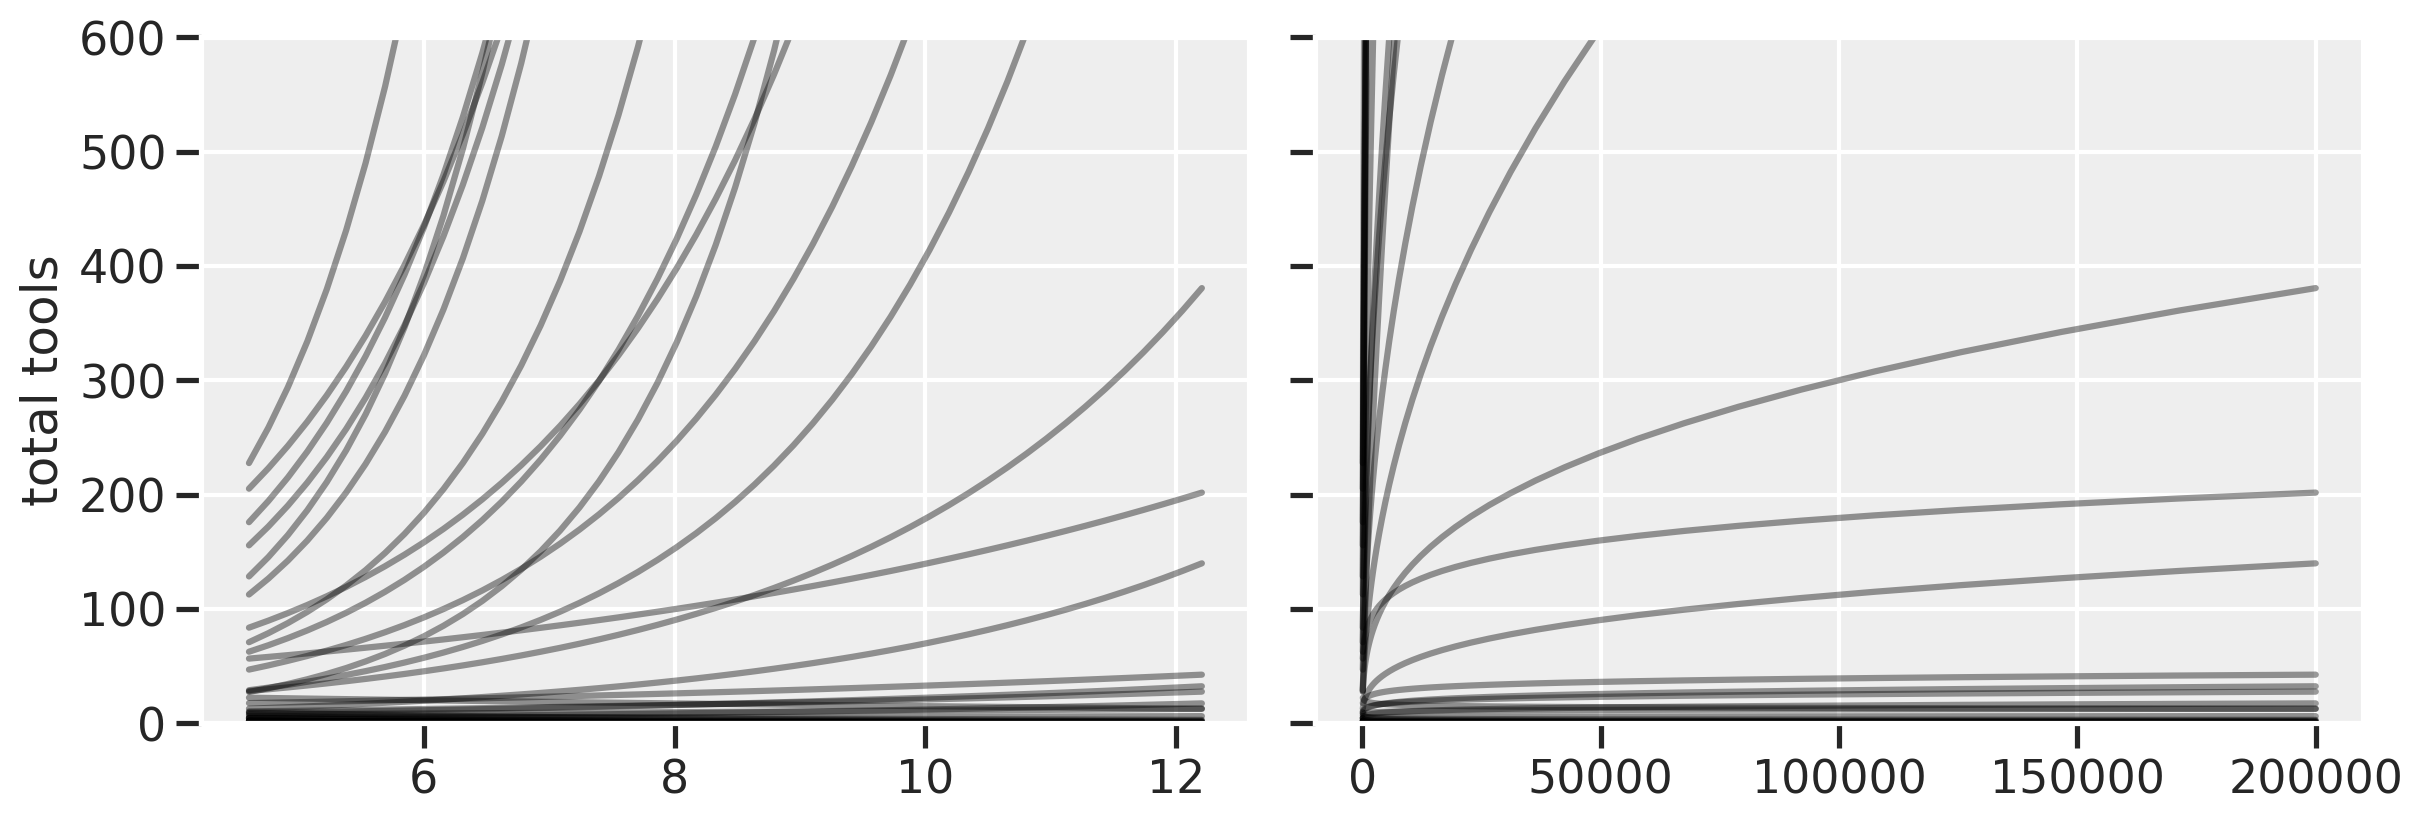

<IPython.core.display.Javascript object>

In [207]:
alphas = pm.Normal.dist(2, 1).random(size=N)
betas = pm.Normal.dist(0, 0.5).random(size=N)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
for a, b in zip(alphas, betas):
    # Plot with xaxis (population) on log scale
    ax1.plot(x_seq, np.exp(a + b * x_seq), "k", alpha=0.4)
    # Plot with xaxis (population) on natural scale
    ax2.plot(np.exp(x_seq), np.exp(a + b * x_seq), "k", alpha=0.4)

# It's necessary to limit the y-axis for decent interpretability
ax1.set_ylim(0, 600)
ax1.set_ylabel("total tools")



Let's try a lower lower bound.

In [208]:
N = 50
x_seq = np.linspace(np.log(1), np.log(200_000), N)
x_seq

array([ 0.        ,  0.24910352,  0.49820705,  0.74731057,  0.99641409,
        1.24551762,  1.49462114,  1.74372466,  1.99282819,  2.24193171,
        2.49103523,  2.74013876,  2.98924228,  3.2383458 ,  3.48744933,
        3.73655285,  3.98565637,  4.2347599 ,  4.48386342,  4.73296694,
        4.98207047,  5.23117399,  5.48027751,  5.72938104,  5.97848456,
        6.22758808,  6.47669161,  6.72579513,  6.97489865,  7.22400218,
        7.4731057 ,  7.72220922,  7.97131275,  8.22041627,  8.46951979,
        8.71862332,  8.96772684,  9.21683036,  9.46593389,  9.71503741,
        9.96414094, 10.21324446, 10.46234798, 10.71145151, 10.96055503,
       11.20965855, 11.45876208, 11.7078656 , 11.95696912, 12.20607265])

<IPython.core.display.Javascript object>

Text(0, 0.5, 'total tools')

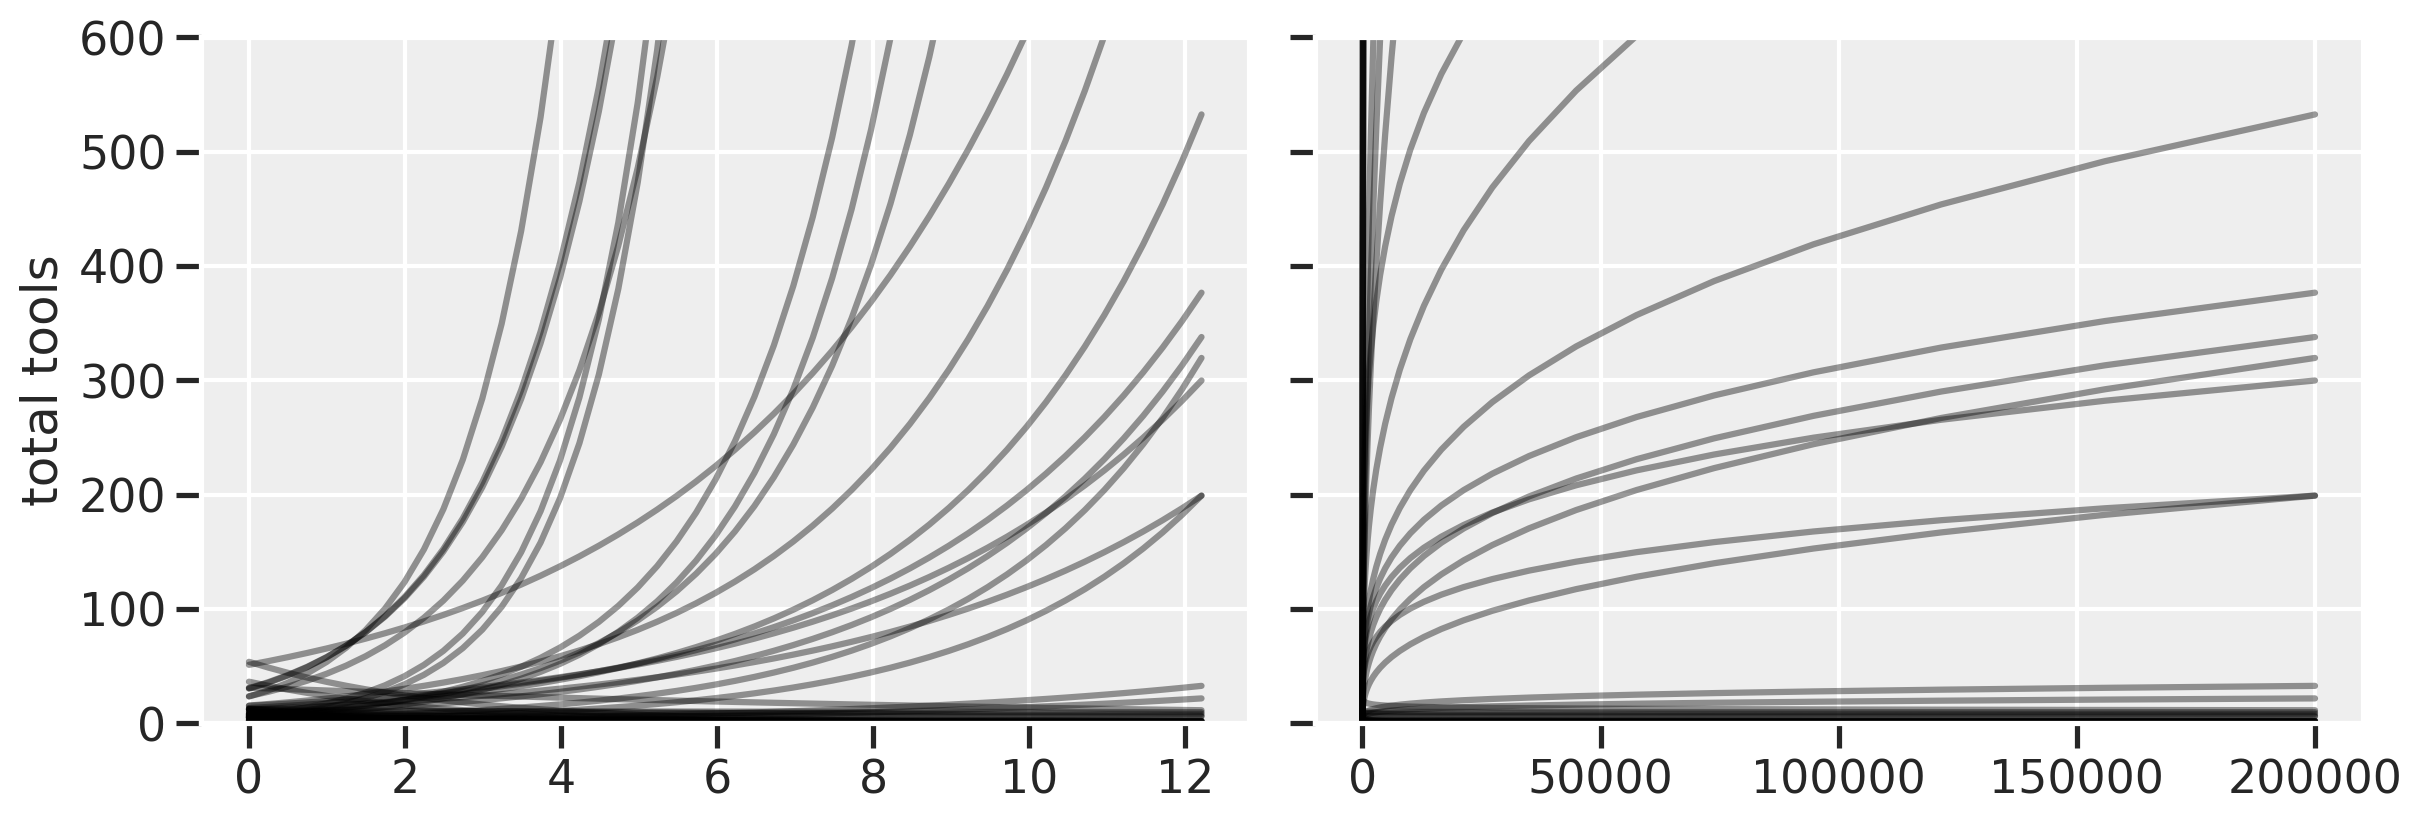

<IPython.core.display.Javascript object>

In [209]:
alphas = pm.Normal.dist(2, 1).random(size=N)
betas = pm.Normal.dist(0, 0.5).random(size=N)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
for a, b in zip(alphas, betas):
    # Plot with xaxis (population) on log scale
    ax1.plot(x_seq, np.exp(a + b * x_seq), "k", alpha=0.4)
    # Plot with xaxis (population) on natural scale
    ax2.plot(np.exp(x_seq), np.exp(a + b * x_seq), "k", alpha=0.4)

# It's necessary to limit the y-axis for decent interpretability
ax1.set_ylim(0, 600)
ax1.set_ylabel("total tools")



It is probably the way the log values are coded.

My instantiation:
```
xrange_log = np.log(np.linspace(1, 30_000, N))
```

Repo instantiation:

```
x_seq = np.linspace(np.log(100), np.log(200_000), N)
```

Let's try revising the `xrange_log` variable. This fixed it.

#### Sidebar (end)

### Using log(x)

In [212]:
# Plot 50 lines over the range of (0, 30000) characters, using log the repo way
N = 50
xrange_log = np.linspace(np.log(1), np.log(30_000), N)
xrange_log

array([ 0.        ,  0.21038679,  0.42077358,  0.63116037,  0.84154716,
        1.05193394,  1.26232073,  1.47270752,  1.68309431,  1.8934811 ,
        2.10386789,  2.31425468,  2.52464147,  2.73502826,  2.94541505,
        3.15580183,  3.36618862,  3.57657541,  3.7869622 ,  3.99734899,
        4.20773578,  4.41812257,  4.62850936,  4.83889615,  5.04928294,
        5.25966972,  5.47005651,  5.6804433 ,  5.89083009,  6.10121688,
        6.31160367,  6.52199046,  6.73237725,  6.94276404,  7.15315083,
        7.36353761,  7.5739244 ,  7.78431119,  7.99469798,  8.20508477,
        8.41547156,  8.62585835,  8.83624514,  9.04663193,  9.25701872,
        9.4674055 ,  9.67779229,  9.88817908, 10.09856587, 10.30895266])

<IPython.core.display.Javascript object>

Text(0, 0.5, 'total tags')

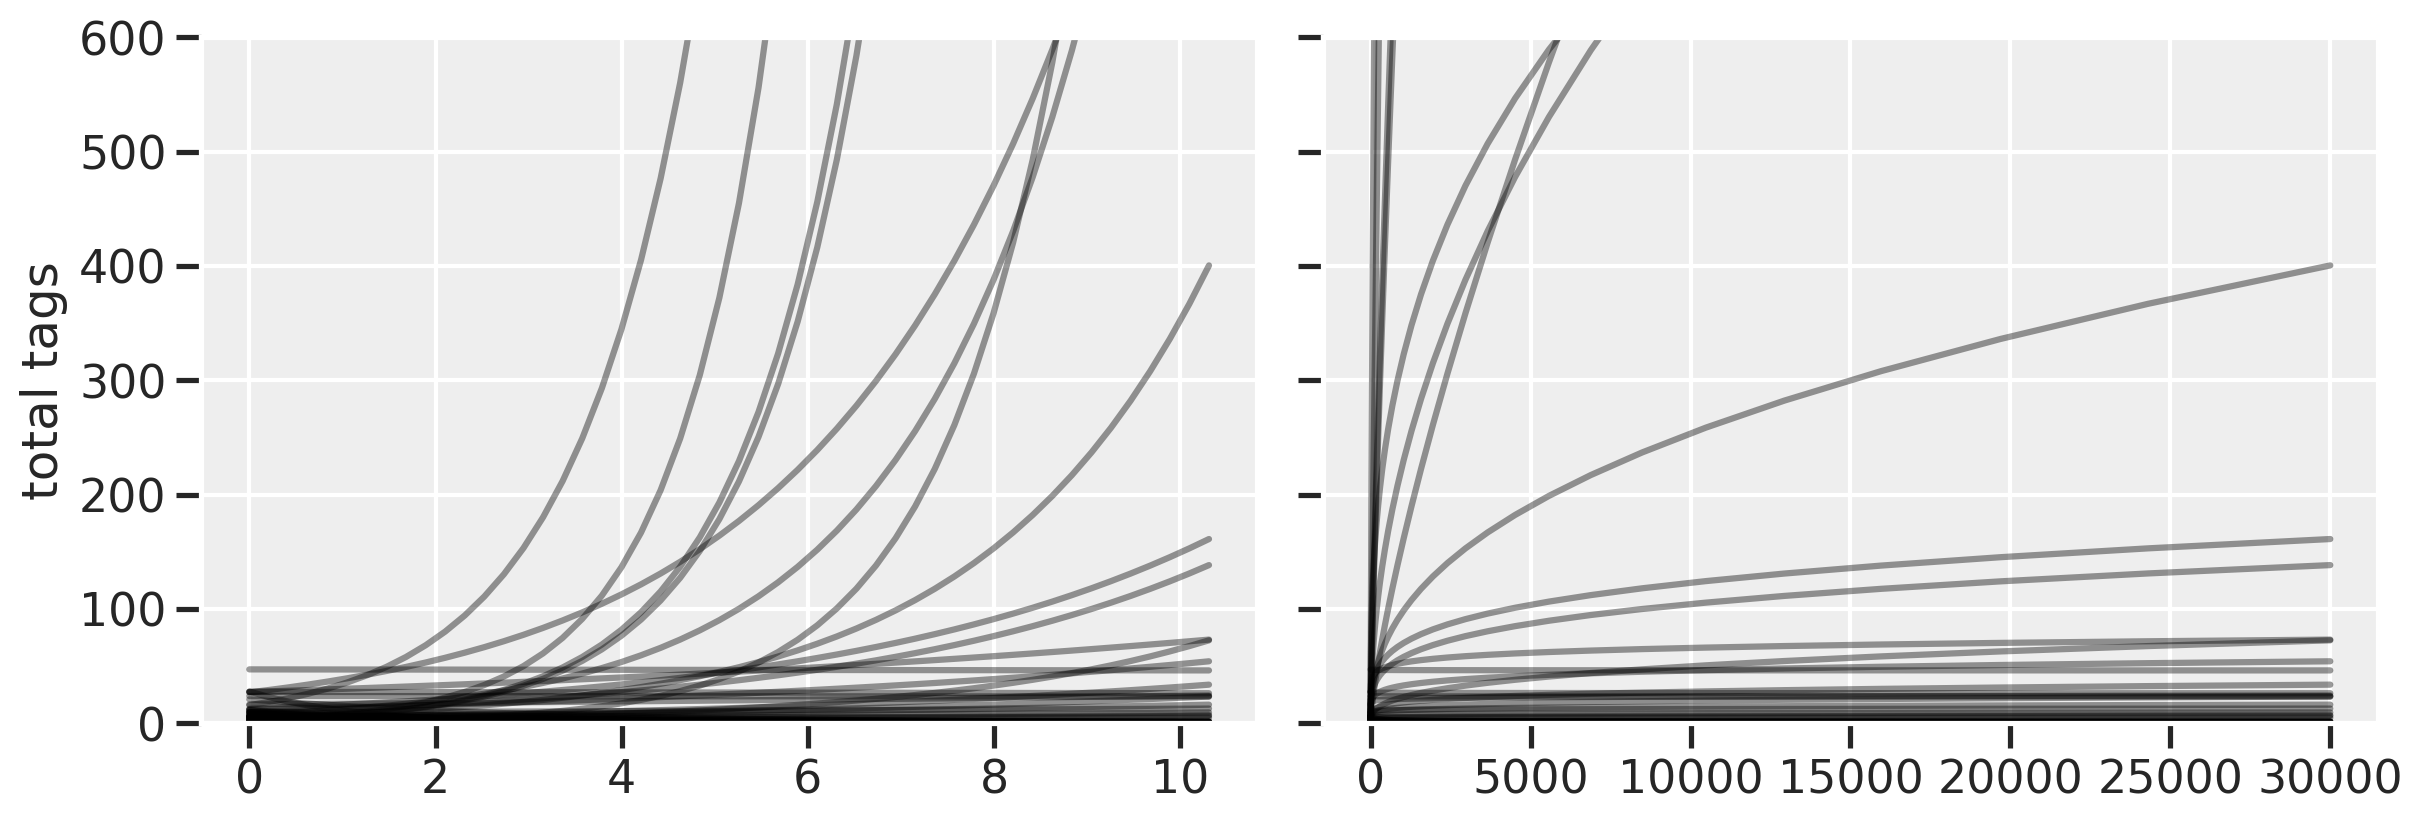

<IPython.core.display.Javascript object>

In [215]:
alphas = pm.Normal.dist(2, 1).random(size=N)
betas = pm.Normal.dist(0, 0.5).random(size=N)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
for a, b in zip(alphas, betas):
    # Plot with xaxis (population) on log scale
    ax1.plot(xrange_log, np.exp(a + b * xrange_log), "k", alpha=0.4)
    # Plot with xaxis (population) on natural scale
    ax2.plot(np.exp(xrange_log), np.exp(a + b * xrange_log), "k", alpha=0.4)

# It's necessary to limit the y-axis for decent interpretability
ax1.set_ylim(0, 600)
ax1.set_ylabel("total tags")

It seems like this implies that the number of tags can get pretty big. Let's try a couple more tighter values on beta.

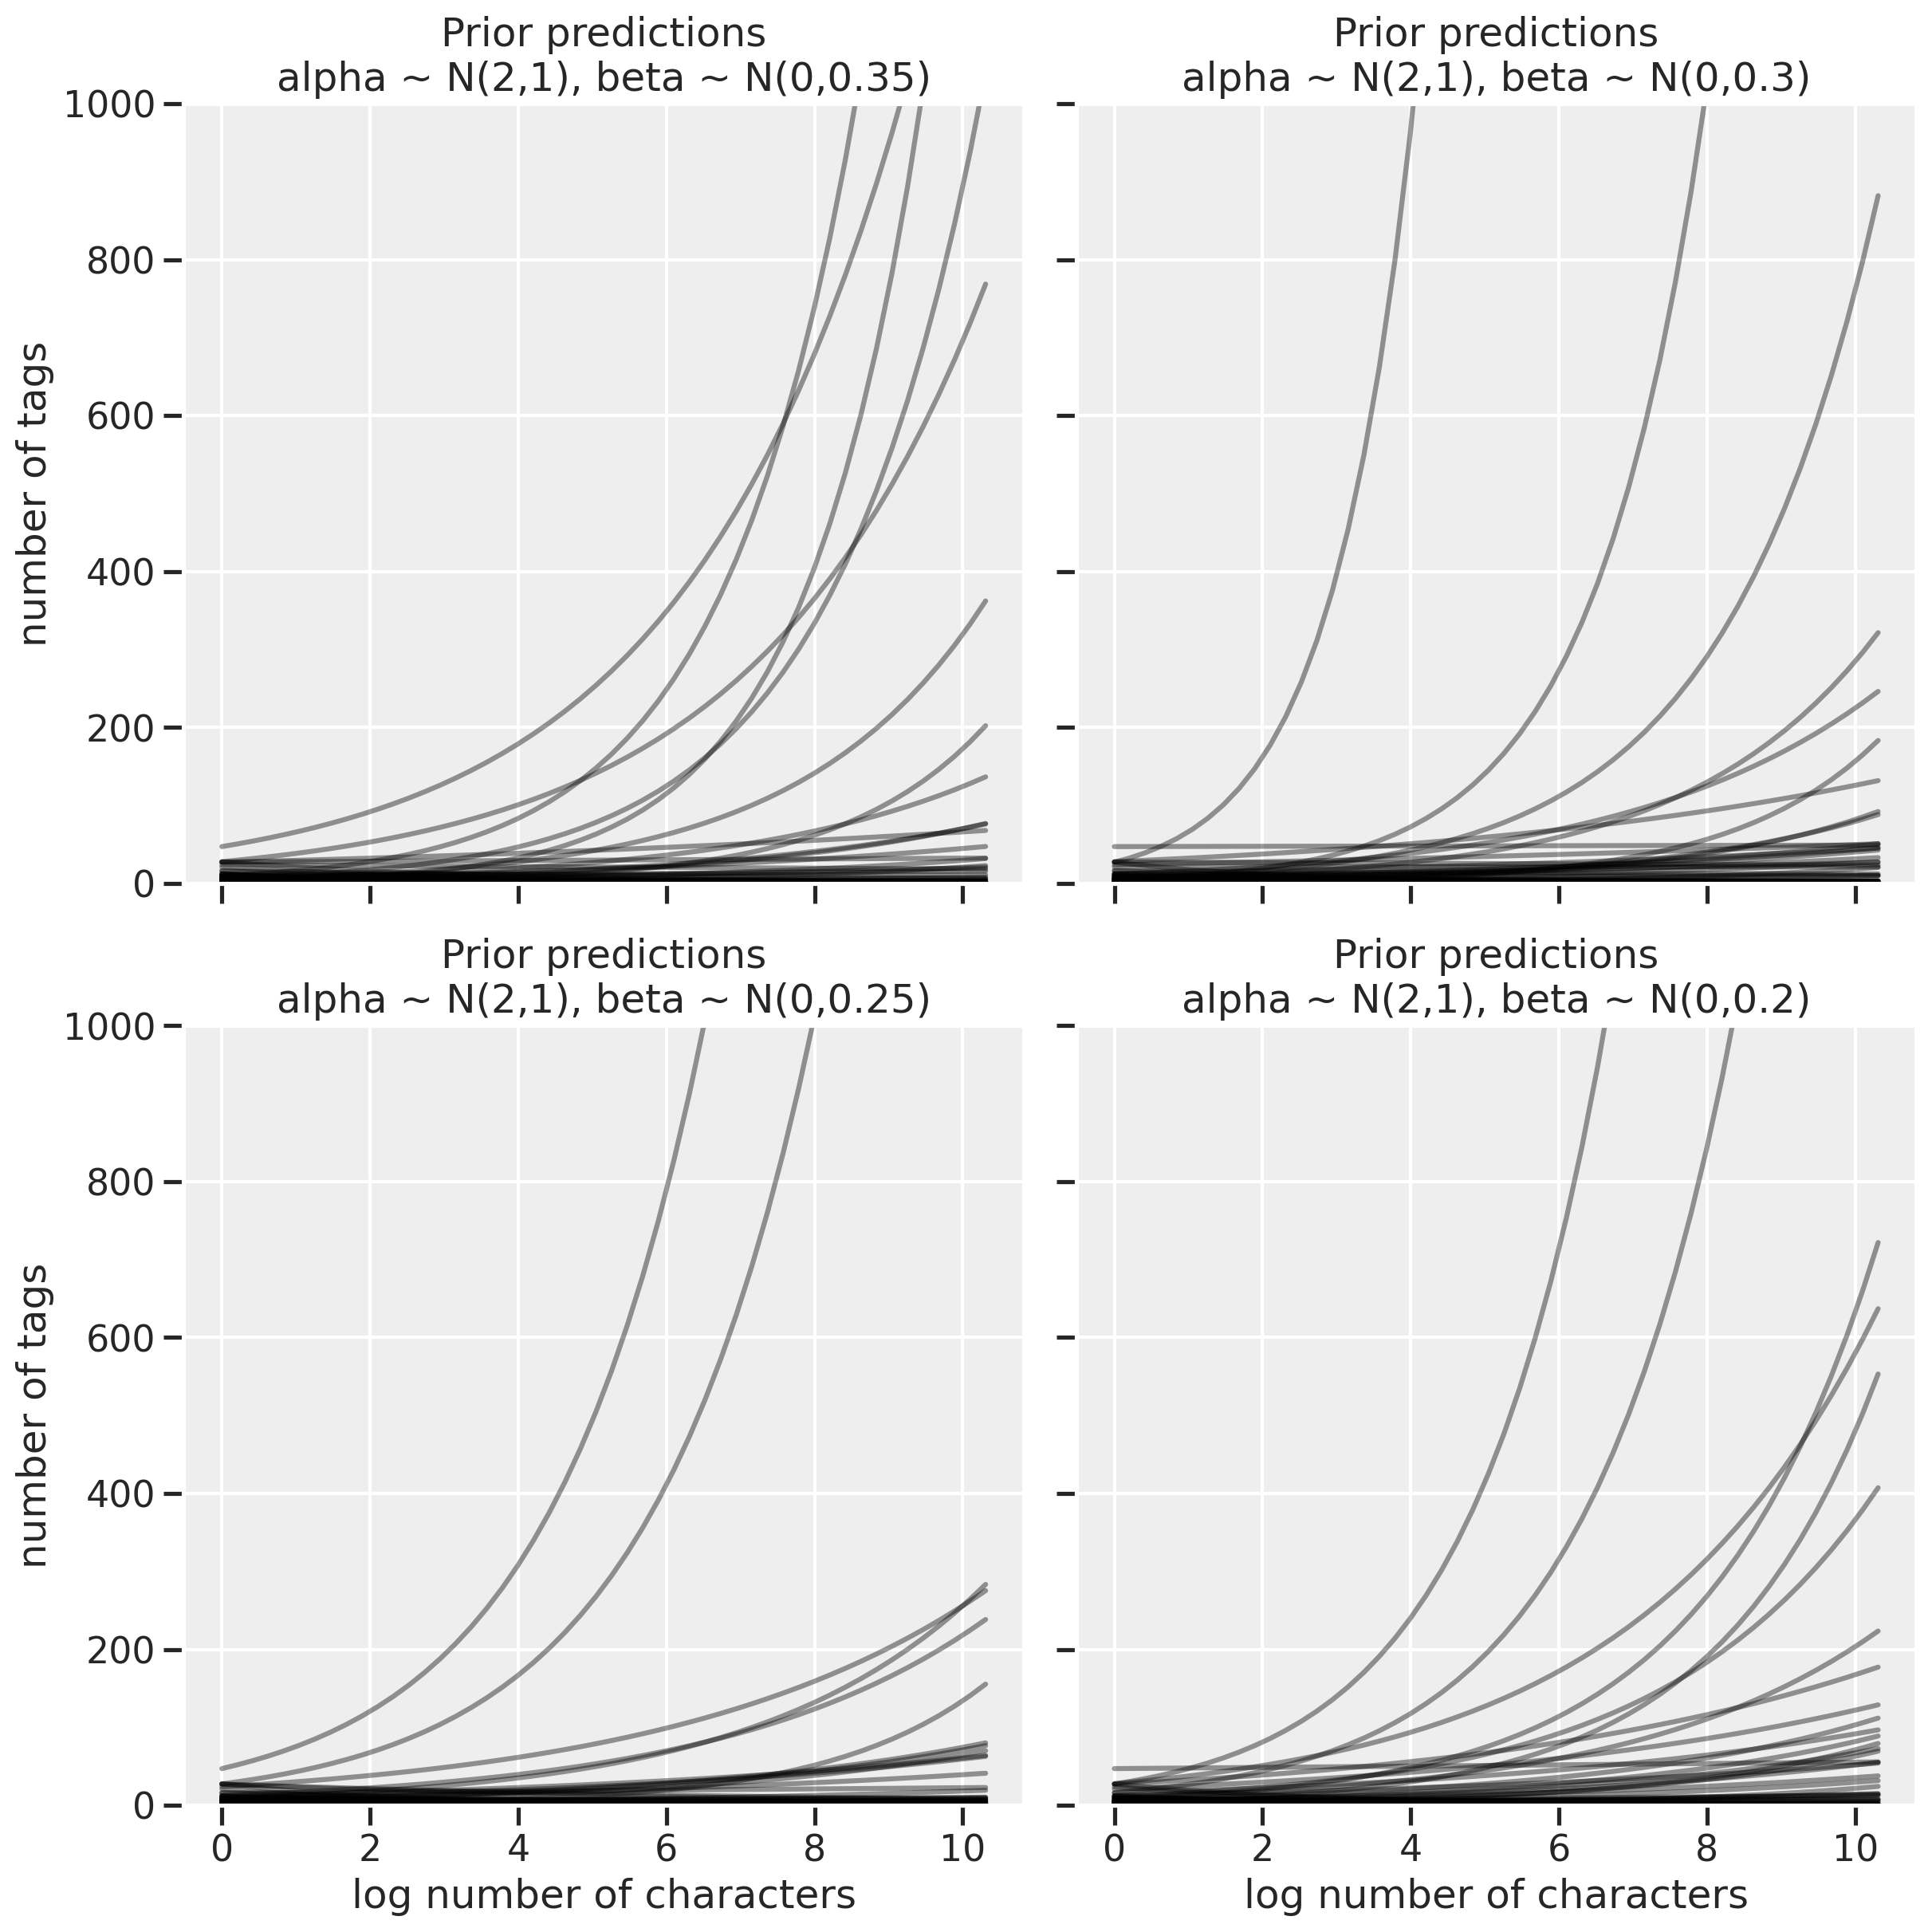

<IPython.core.display.Javascript object>

In [231]:
# Plot 50 lines over the range of (0, 30000) characters

# beta values
betas_scale_list = [0.35, 0.30, 0.25, 0.20]

f, axes = plt.subplots(2, 2, figsize=(12, 12), sharex=True, sharey=True)

for b_scale, ax in zip(betas_scale_list, axes.flat):

    betas = pm.Normal.dist(0, b_scale).random(size=N)

    for a, b in zip(alphas, betas):
        ax.plot(xrange_log, np.exp(a + b * xrange_log), "k", alpha=0.4)

        # It's necessary to limit the y-axis for visualization
        ax.set_ylim(0, 1000)
        ax.set_title(f"Prior predictions\nalpha ~ N(2,1), beta ~ N(0,{b_scale})")

        if ax.is_first_col():

            ax.set(
                ylabel="number of tags",
            )

        if ax.is_last_row():
            ax.set(
                xlabel="log number of characters",
            )

Plot on natural scale.

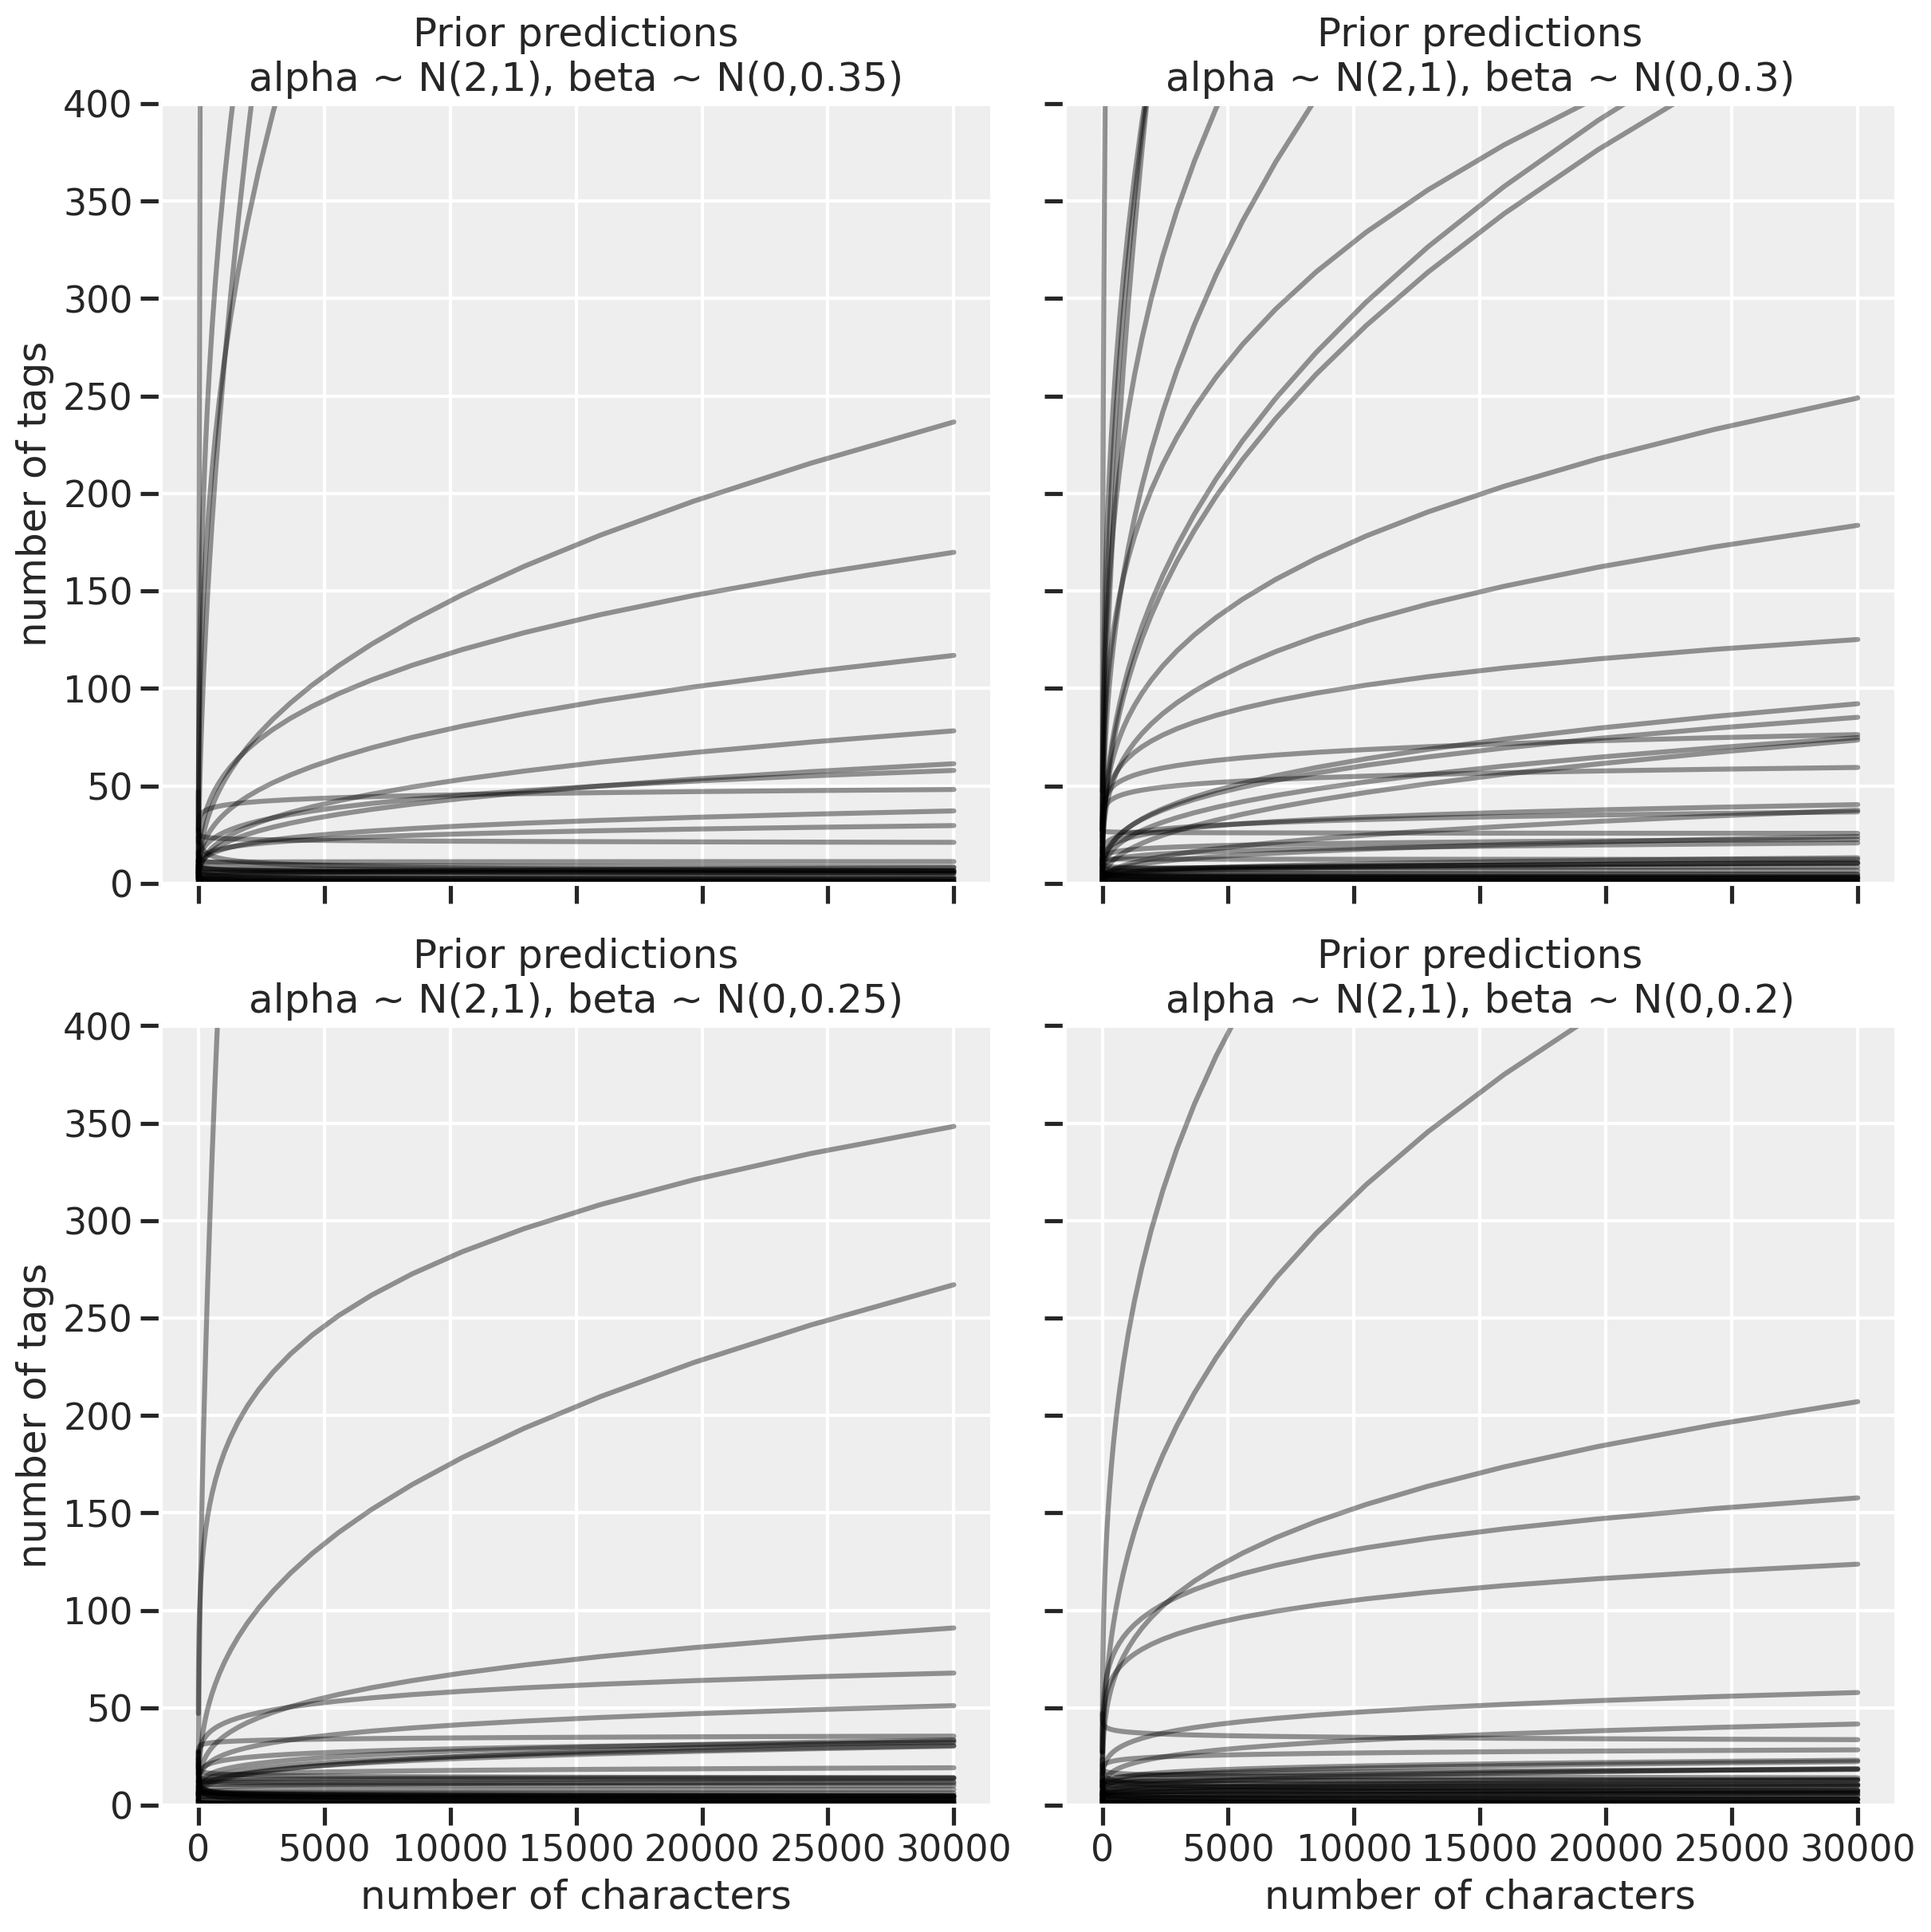

<IPython.core.display.Javascript object>

In [234]:
# Plot 50 lines over the range of (0, 30000) characters

# beta values
betas_scale_list = [0.35, 0.30, 0.25, 0.20]

f, axes = plt.subplots(2, 2, figsize=(12, 12), sharex=True, sharey=True)

for b_scale, ax in zip(betas_scale_list, axes.flat):

    betas = pm.Normal.dist(0, b_scale).random(size=N)

    for a, b in zip(alphas, betas):
        ax.plot(np.exp(xrange_log), np.exp(a + b * xrange_log), "k", alpha=0.4)

        # It's necessary to limit the y-axis for visualization
        ax.set_ylim(0, 400)
        ax.set_title(f"Prior predictions\nalpha ~ N(2,1), beta ~ N(0,{b_scale})")

        if ax.is_first_col():

            ax.set(
                ylabel="number of tags",
            )

        if ax.is_last_row():
            ax.set(
                xlabel="number of characters",
            )

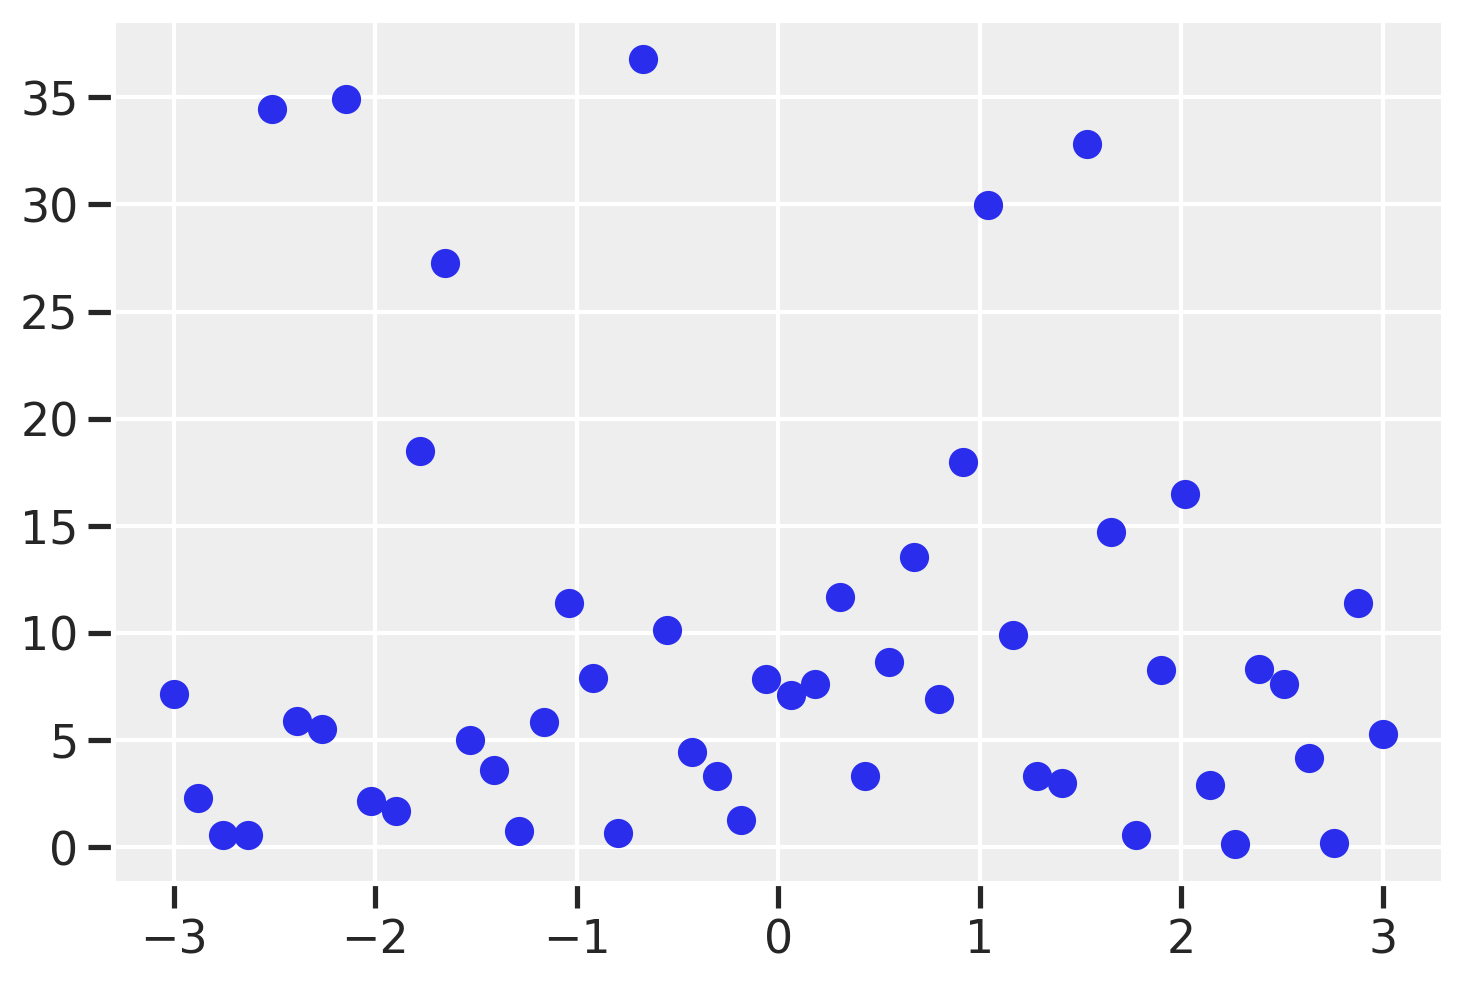

<IPython.core.display.Javascript object>

In [162]:
a = pm.Normal.dist(2, 1).random(size=N)
b = pm.Normal.dist(0, 0.5).random(size=N)
std_vals = np.linspace(-3, 3, 50)

plt.scatter(std_vals, np.exp(a + b * std_vals))

I'll do `alpha ~ N(2,1), beta ~ N(0,0.2)`.

### Make a model

Now, let's prepare the dataframe for poisson GLM. We will need to generate `log_n_chars_note` and standardize. We already have the `note_type` index variable in `note_type_code`.

In [245]:
# Need the float to use log
df_srfs_counts["log_n_chars_note"] = np.log(df_srfs_counts["n_chars_note"].astype("float"))
df_srfs_counts["log_n_chars_note_std"] = standardize(df_srfs_counts["log_n_chars_note"])

<IPython.core.display.Javascript object>

In [246]:
df_srfs_counts.head()

note_type                file  n_tags n_chars_note  note_type_code  \
0  ED_Provider_Notes  646702875_Matt.xml    10.0         8644               0   
1  ED_Provider_Notes  742238643_Matt.xml     4.0         8122               0   
2  ED_Provider_Notes  658813952_Matt.xml     9.0         6672               0   
3  ED_Provider_Notes  650368122_Matt.xml    20.0        15323               0   
4  ED_Provider_Notes  705769932_Matt.xml    15.0         7870               0   

   n_chars_note_std  log_n_chars_note  log_n_chars_note_std  
0          1.194551          9.064621              1.111547  
1          1.069144          9.002332              1.072053  
2          0.720790          8.805675              0.947364  
3          2.799138          9.637110              1.474532  
4          1.008602          8.970813              1.052069

<IPython.core.display.Javascript object>

In [247]:
len(df_srfs_counts["note_type"].unique())

5

<IPython.core.display.Javascript object>

In [248]:
with pm.Model() as m_beta1:
    # Priors chosen from above
    # shape=5 since we have 5 unique note types
    a = pm.Normal("a", 2, 1, shape=5)
    b = pm.Normal("b", 0, 0.5, shape=5)

    # The link function
    # Note how we use `pm.math.exp` to get lambda
    lam = pm.Deterministic(
        "lam",
        pm.math.exp(
            a[df_srfs_counts["note_type_code"]]
            + b[df_srfs_counts["note_type_code"]]
            * df_srfs_counts["log_n_chars_note_std"]
        ),
    )

    # Likelihood,
    t = pm.Poisson("t", mu=lam, observed=df_srfs_counts["n_tags"])

    trace_m_beta1 = pm.sample(1000, tune=1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a]
INFO:pymc3:NUTS: [b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.


<IPython.core.display.Javascript object>

In [252]:
az.summary(trace_m_beta1, var_names=["a", "b"])

mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
a[0] -0.456  0.188    -0.767     -0.170      0.004    0.003    2235.0  2151.0   
a[1]  0.277  0.115     0.102      0.471      0.002    0.002    2679.0  2644.0   
a[2] -2.658  0.221    -3.002     -2.292      0.004    0.003    3947.0  3876.0   
a[3] -1.791  0.117    -1.981     -1.613      0.002    0.002    2751.0  2751.0   
a[4] -0.532  0.106    -0.707     -0.369      0.002    0.001    4486.0  4299.0   
b[0]  1.952  0.155     1.713      2.205      0.003    0.002    2217.0  2217.0   
b[1]  1.404  0.097     1.229      1.543      0.002    0.001    2627.0  2622.0   
b[2]  0.442  0.247     0.043      0.832      0.004    0.003    4188.0  3907.0   
b[3]  2.892  0.100     2.731      3.049      0.002    0.001    2796.0  2796.0   
b[4]  1.513  0.141     1.298      1.747      0.002    0.002    4042.0  4027.0   

      ess_bulk  ess_tail  r_hat  
a[0]    2216.0    2301.0    1.0  
a[1]    2680.0    2586.0    1.0  
a[2]    4002.0    3160.0    1.0  
a[3]    2743.0    2618.0    1.0  
a[4]    4510.0    2965.0    1.0  
b[0]    2227.0    2371.0    1.0  
b[1]    2624.0    2670.0    1.0  
b[2]    4194.0    3139.0    1.0  
b[3]    2797.0    2593.0    1.0  
b[4]    4047.0    3253.0    1.0

<IPython.core.display.Javascript object>

Text(0.5, 0.98, 'Alpha, beta parameter estimation')

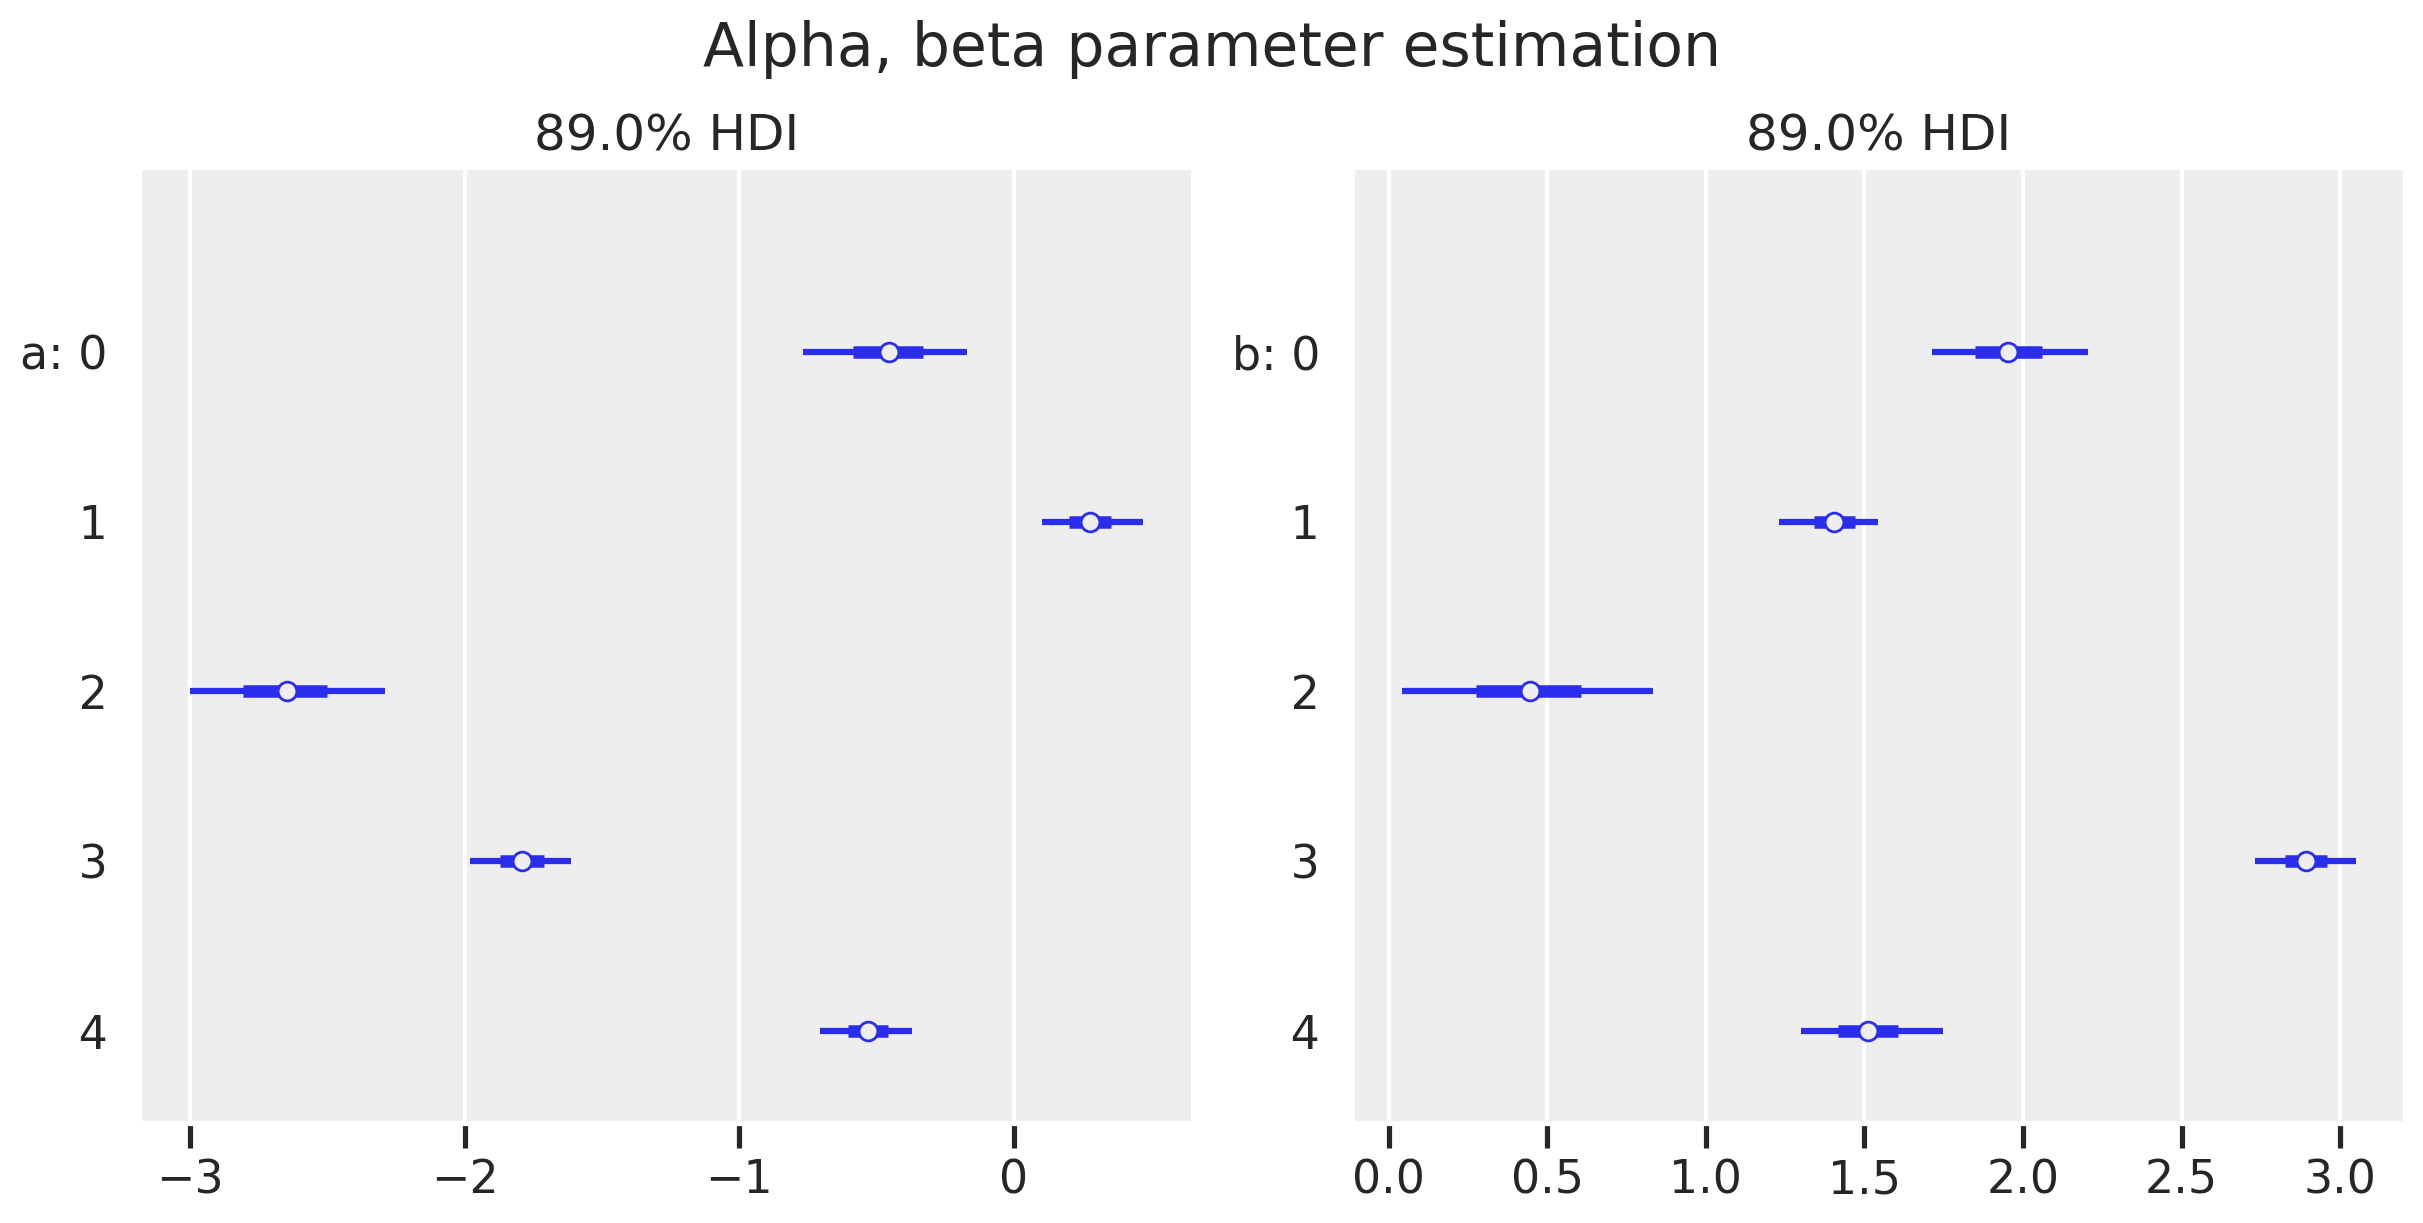

<IPython.core.display.Javascript object>

In [259]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
az.plot_forest(trace_m_beta1, var_names=["a"], combined=True, ax=ax1)
az.plot_forest(trace_m_beta1, var_names=["b"], combined=True, ax=ax2)

f.suptitle("Alpha, beta parameter estimation")

In [258]:
# Verification that code assignment is alphabetical order
df_srfs_counts[["note_type", "note_type_code"]].drop_duplicates()

note_type  note_type_code
0        ED_Provider_Notes               0
102                    H&P               1
433   Patient_Instructions               2
819         Progress_Notes               3
1205   Telephone_Encounter               4

<IPython.core.display.Javascript object>

In [260]:
trace_m_beta1_df = trace_m_beta1.to_dataframe()
trace_m_beta1_df.head()

chain  draw  (posterior, a[0], 0)  (posterior, a[1], 1)  \
0      0     0             -0.803798              0.325547   
1      0     1             -0.814175              0.312381   
2      0     2             -0.684421              0.132703   
3      0     3             -0.305312              0.180168   
4      0     4             -0.501072              0.452883   

   (posterior, a[2], 2)  (posterior, a[3], 3)  (posterior, a[4], 4)  \
0             -2.728575             -1.610794             -0.552312   
1             -2.679567             -1.634851             -0.590796   
2             -2.641535             -1.781502             -0.545275   
3             -2.674236             -1.869422             -0.548010   
4             -2.418310             -1.901019             -0.514589   

   (posterior, b[0], 0)  (posterior, b[1], 1)  (posterior, b[2], 2)  ...  \
0              2.241797              1.370514              0.357684  ...   
1              2.208132              1.375687              0.392232  ...   
2              2.165182              1.510246              0.536995  ...   
3              1.847792              1.490672              0.295733  ...   
4              1.979272              1.217668              0.439479  ...   

   (sample_stats, perf_counter_diff)  (sample_stats, lp)  \
0                           0.005488        -1950.669674   
1                           0.003461        -1951.247755   
2                           0.003260        -1950.661969   
3                           0.004619        -1948.751393   
4                           0.002840        -1952.092816   

   (sample_stats, tree_size)  (sample_stats, step_size)  \
0                       31.0                   0.249705   
1                       15.0                   0.249705   
2                       15.0                   0.249705   
3                       31.0                   0.249705   
4                       15.0                   0.249705   

   (sample_stats, depth)  (sample_stats, energy)  \
0                      5             1954.564571   
1                      4             1953.677023   
2                      4             1958.466279   
3                      5             1953.529716   
4                      4             1957.222366   

   (sample_stats, process_time_diff)  (sample_stats, energy_error)  \
0                           0.005476                     -0.549046   
1                           0.003461                      0.265112   
2                           0.003242                      0.378505   
3                           0.004619                     -0.455193   
4                           0.002790                      1.614577   

   (sample_stats, diverging)  (sample_stats, step_size_bar)  
0                      False                       0.213189  
1                      False                       0.213189  
2                      False                       0.213189  
3                      False                       0.213189  
4                      False                       0.213189  

[5 rows x 3179 columns]

<IPython.core.display.Javascript object>

#### Old notes (start)

Text(0.5, 0.98, 'number of characters')

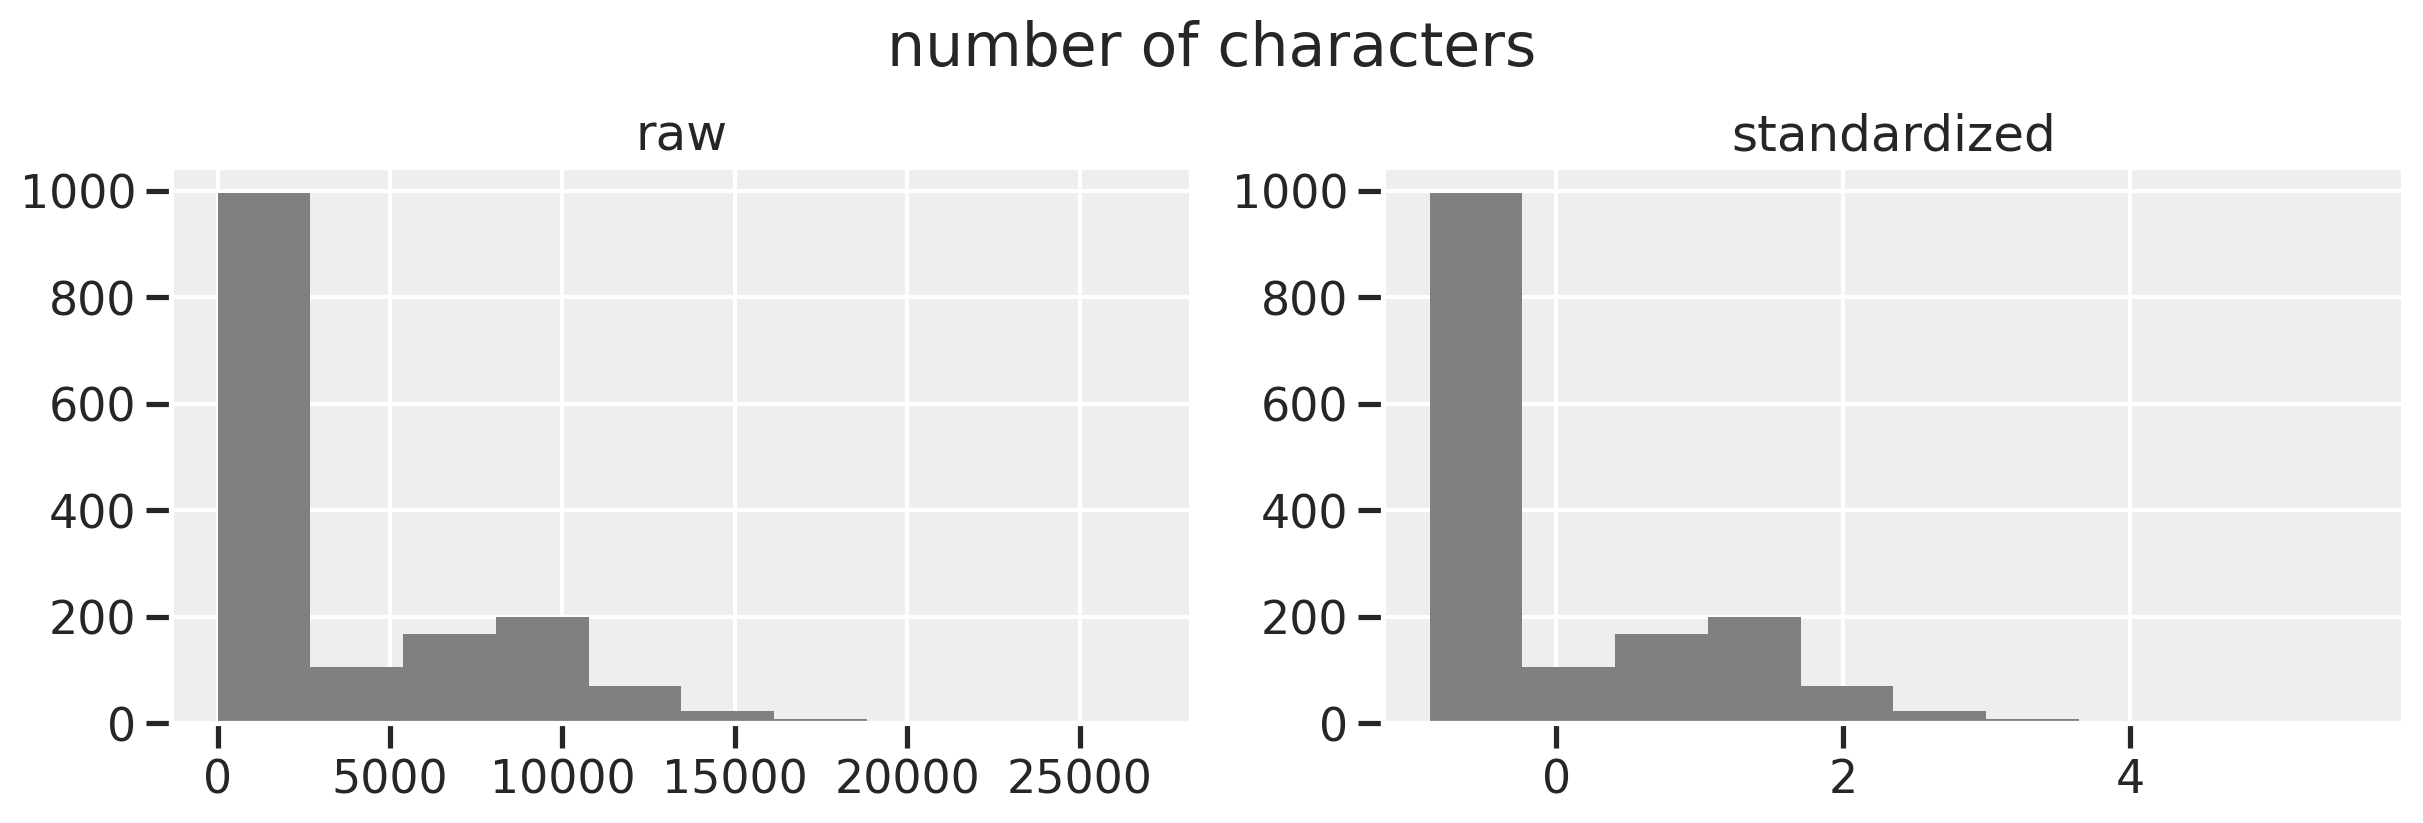

<IPython.core.display.Javascript object>

In [103]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
df_srfs_counts["n_chars_note"].hist(ax=ax1, color="gray")
ax1.set_title("raw")

df_srfs_counts["n_chars_note_std"].hist(ax=ax2, color="gray")
ax2.set_title("standardized")

f.suptitle("number of characters")

Let's make simulations for beta values.

In [137]:
#x_seq = np.linspace(np.log(100), np.log(25_000), 100)   # representative of number of characters
x_seq = np.linspace(100, 25_000, 100)
alphas = np.random.normal(1, 0.5, 100)                   # established this above
betas = np.random.lognormal(0.0, 1, 100)                  # trying these values


<IPython.core.display.Javascript object>

In [138]:
x_seq

array([  100.        ,   351.51515152,   603.03030303,   854.54545455,
        1106.06060606,  1357.57575758,  1609.09090909,  1860.60606061,
        2112.12121212,  2363.63636364,  2615.15151515,  2866.66666667,
        3118.18181818,  3369.6969697 ,  3621.21212121,  3872.72727273,
        4124.24242424,  4375.75757576,  4627.27272727,  4878.78787879,
        5130.3030303 ,  5381.81818182,  5633.33333333,  5884.84848485,
        6136.36363636,  6387.87878788,  6639.39393939,  6890.90909091,
        7142.42424242,  7393.93939394,  7645.45454545,  7896.96969697,
        8148.48484848,  8400.        ,  8651.51515152,  8903.03030303,
        9154.54545455,  9406.06060606,  9657.57575758,  9909.09090909,
       10160.60606061, 10412.12121212, 10663.63636364, 10915.15151515,
       11166.66666667, 11418.18181818, 11669.6969697 , 11921.21212121,
       12172.72727273, 12424.24242424, 12675.75757576, 12927.27272727,
       13178.78787879, 13430.3030303 , 13681.81818182, 13933.33333333,
      

<IPython.core.display.Javascript object>

In [141]:
f, ax = plt.subplots()
for a, b in zip(alphas, betas):
    # ax.plot(np.exp(x_seq), a + b * x_seq, "k", alpha=0.4)
    ax.plot(x_seq, a + b * x_seq, "k", alpha=0.4)
    ax.set_xlabel("number of characters")

<ipython-input-141-9d80bfb3568c>:4: RuntimeWarning: overflow encountered in exp
  ax.plot(x_seq, np.exp(a + b * x_seq), "k", alpha=0.4)
<ipython-input-141-9d80bfb3568c>:4: RuntimeWarning: overflow encountered in exp
  ax.plot(x_seq, np.exp(a + b * x_seq), "k", alpha=0.4)
<ipython-input-141-9d80bfb3568c>:4: RuntimeWarning: overflow encountered in exp
  ax.plot(x_seq, np.exp(a + b * x_seq), "k", alpha=0.4)
<ipython-input-141-9d80bfb3568c>:4: RuntimeWarning: overflow encountered in exp
  ax.plot(x_seq, np.exp(a + b * x_seq), "k", alpha=0.4)
<ipython-input-141-9d80bfb3568c>:4: RuntimeWarning: overflow encountered in exp
  ax.plot(x_seq, np.exp(a + b * x_seq), "k", alpha=0.4)
<ipython-input-141-9d80bfb3568c>:4: RuntimeWarning: overflow encountered in exp
  ax.plot(x_seq, np.exp(a + b * x_seq), "k", alpha=0.4)
<ipython-input-141-9d80bfb3568c>:4: RuntimeWarning: overflow encountered in exp
  ax.plot(x_seq, np.exp(a + b * x_seq), "k", alpha=0.4)
<ipython-input-141-9d80bfb3568c>:4: RuntimeWarni

ValueError: arange: cannot compute length

<Figure size 720x480 with 1 Axes>

<IPython.core.display.Javascript object>

In [112]:
def kline_prior_plot(
    N: int = 100, b_prior: str = "bespoke", x_scale: str = "stdz", ax=None
):
    """
    Utility function to plot prior predictive checks for Poisson model.
    N: number of prior predictive trends.
    Modified from kline_prior_plot, taken from pymc3 repo)

    """
    if ax is None:
        _, ax = plt.subplots()
    ax.set_ylabel("total tags")

    itcpts = np.random.normal(3.0, 0.5, N)
    if b_prior == "conventional":
        slopes = np.random.normal(0.0, 10.0, N)
        ax.set_title("b ~ Normal(0, 10)")
    elif b_prior == "bespoke":
        slopes = np.random.normal(0.0, 0.2, N)
        ax.set_title("b ~ Normal(0, 0.2)")
    else:
        raise ValueError(
            "Prior for slopes (b_prior) can only be either 'conventional' or 'bespoke'."
        )

    x_seq = np.linspace(np.log(100), np.log(200_000), N)
    # ax.set_ylim((0, 500))
    if x_scale == "log":
        for a, b in zip(itcpts, slopes):
            ax.plot(x_seq, a + b * x_seq, "k", alpha=0.4)
        ax.set_xlabel("number of characters")
    elif x_scale == "natural":
        for a, b in zip(itcpts, slopes):
            ax.plot(np.exp(x_seq), a + b * x_seq, "k", alpha=0.4)
        ax.set_xlabel("number of characters")
    else:
        x_seq = np.linspace(-2, 2, N)
        for a, b in zip(itcpts, slopes):
            ax.plot(x_seq, a + b * x_seq, "k", alpha=0.4)
        ax.set_ylim((0, 100))
        ax.set_xlabel("number of characters (std)")

    return ax

<IPython.core.display.Javascript object>

<ipython-input-113-61cabad2a4b3>:7: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


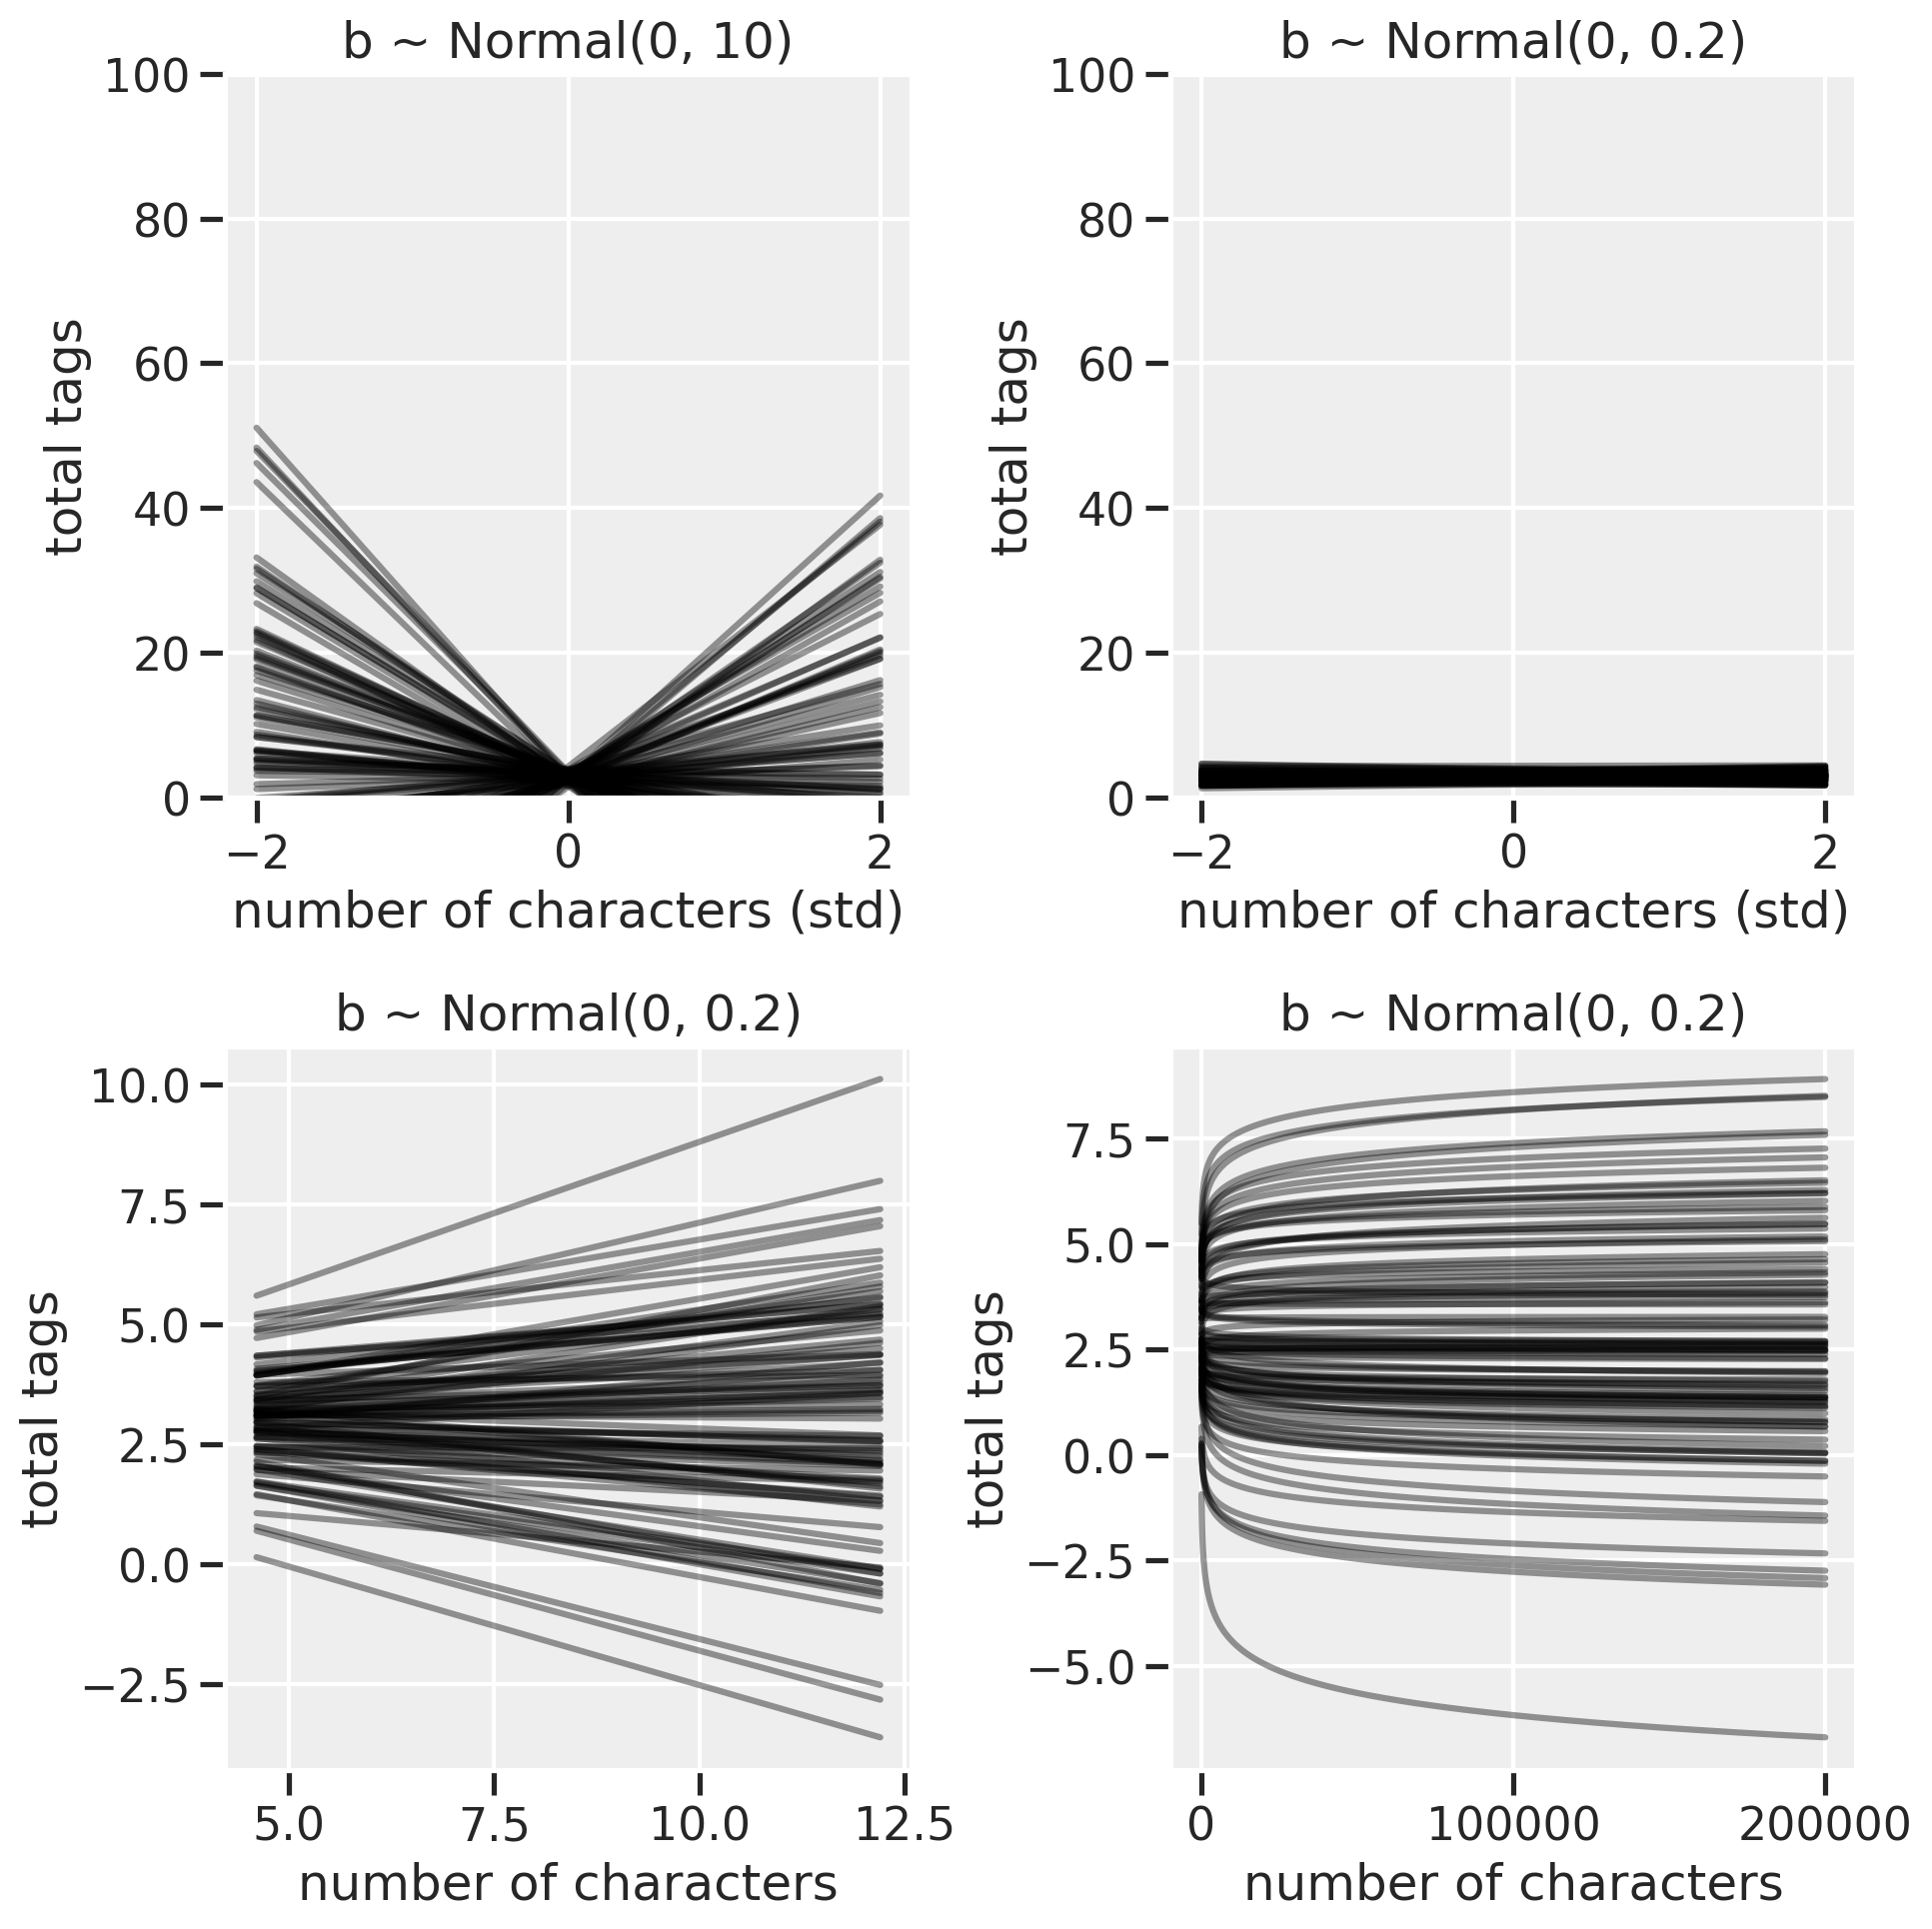

<IPython.core.display.Javascript object>

In [113]:
# Taken from repo
_, ax = plt.subplots(2, 2, figsize=(10, 10))
kline_prior_plot(b_prior="conventional", x_scale="stdz", ax=ax[0][0])
kline_prior_plot(b_prior="bespoke", x_scale="stdz", ax=ax[0][1])
kline_prior_plot(b_prior="bespoke", x_scale="log", ax=ax[1][0])
kline_prior_plot(x_scale="natural", ax=ax[1][1])
plt.tight_layout()

In [ ]:
df_srfs_counts["n_chars_note_std"]

In [158]:
# Intercept only model
with pm.Model() as m_notes2:
    # Prior chosen based on above
    a = pm.Normal("a", 1, 0.5, shape=5)
    b = pm.Normal("b", 0, 0.2, shape=5)

    # The link function, use `pm.math.exp` to get lambda
    lam = pm.Deterministic(
        "lam",
        pm.math.exp(
            a[df_srfs_counts["note_type_code"]]
            + b[df_srfs_counts["note_type_code"]] * df_srfs_counts["n_chars_note_std"]
        ),
    )

    # Likelihood,
    t = pm.Poisson("t", mu=lam, observed=df_srfs_counts["n_tags"])

    trace_m_notes2 = pm.sample(1000, tune=1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a]
INFO:pymc3:NUTS: [b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


<IPython.core.display.Javascript object>

In [167]:
az.summary(trace_m_notes2, var_names=["a", "b"])

mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
a[0]  1.051  0.068     0.940      1.156      0.001    0.001    3476.0  3467.0   
a[1]  1.334  0.042     1.267      1.400      0.001    0.000    3779.0  3770.0   
a[2] -2.366  0.188    -2.656     -2.061      0.003    0.002    3941.0  3871.0   
a[3] -0.324  0.065    -0.428     -0.222      0.001    0.001    3205.0  3050.0   
a[4] -0.514  0.128    -0.721     -0.315      0.002    0.001    3848.0  3760.0   
b[0]  0.483  0.032     0.433      0.536      0.001    0.000    3494.0  3494.0   
b[1]  0.380  0.024     0.342      0.418      0.000    0.000    3959.0  3957.0   
b[2]  0.261  0.172    -0.012      0.530      0.003    0.002    4342.0  3468.0   
b[3]  1.054  0.033     1.004      1.110      0.001    0.000    3404.0  3396.0   
b[4]  1.182  0.148     0.949      1.414      0.002    0.002    4030.0  4025.0   

      ess_bulk  ess_tail  r_hat  
a[0]    3483.0    2773.0    1.0  
a[1]    3776.0    2782.0    1.0  
a[2]    3987.0    3096.0    1.0  
a[3]    3224.0    2755.0    1.0  
a[4]    3842.0    2961.0    1.0  
b[0]    3485.0    2817.0    1.0  
b[1]    3992.0    3186.0    1.0  
b[2]    4355.0    2913.0    1.0  
b[3]    3404.0    3084.0    1.0  
b[4]    4025.0    3143.0    1.0

<IPython.core.display.Javascript object>

In [168]:
df_srfs_counts["note_type"].unique()

array(['ED_Provider_Notes', 'H&P', 'Patient_Instructions',
       'Progress_Notes', 'Telephone_Encounter'], dtype=object)

<IPython.core.display.Javascript object>

In [174]:
trace_m_notes2_df = trace_m_notes2.to_dataframe()
trace_m_notes2_df.head()

chain  draw  (posterior, a[0], 0)  (posterior, a[1], 1)  \
0      0     0              1.022753              1.315395   
1      0     1              0.979204              1.312649   
2      0     2              1.067068              1.333488   
3      0     3              1.079092              1.410042   
4      0     4              1.121303              1.361033   

   (posterior, a[2], 2)  (posterior, a[3], 3)  (posterior, a[4], 4)  \
0             -2.436624             -0.220155             -0.591403   
1             -2.385741             -0.439798             -0.707472   
2             -2.261214             -0.272039             -0.327410   
3             -2.324186             -0.381422             -0.628541   
4             -2.382466             -0.349341             -0.534580   

   (posterior, b[0], 0)  (posterior, b[1], 1)  (posterior, b[2], 2)  ...  \
0              0.466693              0.400015              0.223921  ...   
1              0.487325              0.378112              0.279387  ...   
2              0.495374              0.370369              0.173447  ...   
3              0.455671              0.353308              0.254700  ...   
4              0.462211              0.350920              0.273824  ...   

   (sample_stats, energy_error)  (sample_stats, step_size_bar)  \
0                     -0.661177                       0.552348   
1                     -0.093014                       0.552348   
2                     -0.396862                       0.552348   
3                      0.507695                       0.552348   
4                     -0.265048                       0.552348   

   (sample_stats, max_energy_error)  (sample_stats, perf_counter_diff)  \
0                          5.749071                           0.005743   
1                         -0.679483                           0.003592   
2                          0.941661                           0.001889   
3                          1.114600                           0.005198   
4                         -0.623378                           0.001268   

   (sample_stats, diverging)  (sample_stats, mean_tree_accept)  \
0                      False                          0.926753   
1                      False                          0.975291   
2                      False                          0.853880   
3                      False                          0.756600   
4                      False                          0.967403   

   (sample_stats, perf_counter_start)  (sample_stats, tree_size)  \
0                         6608.888037                       31.0   
1                         6608.893893                       15.0   
2                         6608.897687                        7.0   
3                         6608.899774                       31.0   
4                         6608.905141                        7.0   

   (sample_stats, lp)  (sample_stats, process_time_diff)  
0        -2081.860101                           0.005743  
1        -2081.864702                           0.003579  
2        -2081.516183                           0.001888  
3        -2083.378852                           0.005198  
4        -2080.879002                           0.001269  

[5 rows x 3179 columns]

<IPython.core.display.Javascript object>

#### Old notes (end)

### Posterior predictions

In [261]:
with m_beta1:
    post_pc1 = pm.sample_posterior_predictive(trace=trace_m_beta1)

<IPython.core.display.Javascript object>

In [262]:
post_pc1["t"].shape

(4000, 1577)

<IPython.core.display.Javascript object>

In [263]:
post_pc1["t"][0, :]

array([3, 7, 5, ..., 0, 0, 0])

<IPython.core.display.Javascript object>

In [264]:
df_srfs_counts.head()

note_type                file  n_tags n_chars_note  note_type_code  \
0  ED_Provider_Notes  646702875_Matt.xml    10.0         8644               0   
1  ED_Provider_Notes  742238643_Matt.xml     4.0         8122               0   
2  ED_Provider_Notes  658813952_Matt.xml     9.0         6672               0   
3  ED_Provider_Notes  650368122_Matt.xml    20.0        15323               0   
4  ED_Provider_Notes  705769932_Matt.xml    15.0         7870               0   

   n_chars_note_std  log_n_chars_note  log_n_chars_note_std  
0          1.194551          9.064621              1.111547  
1          1.069144          9.002332              1.072053  
2          0.720790          8.805675              0.947364  
3          2.799138          9.637110              1.474532  
4          1.008602          8.970813              1.052069

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'observed vs. predicted (model 1, first sample)')

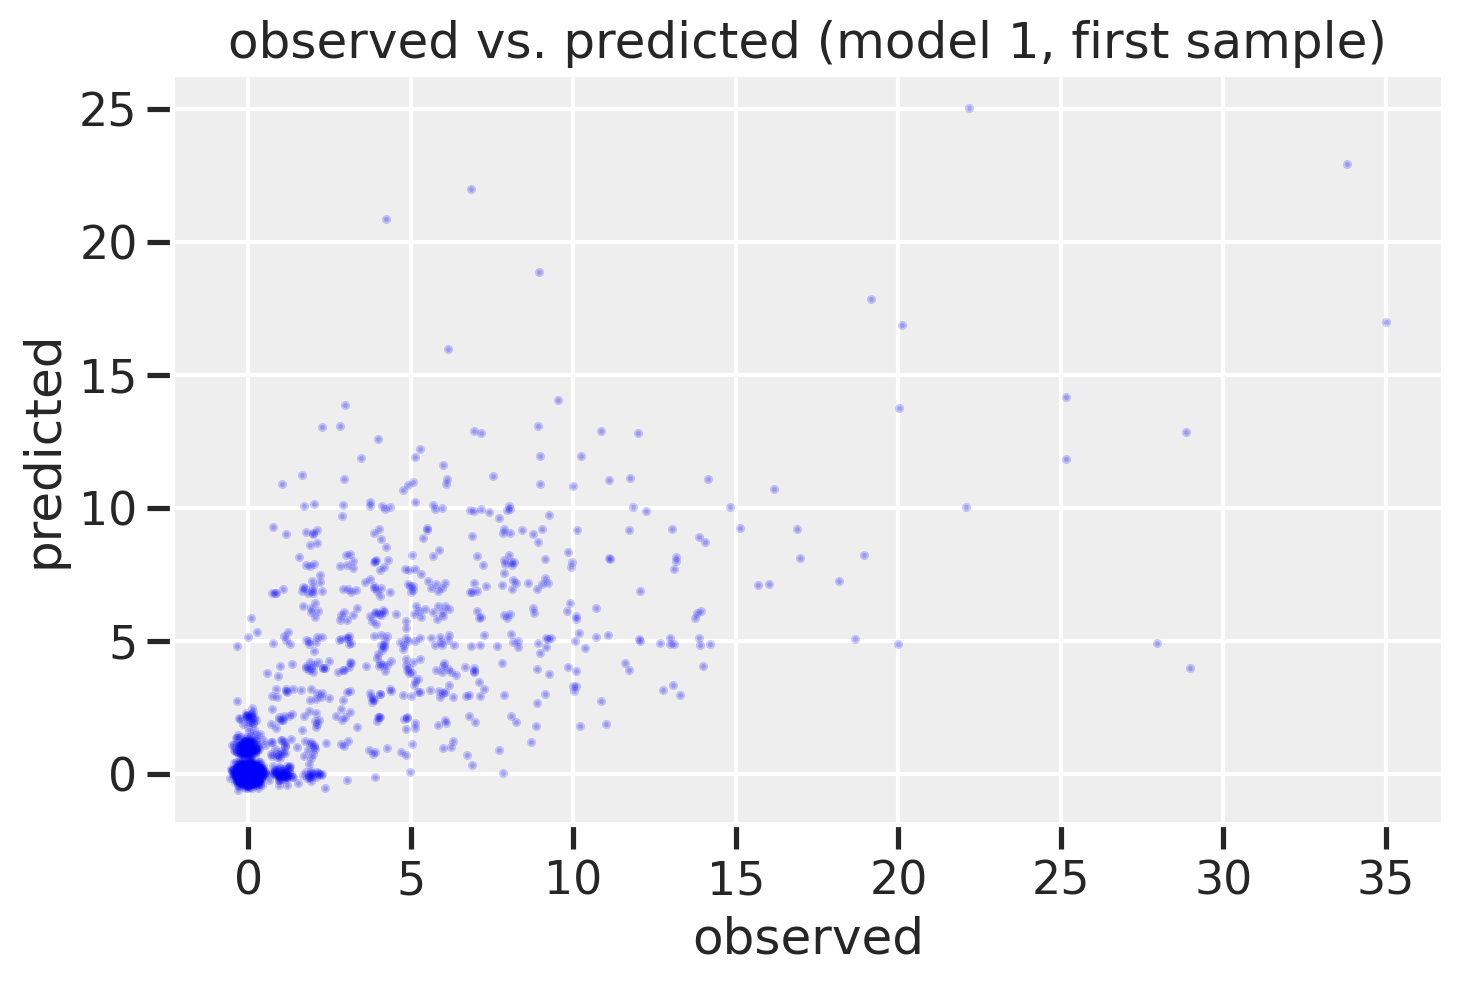

<IPython.core.display.Javascript object>

In [284]:
f, ax1 = plt.subplots()

# Add jitter to make visualizations easier
jitter = np.random.normal(0, 0.2, size=(len(df_srfs_counts), 2))

ax1.scatter(
    df_srfs_counts["n_tags"] + jitter[:, 0],
    post_pc1["t"][0, :] + jitter[:, 1],
    s=3,
    color="blue",
    alpha=0.2,
)


ax1.set_xlabel("observed")
ax1.set_ylabel("predicted")
ax1.set_title("observed vs. predicted (model 1, first sample)")

In [285]:
def get_link_pred(trace_df, x, cid):
    """
    Mimic the link function.
    """
    key_tuple = "posterior", f"a[{cid}]", cid
    y = np.exp(trace_df[key_tuple] + trace_df[key_tuple] * x)

    return y

<IPython.core.display.Javascript object>

In [286]:
trace_m_beta1_df.head()

chain  draw  (posterior, a[0], 0)  (posterior, a[1], 1)  \
0      0     0             -0.803798              0.325547   
1      0     1             -0.814175              0.312381   
2      0     2             -0.684421              0.132703   
3      0     3             -0.305312              0.180168   
4      0     4             -0.501072              0.452883   

   (posterior, a[2], 2)  (posterior, a[3], 3)  (posterior, a[4], 4)  \
0             -2.728575             -1.610794             -0.552312   
1             -2.679567             -1.634851             -0.590796   
2             -2.641535             -1.781502             -0.545275   
3             -2.674236             -1.869422             -0.548010   
4             -2.418310             -1.901019             -0.514589   

   (posterior, b[0], 0)  (posterior, b[1], 1)  (posterior, b[2], 2)  ...  \
0              2.241797              1.370514              0.357684  ...   
1              2.208132              1.375687              0.392232  ...   
2              2.165182              1.510246              0.536995  ...   
3              1.847792              1.490672              0.295733  ...   
4              1.979272              1.217668              0.439479  ...   

   (sample_stats, perf_counter_diff)  (sample_stats, lp)  \
0                           0.005488        -1950.669674   
1                           0.003461        -1951.247755   
2                           0.003260        -1950.661969   
3                           0.004619        -1948.751393   
4                           0.002840        -1952.092816   

   (sample_stats, tree_size)  (sample_stats, step_size)  \
0                       31.0                   0.249705   
1                       15.0                   0.249705   
2                       15.0                   0.249705   
3                       31.0                   0.249705   
4                       15.0                   0.249705   

   (sample_stats, depth)  (sample_stats, energy)  \
0                      5             1954.564571   
1                      4             1953.677023   
2                      4             1958.466279   
3                      5             1953.529716   
4                      4             1957.222366   

   (sample_stats, process_time_diff)  (sample_stats, energy_error)  \
0                           0.005476                     -0.549046   
1                           0.003461                      0.265112   
2                           0.003242                      0.378505   
3                           0.004619                     -0.455193   
4                           0.002790                      1.614577   

   (sample_stats, diverging)  (sample_stats, step_size_bar)  
0                      False                       0.213189  
1                      False                       0.213189  
2                      False                       0.213189  
3                      False                       0.213189  
4                      False                       0.213189  

[5 rows x 3179 columns]

<IPython.core.display.Javascript object>

#### Take a look at Pareto k values

In [292]:
# store pareto-k values for plot (taken from repo)
k = az.loo(trace_m_beta1, pointwise=True).pareto_k.values
df_srfs_counts["pareto_k"] = k

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/stats/stats.py:692: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


<IPython.core.display.Javascript object>

**Word about the Pareto distribution warning**

From the Mcelreath book:
- This means that the smoothing approximation that PSIS uses is unreliable for some points
- When the Pareto k value is high, the importance weight can be unreliable.
- These points tend to be outliers with unlikely values, according to the model.
- As a result, they're highly influential and make it difficult to estimate out-of-sample predictive accuracy. Why? Any new sample is unlikely to contain these same outlier, and since these outliers are highly influential, they could make out-of-sample predictions worse than expected.


Let's take a look at the distribution of Pareto k values.

<AxesSubplot:xlabel='pareto_k', ylabel='Count'>

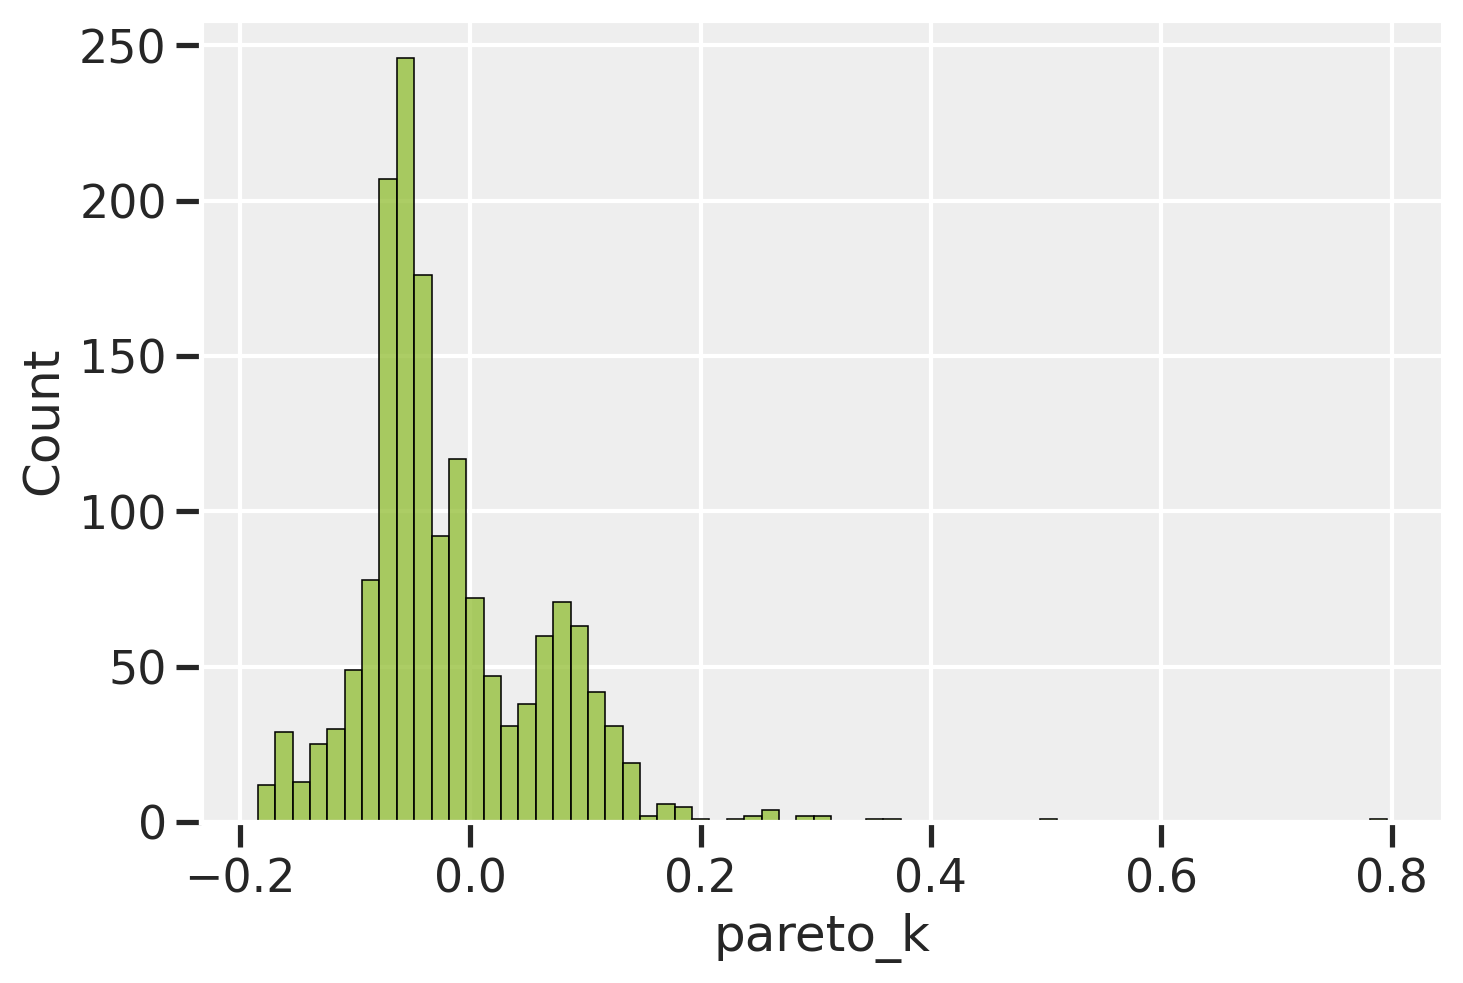

<IPython.core.display.Javascript object>

In [299]:
f, ax1 = plt.subplots()
sns.histplot(df_srfs_counts["pareto_k"], color=sf_green, ax=ax1)

In [300]:
df_t_pred0

0          1          2         3         4         5  \
-5.000000  24.908061  25.963761  15.451184  3.391412  7.420817  2.417064   
-4.919192  23.341623  24.310535  14.619831  3.308764  7.126345  2.374351   
-4.838384  21.873695  22.762577  13.833208  3.228130  6.843558  2.332393   
-4.757576  20.498084  21.313185  13.088910  3.149461  6.571993  2.291177   
-4.676768  19.208983  19.956081  12.384659  3.072709  6.311204  2.250689   
...              ...        ...        ...       ...       ...       ...   
 2.676768   0.052059   0.050110   0.080745  0.325446  0.158448  0.444308   
 2.757576   0.048785   0.046919   0.076401  0.317515  0.152161  0.436457   
 2.838384   0.045717   0.043932   0.072290  0.309777  0.146123  0.428744   
 2.919192   0.042842   0.041134   0.068400  0.302228  0.140324  0.421168   
 3.000000   0.040148   0.038515   0.064720  0.294862  0.134756  0.413725   

                  6         7         8         9  ...      3991      3992  \
-5.000000  6.922426  7.950008  5.473533  6.739710  ...  7.067841  3.392297   
-4.919192  6.657074  7.623919  5.288753  6.484866  ...  6.794061  3.309610   
-4.838384  6.401894  7.311207  5.110210  6.239658  ...  6.530887  3.228938   
-4.757576  6.156496  7.011320  4.937695  6.003721  ...  6.277907  3.150233   
-4.676768  5.920504  6.723735  4.771004  5.776707  ...  6.034726  3.073446   
...             ...       ...       ...       ...  ...       ...       ...   
 2.676768  0.168905  0.148727  0.209599  0.173109  ...  0.165708  0.325368   
 2.757576  0.162430  0.142626  0.202524  0.166563  ...  0.159289  0.317437   
 2.838384  0.156204  0.136776  0.195687  0.160265  ...  0.153119  0.309699   
 2.919192  0.150216  0.131166  0.189080  0.154205  ...  0.147187  0.302150   
 3.000000  0.144458  0.125786  0.182697  0.148374  ...  0.141486  0.294786   

               3993       3994       3995       3996      3997       3998  \
-5.000000  5.791491  10.196990  15.343211  11.776254  9.056097  12.490295   
-4.919192  5.589597   9.729686  14.519723  11.203937  8.661815  11.869152   
-4.838384  5.394740   9.283797  13.740434  10.659434  8.284700  11.278899   
-4.757576  5.206677   8.858343  13.002969  10.141394  7.924003  10.717999   
-4.676768  5.025170   8.452386  12.305085   9.648529  7.579010  10.184993   
...             ...        ...        ...        ...       ...        ...   
 2.676768  0.198998   0.118310   0.081267   0.103643  0.131943   0.098184   
 2.757576  0.192061   0.112888   0.076906   0.098606  0.126199   0.093301   
 2.838384  0.185366   0.107715   0.072778   0.093814  0.120704   0.088661   
 2.919192  0.178904   0.102778   0.068872   0.089254  0.115449   0.084252   
 3.000000  0.172667   0.098068   0.065175   0.084917  0.110423   0.080062   

               3999  avg_tags  
-5.000000  4.621944  8.152518  
-4.919192  4.481196  7.772907  
-4.838384  4.344733  7.412536  
-4.757576  4.212426  7.070370  
-4.676768  4.084148  6.745429  
...             ...       ...  
 2.676768  0.244849  0.238606  
 2.757576  0.237393  0.232504  
 2.838384  0.230164  0.226614  
 2.919192  0.223155  0.220927  
 3.000000  0.216359  0.215437  

[100 rows x 4001 columns]

<IPython.core.display.Javascript object>

In [301]:
df_t_pred2

0             1             2             3  \
-5.000000  54956.649775  45173.667866  38798.662100  44220.595866   
-4.919192  44082.098931  36378.707628  31341.038385  35626.535257   
-4.838384  35359.350581  29296.057442  25316.870064  28702.689088   
-4.757576  28362.616659  23592.343918  20450.627767  23124.459197   
-4.676768  22750.361942  18999.098860  16519.742567  18630.331518   
...                 ...           ...           ...           ...   
 2.676768      0.000044      0.000053      0.000061      0.000054   
 2.757576      0.000035      0.000042      0.000049      0.000043   
 2.838384      0.000028      0.000034      0.000039      0.000035   
 2.919192      0.000023      0.000027      0.000032      0.000028   
 3.000000      0.000018      0.000022      0.000026      0.000023   

                      4             5             6             7  \
-5.000000  15886.721716  76280.687203  19441.150745  26372.584364   
-4.919192  13066.669565  60782.695914  15925.061564  21470.218999   
-4.838384  10747.204902  48433.440469  13044.885519  17479.147948   
-4.757576   8839.468439  38593.190388  10685.612580  14229.971897   
-4.676768   7270.374296  30752.189600   8753.033214  11584.780951   
...                 ...           ...           ...           ...   
 2.676768      0.000138      0.000033      0.000114      0.000086   
 2.757576      0.000113      0.000026      0.000094      0.000070   
 2.838384      0.000093      0.000021      0.000077      0.000057   
 2.919192      0.000077      0.000016      0.000063      0.000047   
 3.000000      0.000063      0.000013      0.000051      0.000038   

                      8             9  ...          3991          3992  \
-5.000000  16785.329342  15495.254075  ...  32940.661138  37991.919511   
-4.919192  13790.428101  12751.116772  ...  26697.155558  30702.392655   
-4.838384  11329.888342  10492.953399  ...  21637.031264  24811.510628   
-4.757576   9308.367289   8634.700239  ...  17535.992586  20050.914812   
-4.676768   7647.533583   7105.535056  ...  14212.256396  16203.736678   
...                 ...           ...  ...           ...           ...   
 2.676768      0.000131      0.000141  ...      0.000070      0.000062   
 2.757576      0.000107      0.000116  ...      0.000057      0.000050   
 2.838384      0.000088      0.000095  ...      0.000046      0.000040   
 2.919192      0.000073      0.000078  ...      0.000037      0.000033   
 3.000000      0.000060      0.000065  ...      0.000030      0.000026   

                   3993          3994           3995           3996  \
-5.000000  44851.857997  86034.166661  131075.601373  128946.649438   
-4.919192  36124.768785  68388.115118  103308.862322  101664.529376   
-4.838384  29095.760534  54361.359805   81424.162258   80154.673101   
-4.757576  23434.427666  43211.564389   64175.464238   63195.803486   
-4.676768  18874.653556  34348.649549   50580.688778   49825.037316   
...                 ...           ...            ...            ...   
 2.676768      0.000053      0.000029       0.000020       0.000020   
 2.757576      0.000043      0.000023       0.000016       0.000016   
 2.838384      0.000034      0.000018       0.000012       0.000012   
 2.919192      0.000028      0.000015       0.000010       0.000010   
 3.000000      0.000022      0.000012       0.000008       0.000008   

                   3997          3998          3999      avg_tags  
-5.000000  68537.290727  15687.462966  44456.928711  62402.743184  
-4.919192  54730.755003  12906.071681  35813.081376  49508.971405  
-4.838384  43705.485167  10617.821799  28849.874133  39293.339313  
-4.757576  34901.207439   8735.279219  23240.536852  31196.690828  
-4.676768  27870.512730   7186.511930  18721.833956  24777.210929  
...                 ...           ...           ...           ...  
 2.676768      0.000036      0.000139      0.000053      0.000078  
 2.757576      0.000029      0.000114      0.000043      0.000064  
 2.838384 

<IPython.core.display.Javascript object>

To create the natural scale (not standardized or logged), then reverse standardization and exponentiate.

In [305]:
log_chars_mean = np.mean(df_srfs_counts["log_n_chars_note"])
log_chars_sd = np.std(df_srfs_counts["log_n_chars_note"])
print("log number of characters (mean): {0:0.3f}".format(log_chars_mean))
print("log number of characters (SD): {0:0.3f}".format(log_chars_sd))

log number of characters (mean): 7.312
log number of characters (SD): 1.577


<IPython.core.display.Javascript object>

In [306]:
xseq_nat = np.exp(xseq * log_chars_sd + log_chars_mean)

<IPython.core.display.Javascript object>

### Predictions and plots for ED and PI notes

Generate predictions for only two note types for more feasible plotting

In [288]:
xseq = np.linspace(-5, 3, 100)

# predictions for ED_Provider_Notes
t_pred0 = np.zeros(
    (len(xseq), len(trace_m_beta1_df))
)

# predictions for Patient_Instructions
t_pred2 = np.zeros(
    (len(xseq), len(trace_m_beta1_df))
)

for i, x in enumerate(xseq):
    t_pred0[i] = get_link_pred(trace_m_beta1_df, x, 0)
    t_pred2[i] = get_link_pred(trace_m_beta1_df, x, 2)

df_t_pred0 = pd.DataFrame(t_pred0, index=xseq)
df_t_pred2 = pd.DataFrame(t_pred2, index=xseq)

<IPython.core.display.Javascript object>

In [290]:
df_t_pred0["avg_tags"] = df_t_pred0.mean(axis=1)
df_t_pred2["avg_tags"] = df_t_pred2.mean(axis=1)

<IPython.core.display.Javascript object>

#### Limit dataframe for more feasible plotting

In [308]:
df_srfs_counts_lim = df_srfs_counts[
    df_srfs_counts["note_type"].isin(["ED_Provider_Notes", "Patient_Instructions"])
]

<IPython.core.display.Javascript object>

In [317]:
df_srfs_counts_lim.head()

note_type                file  n_tags n_chars_note  note_type_code  \
0  ED_Provider_Notes  646702875_Matt.xml    10.0         8644               0   
1  ED_Provider_Notes  742238643_Matt.xml     4.0         8122               0   
2  ED_Provider_Notes  658813952_Matt.xml     9.0         6672               0   
3  ED_Provider_Notes  650368122_Matt.xml    20.0        15323               0   
4  ED_Provider_Notes  705769932_Matt.xml    15.0         7870               0   

   n_chars_note_std  log_n_chars_note  log_n_chars_note_std  pareto_k  
0          1.194551          9.064621              1.111547  0.003068  
1          1.069144          9.002332              1.072053  0.021528  
2          0.720790          8.805675              0.947364 -0.134970  
3          2.799138          9.637110              1.474532  0.252551  
4          1.008602          8.970813              1.052069  0.104754

<IPython.core.display.Javascript object>

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/stats/stats.py:493: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/stats/stats.py:493: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/stats/stats.py:493: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/stats/stats.py:493: FutureWarning: hdi currently interprets 2d data as (draw, s

<AxesSubplot:xlabel='n_chars_note', ylabel='n_tags'>

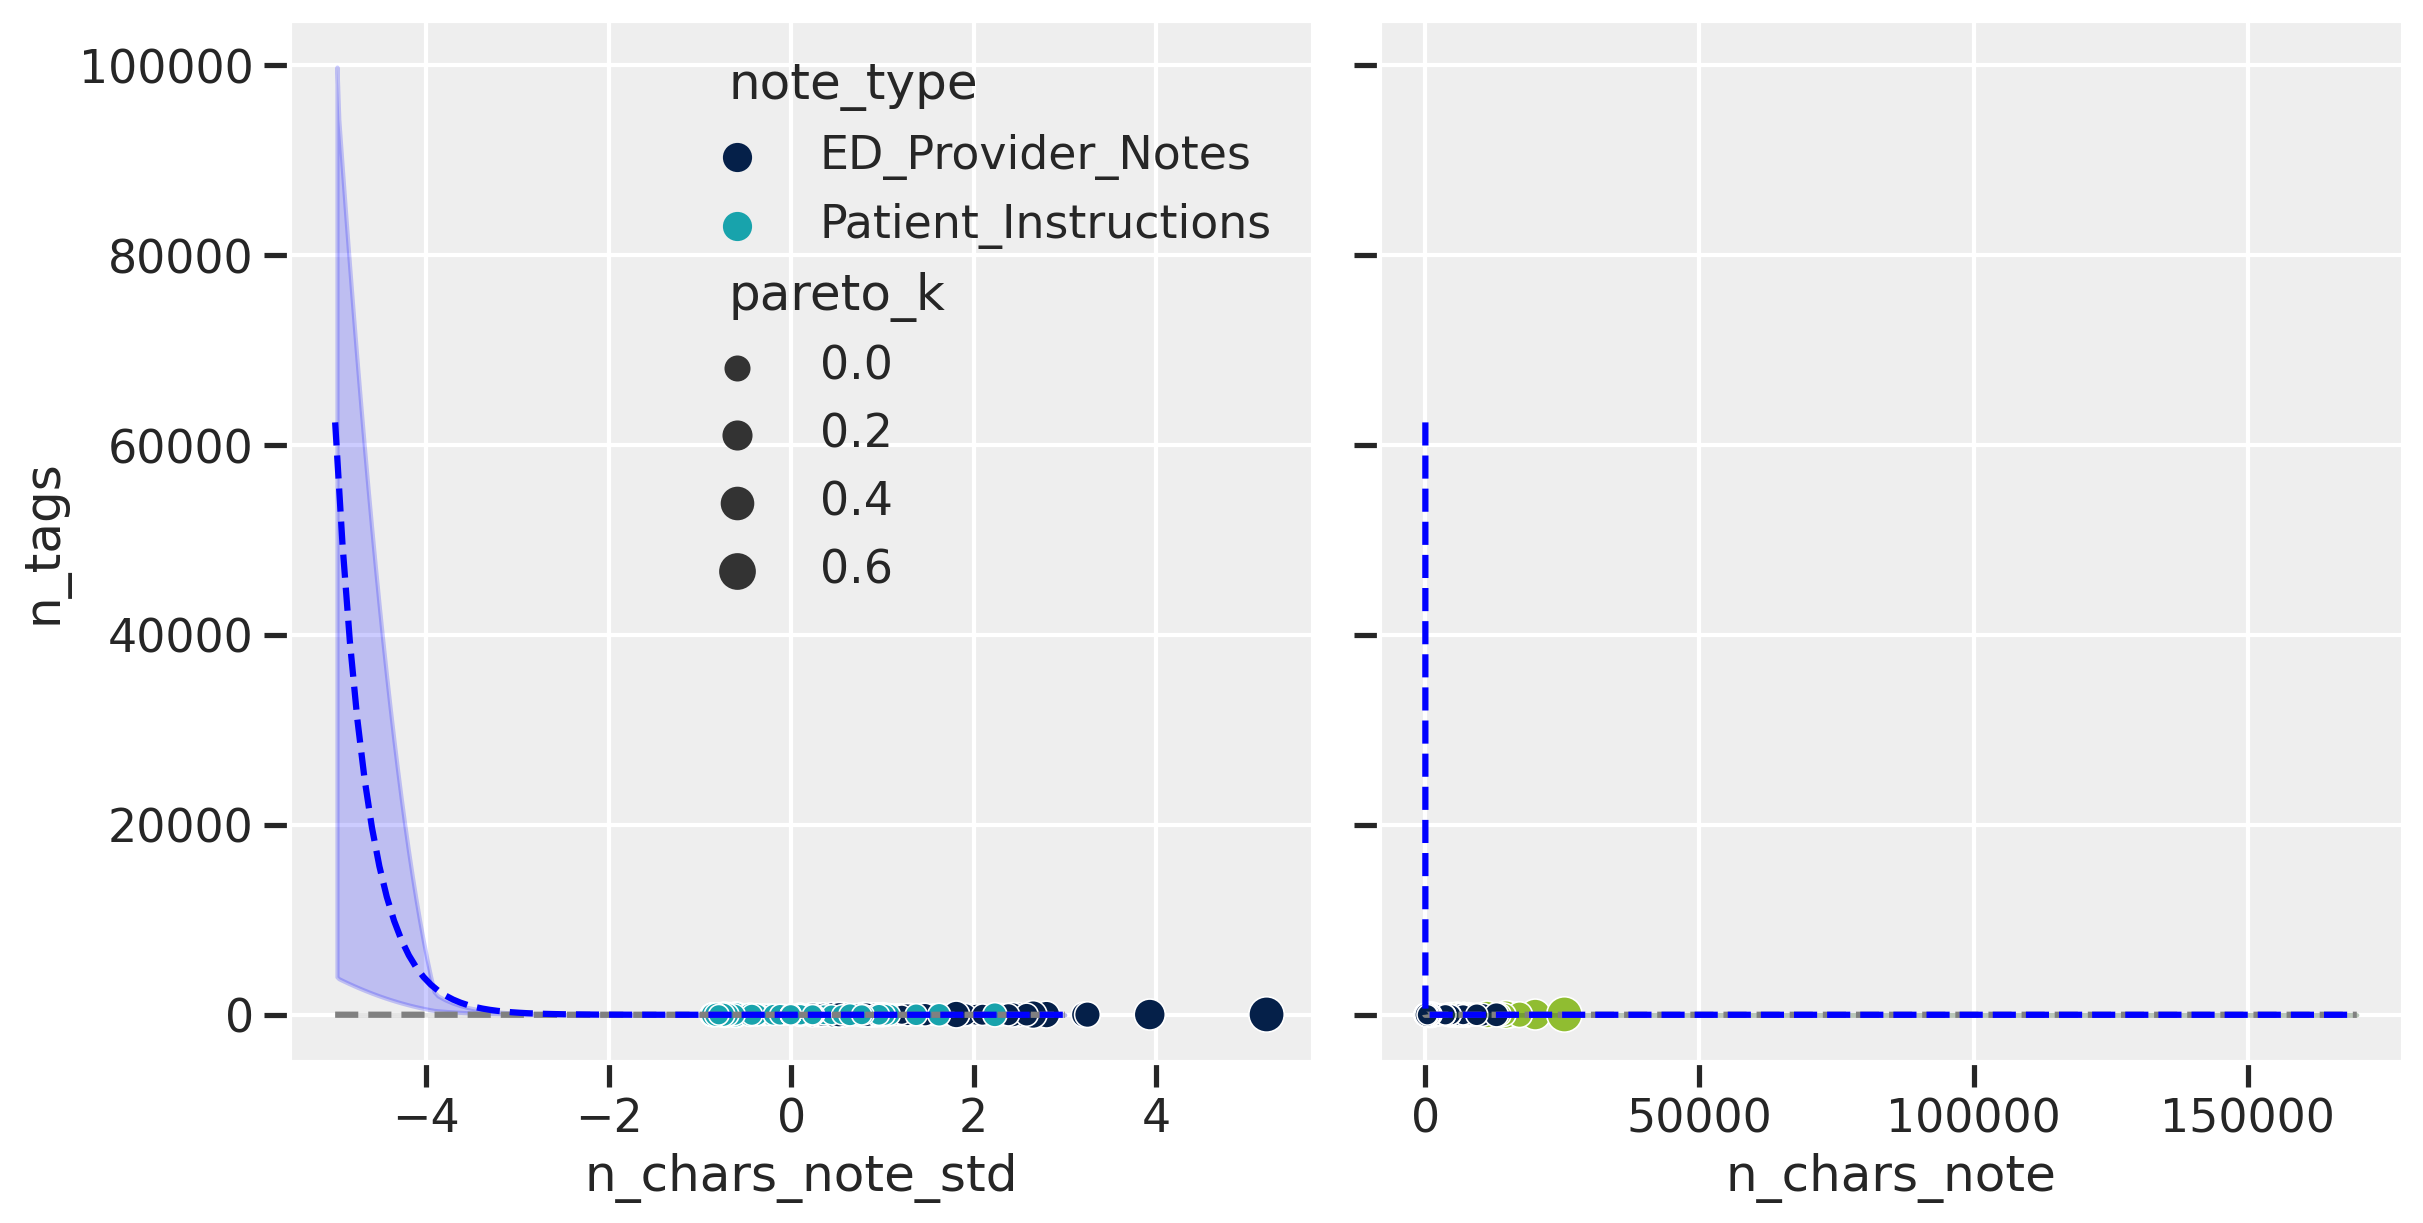

<IPython.core.display.Javascript object>

In [318]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Left subplot   -----------------------------------------
sns.scatterplot(
    data=df_srfs_counts_lim,
    x="n_chars_note_std",
    y="n_tags",
    hue="note_type",
    palette=sf_palette[0:2],
    size="pareto_k",
    ax=ax1,
)

ax1.plot(df_t_pred0.index, df_t_pred0["avg_tags"], linestyle="dashed", color="gray")

az.plot_hdi(
    df_t_pred0.index,
    df_t_pred0.iloc[:, 0:4000].T,
    ax=ax1,
    color="gray",
    fill_kwargs={"alpha": 0.2},
)

ax1.plot(df_t_pred2.index, df_t_pred2["avg_tags"], linestyle="dashed", color="blue")
az.plot_hdi(
    df_t_pred2.index,
    df_t_pred2.iloc[:, 0:4000].T,
    ax=ax1,
    color="blue",
    fill_kwargs={"alpha": 0.2},
)

# ax1.set_xlim([-2, 3])
# ax1.set_ylim([-100, 500])


# Right subplot   -----------------------------------------
sns.scatterplot(
    data=df_srfs_counts_lim,
    x="n_chars_note",
    y="n_tags",
    hue="note_type",
    palette=[sf_green, sf_navy],
    size="pareto_k",
    legend=None,
    ax=ax2,
)
ax2.plot(xseq_nat, df_t_pred0["avg_tags"], linestyle="dashed", color="gray")
ax2.plot(xseq_nat, df_t_pred2["avg_tags"], linestyle="dashed", color="blue")

az.plot_hdi(
    xseq_nat,
    df_t_pred0.iloc[:, 0:4000].T,
    ax=ax2,
    color=sf_green,
    fill_kwargs={"alpha": 0.2},
)

az.plot_hdi(
    xseq_nat,
    df_t_pred2.iloc[:, 0:4000].T,
    ax=ax2,
    color=sf_navy,
    fill_kwargs={"alpha": 0.2},
)

# Helps for visualization
# ax2.set_xlim([-25000, 300000])

It's really hard to see, so let's change the x- and y-axis limits.

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/stats/stats.py:493: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/stats/stats.py:493: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/stats/stats.py:493: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/stats/stats.py:493: FutureWarning: hdi currently interprets 2d data as (draw, s

(-1000.0, 30000.0)

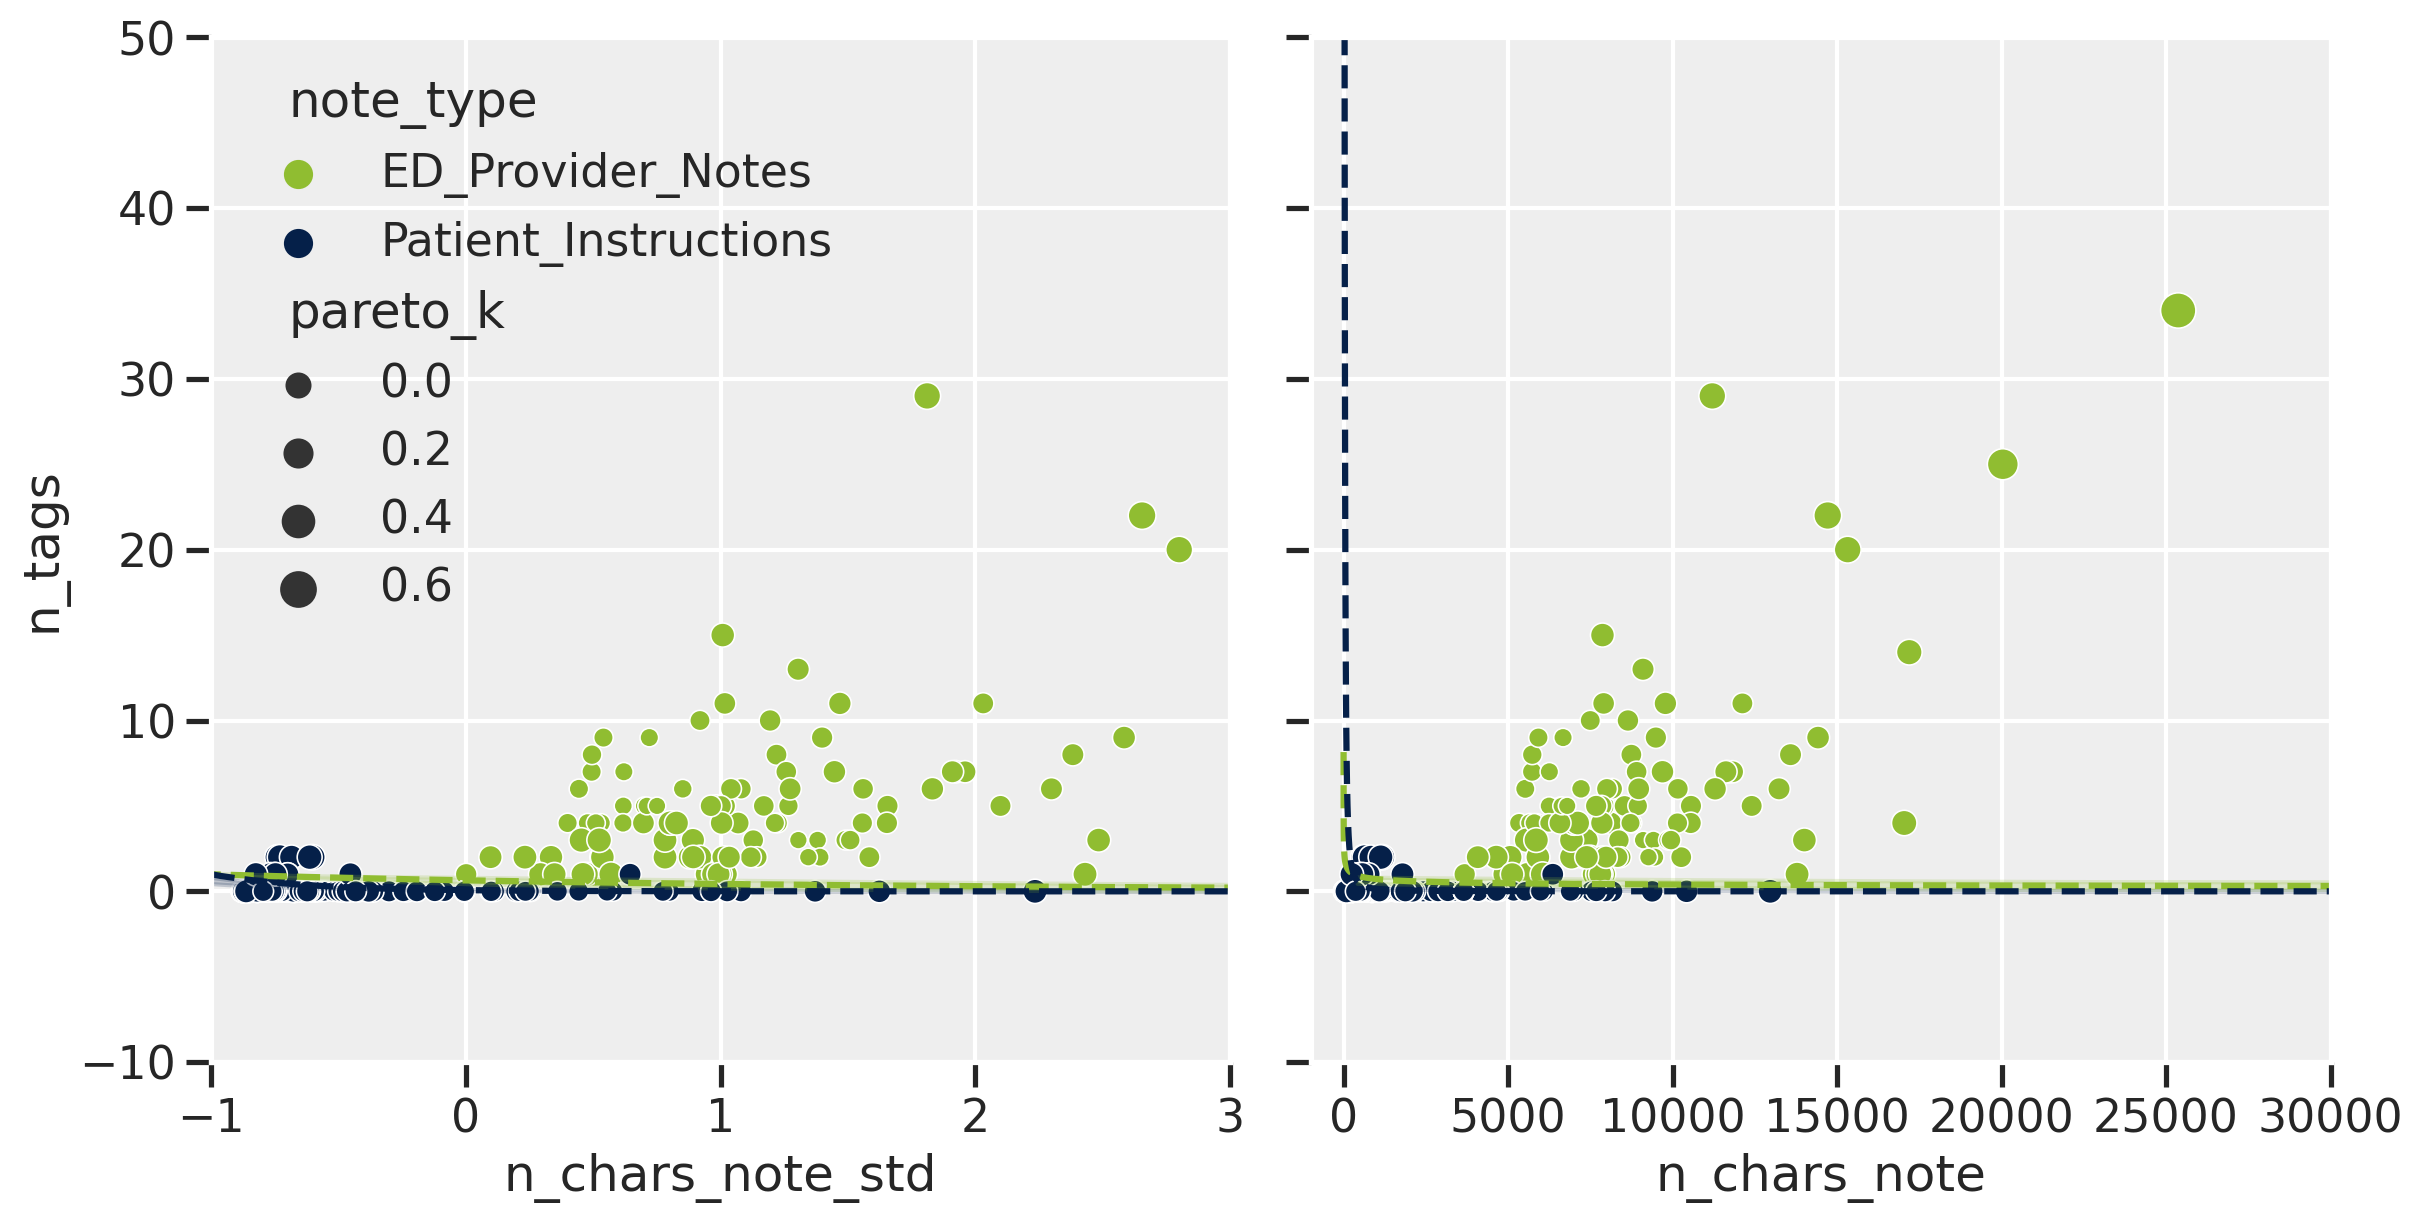

<IPython.core.display.Javascript object>

In [327]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Left subplot   -----------------------------------------
sns.scatterplot(
    data=df_srfs_counts_lim,
    x="n_chars_note_std",
    y="n_tags",
    hue="note_type",
    palette=[sf_green, sf_navy],
    size="pareto_k",
    ax=ax1,
)

ax1.plot(df_t_pred0.index, df_t_pred0["avg_tags"], linestyle="dashed", color=sf_green)
az.plot_hdi(
    df_t_pred0.index,
    df_t_pred0.iloc[:, 0:4000].T,
    ax=ax1,
    color=sf_green,
    fill_kwargs={"alpha": 0.2},
)

ax1.plot(df_t_pred2.index, df_t_pred2["avg_tags"], linestyle="dashed", color=sf_navy)
az.plot_hdi(
    df_t_pred2.index,
    df_t_pred2.iloc[:, 0:4000].T,
    ax=ax1,
    color=sf_navy,
    fill_kwargs={"alpha": 0.2},
)

ax1.set_xlim([-1, 3])
ax1.set_ylim([-10, 50])


# Right subplot   -----------------------------------------
sns.scatterplot(
    data=df_srfs_counts_lim,
    x="n_chars_note",
    y="n_tags",
    hue="note_type",
    palette=[sf_green, sf_navy],
    size="pareto_k",
    legend=None,
    ax=ax2,
)

ax2.plot(xseq_nat, df_t_pred0["avg_tags"], linestyle="dashed", color=sf_green)
az.plot_hdi(
    xseq_nat,
    df_t_pred0.iloc[:, 0:4000].T,
    ax=ax2,
    color=sf_green,
    fill_kwargs={"alpha": 0.2},
)

ax2.plot(xseq_nat, df_t_pred2["avg_tags"], linestyle="dashed", color=sf_navy)
az.plot_hdi(
    xseq_nat,
    df_t_pred2.iloc[:, 0:4000].T,
    ax=ax2,
    color=sf_navy,
    fill_kwargs={"alpha": 0.2},
)

# Helps for visualization
ax2.set_xlim([-1000, 30000])

These are absolutely horrible predictions. The `ED_Provider_Notes` have more tags for sure.

## Compare models

In [229]:
az.compare({"m_notes1": trace_m_notes1, "m_notes2": trace_m_notes2})

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/stats/stats.py:146: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/stats/stats.py:692: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


rank          loo      p_loo       d_loo    weight          se  \
m_notes2     0 -2033.806265  33.008451    0.000000  0.999511   76.180653   
m_notes1     1 -2717.791850  19.253573  683.985585  0.000489  131.087649   

                dse  warning loo_scale  
m_notes2   0.000000     True       log  
m_notes1  96.323833    False       log

<IPython.core.display.Javascript object>

# Zero-inflated Poission

- Clinicians do not ask (perhaps not much time or patient status does not seem like they need to be asked)
- Or some can be due to the note type


$$y_i \text{ ~ } \text{ZIPoisson}(p_i,\lambda_i) $$ 

$$\text{logit}(p_i) = \alpha_p + \beta_px_i$$ 

$$\text{log}(\lambda_i) = \alpha_{\lambda} + \beta_{\lambda}x_i$$ 


*p* represents the probability that a note will contain social data

*lambda* represents the expected value of the outcome y (average)

In [ ]:
 with pm.Model() as m_notes1:
    # 
    ap = pm.Normal("ap", -1.5, 1.0)
    al = pm.Normal("al", 1.0, 0.5)

    p = pm.math.invlogit(ap)
    lambda_ = pm.math.exp(al)

    y_obs = pm.ZeroInflatedPoisson("y_obs", 1.0 - p, lambda_, observed=y)

    trace_notes1 = pm.sample(tune=2000, random_seed=RANDOM_SEED)
    
az.summary(trace_12_3, round_to=2)

# [OLD NOTES BELOW] Censored cats and survival analysis

These concepts were covered in lecture 13 [here](https://youtu.be/p7g-CgGCS34?list=PLDcUM9US4XdNM4Edgs7weiyIguLSToZRI&t=1433). I used the R `rethinking` package to obtain the data. The question is to determine whether black cats are more discriminated against for adoption than other cats.


In [9]:
df_cats = pd.read_csv("other_data/AustinCats.csv", sep=",")
df_cats.head()

id  days_to_event                date_out out_event  \
0  A730601              1  07/08/2016 09:00:00 AM  Transfer   
1  A679549             25  06/16/2014 01:54:00 PM  Transfer   
2  A683656              4  07/17/2014 04:57:00 PM  Adoption   
3  A709749             41  09/22/2015 12:49:00 PM  Transfer   
4  A733551              9  09/01/2016 12:00:00 AM  Transfer   

                  date_in in_event                   breed              color  \
0  07/07/2016 12:11:00 PM    Stray  Domestic Shorthair Mix         Blue Tabby   
1  05/22/2014 03:43:00 PM    Stray  Domestic Shorthair Mix        Black/White   
2  07/13/2014 01:20:00 PM    Stray            Snowshoe Mix         Lynx Point   
3  08/12/2015 06:29:00 PM    Stray  Domestic Shorthair Mix             Calico   
4  08/23/2016 02:35:00 PM    Stray  Domestic Shorthair Mix  Brown Tabby/White   

   intake_age  
0           7  
1           1  
2           2  
3          12  
4           1

<IPython.core.display.Javascript object>

In [12]:
df_cats.shape

(22356, 11)

<IPython.core.display.Javascript object>

Prepare dataframe as described in the lecture.

In [15]:
# Getting adopted is 1
df_cats["adopt"] = np.where(df_cats["out_event"] == "Adoption", 1, 0)

# It looks like he used black as lower index
df_cats["color_id"] = np.where(df_cats["color"] == "Black", 0, 1)

df_cats.head(10)

id  days_to_event                date_out out_event  \
0  A730601              1  07/08/2016 09:00:00 AM  Transfer   
1  A679549             25  06/16/2014 01:54:00 PM  Transfer   
2  A683656              4  07/17/2014 04:57:00 PM  Adoption   
3  A709749             41  09/22/2015 12:49:00 PM  Transfer   
4  A733551              9  09/01/2016 12:00:00 AM  Transfer   
5  A756485              4  08/24/2017 05:34:00 PM  Adoption   
6  A732960              4  08/19/2016 06:27:00 PM  Adoption   
7  A664571              5  10/10/2013 02:07:00 PM  Adoption   
8  A727402             24  06/14/2016 04:18:00 PM  Adoption   
9  A749579              2  05/18/2017 03:36:00 PM  Transfer   

                  date_in         in_event                   breed  \
0  07/07/2016 12:11:00 PM            Stray  Domestic Shorthair Mix   
1  05/22/2014 03:43:00 PM            Stray  Domestic Shorthair Mix   
2  07/13/2014 01:20:00 PM            Stray            Snowshoe Mix   
3  08/12/2015 06:29:00 PM            Stray  Domestic Shorthair Mix   
4  08/23/2016 02:35:00 PM            Stray  Domestic Shorthair Mix   
5  08/20/2017 03:07:00 PM            Stray  Domestic Shorthair Mix   
6  08/15/2016 03:08:00 PM            Stray  Domestic Shorthair Mix   
7  10/05/2013 01:43:00 PM  Owner Surrender  Domestic Shorthair Mix   
8  05/21/2016 04:30:00 PM            Stray  Domestic Shorthair Mix   
9  05/16/2017 05:19:00 PM            Stray  Domestic Shorthair Mix   

               color  intake_age  adopt  color_id     color_id  
0         Blue Tabby           7      0            1         1  
1        Black/White           1      0            1         1  
2         Lynx Point           2      1            1         1  
3             Calico          12      0            1         1  
4  Brown Tabby/White           1      0            1         1  
5         Blue Tabby           1      1            1         1  
6             Calico           2      1            1         1  
7             Torbie          24      1            1         1  
8        Brown Tabby           1      1            1         1  
9         Blue Tabby           3      0            1         1

<IPython.core.display.Javascript object>

In [17]:
df_cats["color_id"].value_counts()

1    19391
0     2965
Name: color_id, dtype: int64

<IPython.core.display.Javascript object>

Rojan's code

```
def likelihood(lam,obs_value,censored):
    return (censored*tt.log(lam) - lam * obs_value)

with pm.Model() as m_1:
   cid=pm.Data('cid',df['black'])
    adopted=pm.intX(pm.Data('adopted',df['adopted']))
    a=pm.Normal('a',0,1,shape=2)
    mu = pm.math.exp(a[cid])
    lam= pm.Deterministic('lam',1/mu)
 D=pm.Potential('D',likelihood(lam=lam,obs_value=df['days_to_event'].values,censored=adopted))
  trace_1=pm.sample()

```

In [18]:
def likelihood(lam, obs_value, censored):
    return censored * tt.log(lam) - lam * obs_value

<IPython.core.display.Javascript object>

In [20]:
with pm.Model() as m_cats1:
    # priors
    a = pm.Normal("a", 0, 1, shape=2)

    mu = pm.math.exp(a[df_cats["color_id"]])
    lam = pm.Deterministic("lam", 1 / mu)

    D = pm.Potential(
        "D",
        likelihood(
            lam=lam,
            obs_value=df_cats["days_to_event"].values,
            censored=df_cats["adopt"],
        ),
    )

    trace_1 = pm.sample(1000, tune=1000, return_inferencedata=True)

NameError: name 'tt' is not defined

<IPython.core.display.Javascript object>

# Question 1 (12H7)

In the Trolley data—`data(Trolley)`—we saw how education level (modeled as an ordered category) is associated with responses. Is this association causal? One plausible confound is that education is also associated with age, through a causal process: People are older when they finish school than when they begin it.

Reconsider the Trolley data in this light. Draw a DAG that represents hypothetical causal relationships among response, education, and age. Which statistical model or models do you need to evaluate the causal influence of education on responses? Fit these models to the trolley data. What do you conclude about the causal relationships among these three variables?

## Data exploration and setup

In [5]:
df_trolley = pd.read_csv(
    "../pymc3_ed_resources/resources/Rethinking_2/Data/Trolley.csv",
    delimiter=";",
)
df_trolley.head()

case  response  order      id  age  male            edu  action  \
0  cfaqu         4      2  96;434   14     0  Middle School       0   
1  cfbur         3     31  96;434   14     0  Middle School       0   
2  cfrub         4     16  96;434   14     0  Middle School       0   
3  cibox         3     32  96;434   14     0  Middle School       0   
4  cibur         3      4  96;434   14     0  Middle School       0   

   intention  contact story  action2  
0          0        1   aqu        1  
1          0        1   bur        1  
2          0        1   rub        1  
3          1        1   box        1  
4          1        1   bur        1

<IPython.core.display.Javascript object>

In [6]:
print("shape of df: ", df_trolley.shape)

shape of df:  (9930, 12)


<IPython.core.display.Javascript object>

## DAG

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


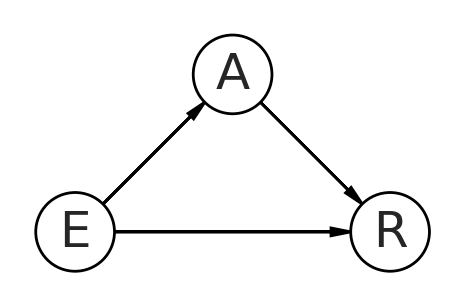

<IPython.core.display.Javascript object>

In [28]:
pipe_dag = CausalGraphicalModel(
    nodes=["E", "A", "R"],
    edges=[
        ("E", "A"),
        ("A", "R"),
        ("E", "R"),
    ],
)
pgm = daft.PGM()

coordinates = {
    "E": (0, 0),
    "A": (1, 1),
    "R": (2, 0),
}
for node in pipe_dag.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in pipe_dag.dag.edges:
    pgm.add_edge(*edge)
pgm.render()


## Original model

Taken from the book chapter to ensure that I can reproduce the results before adding the education variable.

### Model equation

$$R_i \text{ ~ } \text{Ordered-logit}(\phi_i,\kappa) \tag{probability of data}$$ 

$$\phi_i = 0 \tag{linear model}$$ 

$$\kappa_k \text{ ~ } \text{Normal}(0, 1.5) \tag{common prior for each intercept}$$

However, he states that the model can be re-written more literally where we instead use a vector of probabilities **p**.

$$R_i \text{ ~ } \text{Categorical}(\boldsymbol{p}) \tag{probability of data}$$

$$p_1 = q_1 \tag{probabilities of each value k}$$ 

$$p_k = q_k - q_{k-1} \text{  for $K > k > 1$} $$

$$p_k = 1 - q_{k-1} $$

$$\text{logit}(q_k) = \kappa_k - \phi_i  \tag{cumulative logit link}$$ 

$$\phi_i = \text{terms of linear model}  \tag{linear model}$$

$$\kappa_k \text{ ~ } \text{Normal}(0, 1.5)  \tag{common prior for each intercept}$$



Note that McElreath uses Greek letter \(\kappa\) (kappa) to refer to the intercepts but he switches to using \(\alpha\) later.


In [8]:
df_trolley.head()

case  response  order      id  age  male            edu  action  \
0  cfaqu         4      2  96;434   14     0  Middle School       0   
1  cfbur         3     31  96;434   14     0  Middle School       0   
2  cfrub         4     16  96;434   14     0  Middle School       0   
3  cibox         3     32  96;434   14     0  Middle School       0   
4  cibur         3      4  96;434   14     0  Middle School       0   

   intention  contact story  action2  
0          0        1   aqu        1  
1          0        1   bur        1  
2          0        1   rub        1  
3          1        1   box        1  
4          1        1   bur        1

<IPython.core.display.Javascript object>

### Intercept only model

Here is the setup in pymc as taken from the repo. Per McElreath's text: "In code form for either quap and ulam, the link function will be embedded in the likelihood function already." McElreath cautions that this can take a while but it only took ~30 seconds for me.

In [12]:
with pm.Model() as m12_4:

    cutpoints = pm.Normal(
        "cutpoints",
        0.0,
        1.5,
        transform=pm.distributions.transforms.ordered,
        shape=6,
        testval=np.arange(6) - 2.5,  # array([-2.5, -1.5, -0.5,  0.5,  1.5,  2.5])
    )

    R = pm.OrderedLogistic("R", 0.0, cutpoints, observed=df_trolley["response"] - 1)
    
    # Get posterior
    trace_12_4 = pm.sample(random_seed=RANDOM_SEED, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [cutpoints]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


<IPython.core.display.Javascript object>

In [13]:
az.summary(trace_12_4)

mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_mean  \
cutpoints[0] -1.917  0.030    -1.961     -1.866        0.0      0.0    4392.0   
cutpoints[1] -1.266  0.024    -1.302     -1.226        0.0      0.0    4999.0   
cutpoints[2] -0.718  0.022    -0.753     -0.685        0.0      0.0    5227.0   
cutpoints[3]  0.248  0.020     0.219      0.283        0.0      0.0    4775.0   
cutpoints[4]  0.890  0.022     0.856      0.926        0.0      0.0    4918.0   
cutpoints[5]  1.770  0.029     1.727      1.817        0.0      0.0    5106.0   

              ess_sd  ess_bulk  ess_tail  r_hat  
cutpoints[0]  4392.0    4396.0    2633.0    1.0  
cutpoints[1]  4999.0    4997.0    3517.0    1.0  
cutpoints[2]  5221.0    5203.0    3520.0    1.0  
cutpoints[3]  4735.0    4795.0    3613.0    1.0  
cutpoints[4]  4918.0    4883.0    3542.0    1.0  
cutpoints[5]  5094.0    5125.0    3798.0    1.0

<IPython.core.display.Javascript object>

In [17]:
trace_12_4_df = trace_12_4.to_dataframe()
trace_12_4_df

chain  draw  (posterior, cutpoints[0], 0)  (posterior, cutpoints[1], 1)  \
0         0     0                     -1.944997                     -1.271992   
1         0     1                     -1.891395                     -1.259263   
2         0     2                     -1.902102                     -1.269827   
3         0     3                     -1.913761                     -1.259292   
4         0     4                     -1.886907                     -1.256226   
...     ...   ...                           ...                           ...   
3995      3   995                     -1.900627                     -1.243956   
3996      3   996                     -1.912429                     -1.263198   
3997      3   997                     -1.909409                     -1.258437   
3998      3   998                     -1.949809                     -1.282035   
3999      3   999                     -1.949211                     -1.266982   

      (posterior, cutpoints[2], 2)  (posterior, cutpoints[3], 3)  \
0                        -0.723195                      0.262819   
1                        -0.718099                      0.223384   
2                        -0.699676                      0.270881   
3                        -0.734792                      0.225806   
4                        -0.724622                      0.226160   
...                            ...                           ...   
3995                     -0.678162                      0.277044   
3996                     -0.723993                      0.255216   
3997                     -0.737196                      0.255319   
3998                     -0.719329                      0.225058   
3999                     -0.706837                      0.237230   

      (posterior, cutpoints[4], 4)  (posterior, cutpoints[5], 5)  \
0                         0.889961                      1.767569   
1                         0.871716                      1.732266   
2                         0.904259                      1.786165   
3                         0.879706                      1.766346   
4                         0.851608                      1.738584   
...                            ...                           ...   
3995                      0.910309                      1.791648   
3996                      0.907415                      1.784581   
3997                      0.881452                      1.763388   
3998                      0.869017                      1.709517   
3999                      0.882233                      1.735843   

      (log_likelihood, R[0], 0)  (log_likelihood, R[1000], 1000)  ...  \
0                     -1.432802                        -1.432802  ...   
1                     -1.479273                        -1.479273  ...   
2                     -1.446362                        -1.446362  ...   
3                     -1.460722                        -1.460722  ...   
4                     -1.470006                        -1.470006  ...   
...                         ...                              ...  ...   
3995                  -1.460373                        -1.460373  ...   
3996                  -1.439925                        -1.439925  ...   
3997                  -1.427668                        -1.427668  ...   
3998                  -1.476275                        -1.476275  ...   
3999                  -1.475201                        -1.475201  ...   

      (sample_stats, perf_counter_diff)  (sample_stats, tree_size)  \
0                              0.002530                        7.0   
1                              0.002538                        7.0   
2                              0.002506                        7.0   
3                              0.002469                        7.0   
4                              0.002450                        7.0   
...                                 ...                        ...   
3995                           0

<IPython.core.display.Javascript object>

In [31]:
cutpoints_mean = trace_12_4_df[
    [("posterior", "cutpoints" + str([i]), i) for i in range(6)]
].mean()
cutpoints_mean

(posterior, cutpoints[0], 0)   -1.916689
(posterior, cutpoints[1], 1)   -1.266421
(posterior, cutpoints[2], 2)   -0.718219
(posterior, cutpoints[3], 3)    0.247919
(posterior, cutpoints[4], 4)    0.890110
(posterior, cutpoints[5], 5)    1.769816
dtype: float64

<IPython.core.display.Javascript object>

In [32]:
# Get cumulative probabilities back
logistic(cutpoints_mean.round(3))

(posterior, cutpoints[0], 0)    0.128196
(posterior, cutpoints[1], 1)    0.219943
(posterior, cutpoints[2], 2)    0.327834
(posterior, cutpoints[3], 3)    0.561684
(posterior, cutpoints[4], 4)    0.708890
(posterior, cutpoints[5], 5)    0.854458
dtype: float64

<IPython.core.display.Javascript object>

### Model with predictor variables

We'll define a linear model $\phi_i = \beta x_i$, then each cumulative logit becomes:

$$\text{log} \frac{\text{Pr}(y_i \leq k)}{1-\text{Pr}(y_i \leq k)} = \alpha_k - \phi_i $$

$$\phi_i = \beta x_i$$


Note here \(\alpha\) is referring to the intercept term when he had used \(\kappa\) before.

In [33]:
df_trolley.head()

case  response  order      id  age  male            edu  action  \
0  cfaqu         4      2  96;434   14     0  Middle School       0   
1  cfbur         3     31  96;434   14     0  Middle School       0   
2  cfrub         4     16  96;434   14     0  Middle School       0   
3  cibox         3     32  96;434   14     0  Middle School       0   
4  cibur         3      4  96;434   14     0  Middle School       0   

   intention  contact story  action2  
0          0        1   aqu        1  
1          0        1   bur        1  
2          0        1   rub        1  
3          1        1   box        1  
4          1        1   bur        1

<IPython.core.display.Javascript object>

This cell took a little bit longer to run.

In [36]:
with pm.Model() as m12_5:
    cutpoints = pm.Normal(
        "cutpoints",
        0.0,
        1.5,
        transform=pm.distributions.transforms.ordered,
        shape=6,
        testval=np.arange(6) - 2.5,
    )
    bA = pm.Normal("bA", 0.0, 0.5)
    bC = pm.Normal("bC", 0.0, 0.5)
    bI = pm.Normal("bI", 0.0, 0.5)
    bIA = pm.Normal("bIA", 0.0, 0.5)
    bIC = pm.Normal("bIC", 0.0, 0.5)

    A = pm.Data("A", df_trolley["action"])
    I = pm.Data("I", df_trolley["intention"])
    C = pm.Data("C", df_trolley["contact"])
    
    # This defines the interaction of intention between action and contact
    BI = bI + bIA * A + bIC * C
    phi = pm.Deterministic("phi", bA * A + bC * C + BI * I)

    resp_obs = pm.OrderedLogistic(
        "resp_obs", phi, cutpoints, observed=df_trolley["response"]-1
    )

    trace_12_5 = pm.sample(random_seed=RANDOM_SEED, return_inferencedata=True)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bIC, bIA, bI, bC, bA, cutpoints]
INFO:pymc3:NUTS: [bIC, bIA, bI, bC, bA, cutpoints]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 114 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 114 seconds.


<IPython.core.display.Javascript object>

### Prior predictions of cutpoints

In [99]:
with m12_5:
    prior_pc = pm.sample_prior_predictive(var_names=["cutpoints"])

prior_pc

{'cutpoints': array([[ 2.40881536, -0.06909538,  0.58876406,  1.07911596,  2.5537707 ,
          0.17473549],
        [-0.81413412,  1.10268131,  1.88062775,  2.73549682,  3.09621419,
          3.44499542],
        [ 2.72600897, -1.15727882,  0.02118839, -0.11120756, -2.47700243,
          0.5211727 ],
        ...,
        [-2.063783  ,  1.91094787, -0.96913303,  1.09510147, -1.65974805,
         -2.12935767],
        [ 0.95381452, -1.29847266,  1.13118909, -0.51264924, -0.71262614,
         -0.13326437],
        [-0.63746982, -1.54732726, -1.54749521, -0.93351485,  2.2128514 ,
          1.30570333]])}

<IPython.core.display.Javascript object>

In [102]:
# take the mean - I think they're going to be the same for each value which is not unexpected
prior_pc["cutpoints"].mean(axis=0)

array([ 0.06385636, -0.03095438, -0.09597819, -0.05418203,  0.01350345,
       -0.07086131])

<IPython.core.display.Javascript object>

In [104]:
prior_pc["cutpoints"].std(axis=0)

array([1.45124622, 1.50078034, 1.57389352, 1.4521123 , 1.43878856,
       1.48524719])

<IPython.core.display.Javascript object>

In [103]:
np.arange(6) - 2.5

array([-2.5, -1.5, -0.5,  0.5,  1.5,  2.5])

<IPython.core.display.Javascript object>

In [ ]:
# code frm repo
# idata = az.from_pymc3(trace_12_5)
# az.summary(idata, var_names=["bIC", "bIA", "bC", "bI", "bA"], round_to=2)

In [50]:
trace_12_5_df = trace_12_5.to_dataframe()
trace_12_5_df.head()

chain  draw  (posterior, bA)  (posterior, bC)  (posterior, bI)  \
0      0     0        -0.505141        -0.318802        -0.327815   
1      0     1        -0.434830        -0.457989        -0.304971   
2      0     2        -0.450218        -0.377510        -0.326047   
3      0     3        -0.388423        -0.407774        -0.188328   
4      0     4        -0.423833        -0.255446        -0.319680   

   (posterior, bIA)  (posterior, bIC)  (posterior, cutpoints[0], 0)  \
0         -0.425470         -1.150018                     -2.660330   
1         -0.424522         -1.105279                     -2.626617   
2         -0.446714         -1.213259                     -2.624070   
3         -0.518498         -1.236109                     -2.593273   
4         -0.496148         -1.199826                     -2.593342   

   (posterior, cutpoints[1], 1)  (posterior, cutpoints[2], 2)  ...  \
0                     -1.955481                     -1.376935  ...   
1                     -1.932367                     -1.321066  ...   
2                     -1.949052                     -1.343156  ...   
3                     -1.898340                     -1.309335  ...   
4                     -1.894928                     -1.311964  ...   

   (sample_stats, perf_counter_diff)  (sample_stats, tree_size)  \
0                           0.113647                       31.0   
1                           0.029954                        7.0   
2                           0.058909                       15.0   
3                           0.056423                       15.0   
4                           0.087785                       23.0   

   (sample_stats, step_size)  (sample_stats, diverging)  \
0                   0.392687                      False   
1                   0.392687                      False   
2                   0.392687                      False   
3                   0.392687                      False   
4                   0.392687                      False   

   (sample_stats, energy)  (sample_stats, max_energy_error)  \
0            18482.352379                          1.673077   
1            18481.945491                         -0.233171   
2            18484.577023                          0.789485   
3            18485.363774                          0.889859   
4            18485.510930                          3.129888   

   (sample_stats, process_time_diff)  (sample_stats, energy_error)  \
0                           0.113287                     -0.333714   
1                           0.029841                     -0.125865   
2                           0.058776                     -0.012350   
3                           0.056351                      0.710361   
4                           0.087489                     -0.599234   

   (sample_stats, perf_counter_start)  (sample_stats, lp)  
0                         4485.006096       -18476.163278  
1                         4485.119948       -18477.479533  
2                         4485.150092       -18477.445982  
3                         4485.209205       -18481.317360  
4                         4485.265834       -18476.097258  

[5 rows x 19886 columns]

<IPython.core.display.Javascript object>

In [37]:
az.summary(trace_12_5, var_names=["bIC", "bIA", "bC", "bI", "bA"], round_to=2)

mean    sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_mean   ess_sd  \
bIC -1.24  0.10     -1.40      -1.09        0.0      0.0   2595.09  2595.09   
bIA -0.43  0.08     -0.57      -0.32        0.0      0.0   2444.25  2411.62   
bC  -0.34  0.07     -0.46      -0.24        0.0      0.0   2462.52  2450.59   
bI  -0.29  0.06     -0.39      -0.21        0.0      0.0   2204.02  2192.90   
bA  -0.47  0.05     -0.56      -0.39        0.0      0.0   2412.44  2412.44   

     ess_bulk  ess_tail  r_hat  
bIC   2602.01   3019.21    1.0  
bIA   2443.48   2557.96    1.0  
bC    2459.41   2884.44    1.0  
bI    2200.24   2552.76    1.0  
bA    2413.97   2218.64    1.0

<IPython.core.display.Javascript object>

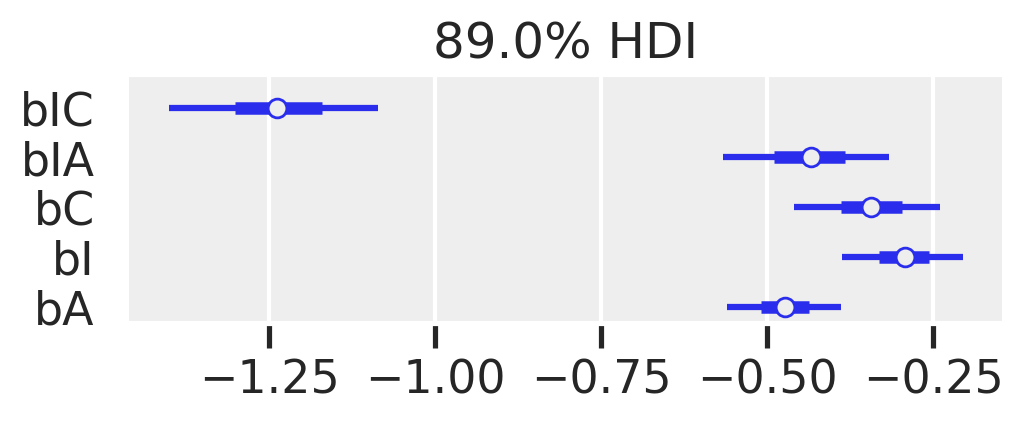

<IPython.core.display.Javascript object>

In [38]:
f, ax1 = plt.subplots(figsize=(5, 2))
az.plot_forest(
    trace_12_5, var_names=["bIC", "bIA", "bC", "bI", "bA"], combined=True, ax=ax1
)

This is showing the combination of intention and contact is the worst, despite the fact that each by themselves isn't showing a large impact on the ratings. Let's plot the posterior predictions.

### Plot posterior predictions

It will be easier to understand, but this is a challenge since each prediction is a vector of probabilities. We'll need to create a function that generates these predictions using the parameters of our posterior predictions. We can use the full posterior (analagous to the `sim` function) or something akin to the `link` function. McElreath's  R code 12.27 uses link. Let's take a quick look at the posterior.

#### My own code

In [51]:
trace_12_5_df.head()

chain  draw  (posterior, bA)  (posterior, bC)  (posterior, bI)  \
0      0     0        -0.505141        -0.318802        -0.327815   
1      0     1        -0.434830        -0.457989        -0.304971   
2      0     2        -0.450218        -0.377510        -0.326047   
3      0     3        -0.388423        -0.407774        -0.188328   
4      0     4        -0.423833        -0.255446        -0.319680   

   (posterior, bIA)  (posterior, bIC)  (posterior, cutpoints[0], 0)  \
0         -0.425470         -1.150018                     -2.660330   
1         -0.424522         -1.105279                     -2.626617   
2         -0.446714         -1.213259                     -2.624070   
3         -0.518498         -1.236109                     -2.593273   
4         -0.496148         -1.199826                     -2.593342   

   (posterior, cutpoints[1], 1)  (posterior, cutpoints[2], 2)  ...  \
0                     -1.955481                     -1.376935  ...   
1                     -1.932367                     -1.321066  ...   
2                     -1.949052                     -1.343156  ...   
3                     -1.898340                     -1.309335  ...   
4                     -1.894928                     -1.311964  ...   

   (sample_stats, perf_counter_diff)  (sample_stats, tree_size)  \
0                           0.113647                       31.0   
1                           0.029954                        7.0   
2                           0.058909                       15.0   
3                           0.056423                       15.0   
4                           0.087785                       23.0   

   (sample_stats, step_size)  (sample_stats, diverging)  \
0                   0.392687                      False   
1                   0.392687                      False   
2                   0.392687                      False   
3                   0.392687                      False   
4                   0.392687                      False   

   (sample_stats, energy)  (sample_stats, max_energy_error)  \
0            18482.352379                          1.673077   
1            18481.945491                         -0.233171   
2            18484.577023                          0.789485   
3            18485.363774                          0.889859   
4            18485.510930                          3.129888   

   (sample_stats, process_time_diff)  (sample_stats, energy_error)  \
0                           0.113287                     -0.333714   
1                           0.029841                     -0.125865   
2                           0.058776                     -0.012350   
3                           0.056351                      0.710361   
4                           0.087489                     -0.599234   

   (sample_stats, perf_counter_start)  (sample_stats, lp)  
0                         4485.006096       -18476.163278  
1                         4485.119948       -18477.479533  
2                         4485.150092       -18477.445982  
3                         4485.209205       -18481.317360  
4                         4485.265834       -18476.097258  

[5 rows x 19886 columns]

<IPython.core.display.Javascript object>

In [72]:
def link_pp(trace, post_bA, post_bC, post_bI, post_bIA, post_bIC, in_I, in_A, in_C):
    """
    Use the model definition to generate phi.
    Input: posterior parameters and values for I, A, C
    Output: Phi (no additional sigma term?)
    """

    BI = trace[post_bI] + trace[post_bIA] * in_A + trace[post_bIC] * in_C

    phi = trace[post_bA] * in_A + trace[post_bC] * in_C + BI * in_I

    return phi

<IPython.core.display.Javascript object>

In [80]:
phi_post_0 = link_pp(
    trace_12_5_df,
    ("posterior", "bA"),
    ("posterior", "bC"),
    ("posterior", "bI"),
    ("posterior", "bIA"),
    ("posterior", "bIC"),
    0,
    0,
    0,
)

<IPython.core.display.Javascript object>

In [81]:
phi_post_1 = link_pp(
    trace_12_5_df,
    ("posterior", "bA"),
    ("posterior", "bC"),
    ("posterior", "bI"),
    ("posterior", "bIA"),
    ("posterior", "bIC"),
    1,
    0,
    0,
)

<IPython.core.display.Javascript object>

In [87]:
np.array([phi_post_0, phi_post_1]).reshape(-1, 2)

array([[-0.        , -0.        ],
       [-0.        , -0.        ],
       [-0.        , -0.        ],
       ...,
       [-0.25219887, -0.20182651],
       [-0.27349092, -0.31649199],
       [-0.24608546, -0.23015046]])

<IPython.core.display.Javascript object>

We have determined phi for two different values of intent (while holding A and C to 0). What is phi referring to? it is the outcome of the linear model for which we subtract from the intercept terms. Remember that each intercept term is a cutpoint for a particular response. And a cutpoint is cumulative probability value for that response. Let's take a look at the first cutpoint that resulted from generating the posterior distribution.

In [93]:
trace_12_5_df.head()

chain  draw  (posterior, bA)  (posterior, bC)  (posterior, bI)  \
0      0     0        -0.505141        -0.318802        -0.327815   
1      0     1        -0.434830        -0.457989        -0.304971   
2      0     2        -0.450218        -0.377510        -0.326047   
3      0     3        -0.388423        -0.407774        -0.188328   
4      0     4        -0.423833        -0.255446        -0.319680   

   (posterior, bIA)  (posterior, bIC)  (posterior, cutpoints[0], 0)  \
0         -0.425470         -1.150018                     -2.660330   
1         -0.424522         -1.105279                     -2.626617   
2         -0.446714         -1.213259                     -2.624070   
3         -0.518498         -1.236109                     -2.593273   
4         -0.496148         -1.199826                     -2.593342   

   (posterior, cutpoints[1], 1)  (posterior, cutpoints[2], 2)  ...  \
0                     -1.955481                     -1.376935  ...   
1                     -1.932367                     -1.321066  ...   
2                     -1.949052                     -1.343156  ...   
3                     -1.898340                     -1.309335  ...   
4                     -1.894928                     -1.311964  ...   

   (sample_stats, perf_counter_diff)  (sample_stats, tree_size)  \
0                           0.113647                       31.0   
1                           0.029954                        7.0   
2                           0.058909                       15.0   
3                           0.056423                       15.0   
4                           0.087785                       23.0   

   (sample_stats, step_size)  (sample_stats, diverging)  \
0                   0.392687                      False   
1                   0.392687                      False   
2                   0.392687                      False   
3                   0.392687                      False   
4                   0.392687                      False   

   (sample_stats, energy)  (sample_stats, max_energy_error)  \
0            18482.352379                          1.673077   
1            18481.945491                         -0.233171   
2            18484.577023                          0.789485   
3            18485.363774                          0.889859   
4            18485.510930                          3.129888   

   (sample_stats, process_time_diff)  (sample_stats, energy_error)  \
0                           0.113287                     -0.333714   
1                           0.029841                     -0.125865   
2                           0.058776                     -0.012350   
3                           0.056351                      0.710361   
4                           0.087489                     -0.599234   

   (sample_stats, perf_counter_start)  (sample_stats, lp)  
0                         4485.006096       -18476.163278  
1                         4485.119948       -18477.479533  
2                         4485.150092       -18477.445982  
3                         4485.209205       -18481.317360  
4                         4485.265834       -18476.097258  

[5 rows x 19886 columns]

<IPython.core.display.Javascript object>

In [108]:
cutpoints_col = [("posterior", "cutpoints" + "[" + str(i) + "]", i) for i in range(6)]
cutpoints_col

[('posterior', 'cutpoints[0]', 0),
 ('posterior', 'cutpoints[1]', 1),
 ('posterior', 'cutpoints[2]', 2),
 ('posterior', 'cutpoints[3]', 3),
 ('posterior', 'cutpoints[4]', 4),
 ('posterior', 'cutpoints[5]', 5)]

<IPython.core.display.Javascript object>

In [109]:
trace_12_5_df[cutpoints_col]

(posterior, cutpoints[0], 0)  (posterior, cutpoints[1], 1)  \
0                        -2.660330                     -1.955481   
1                        -2.626617                     -1.932367   
2                        -2.624070                     -1.949052   
3                        -2.593273                     -1.898340   
4                        -2.593342                     -1.894928   
...                            ...                           ...   
3995                     -2.586395                     -1.898478   
3996                     -2.585270                     -1.890120   
3997                     -2.699694                     -1.951593   
3998                     -2.607570                     -1.954132   
3999                     -2.640350                     -1.915897   

      (posterior, cutpoints[2], 2)  (posterior, cutpoints[3], 3)  \
0                        -1.376935                     -0.331789   
1                        -1.321066                     -0.299748   
2                        -1.343156                     -0.323886   
3                        -1.309335                     -0.278608   
4                        -1.311964                     -0.283143   
...                            ...                           ...   
3995                     -1.286708                     -0.244881   
3996                     -1.317943                     -0.292120   
3997                     -1.363629                     -0.325232   
3998                     -1.364272                     -0.319308   
3999                     -1.319128                     -0.301186   

      (posterior, cutpoints[4], 4)  (posterior, cutpoints[5], 5)  
0                         0.361956                      1.288540  
1                         0.361612                      1.224730  
2                         0.361408                      1.208448  
3                         0.388578                      1.360523  
4                         0.373973                      1.282522  
...                            ...                           ...  
3995                      0.421655                      1.348120  
3996                      0.385472                      1.277518  
3997                      0.343146                      1.220257  
3998                      0.350943                      1.280512  
3999                      0.371114                      1.249298  

[4000 rows x 6 columns]

<IPython.core.display.Javascript object>

In [116]:
prior_pc["cutpoints"].mean(axis=0)

array([ 0.06385636, -0.03095438, -0.09597819, -0.05418203,  0.01350345,
       -0.07086131])

<IPython.core.display.Javascript object>

In [133]:
phi_post_0

0      -0.0
1      -0.0
2      -0.0
3      -0.0
4      -0.0
       ... 
3995   -0.0
3996   -0.0
3997   -0.0
3998   -0.0
3999   -0.0
Length: 4000, dtype: float64

<IPython.core.display.Javascript object>

In [128]:
# Compare prior and posterior cutpoint means
cutpoints_pre_post = pd.DataFrame(
    {
        "prior_cutpoints": prior_pc["cutpoints"].mean(axis=0),
        "posterior_cutpoints": np.array(trace_12_5_df[cutpoints_col].mean()),
    }
)

cutpoints_pre_post

prior_cutpoints  posterior_cutpoints
0         0.063856            -2.635954
1        -0.030954            -1.939398
2        -0.095978            -1.344338
3        -0.054182            -0.309179
4         0.013503             0.362014
5        -0.070861             1.267736

<IPython.core.display.Javascript object>

The prior cutpoints do not increase monotonically but the posterior cutpoints do. We can get back the values in terms of probabilities like this:

In [131]:
logistic(cutpoints_pre_post["prior_cutpoints"])

0    0.515959
1    0.492262
2    0.476024
3    0.486458
4    0.503376
5    0.482292
Name: prior_cutpoints, dtype: float64

<IPython.core.display.Javascript object>

You can see that the prior cutpoints were really naive and just assumed that they all got around half of the responses. This is not totally logical but there's a lot of data so it doesn't matter.

In [130]:
logistic(cutpoints_pre_post["posterior_cutpoints"])

0    0.066860
1    0.125714
2    0.206798
3    0.423315
4    0.589528
5    0.780355
Name: posterior_cutpoints, dtype: float64

<IPython.core.display.Javascript object>

The posterior shows monotonically increasing cumulative probabilities as we expect. For the code related to the cutpoints, I did not yet factor in the linear model's phi term yet. We can easily do that by subtracting that out. We can also use the full posterior.

In [134]:
trace_12_5_df[cutpoints_col]

(posterior, cutpoints[0], 0)  (posterior, cutpoints[1], 1)  \
0                        -2.660330                     -1.955481   
1                        -2.626617                     -1.932367   
2                        -2.624070                     -1.949052   
3                        -2.593273                     -1.898340   
4                        -2.593342                     -1.894928   
...                            ...                           ...   
3995                     -2.586395                     -1.898478   
3996                     -2.585270                     -1.890120   
3997                     -2.699694                     -1.951593   
3998                     -2.607570                     -1.954132   
3999                     -2.640350                     -1.915897   

      (posterior, cutpoints[2], 2)  (posterior, cutpoints[3], 3)  \
0                        -1.376935                     -0.331789   
1                        -1.321066                     -0.299748   
2                        -1.343156                     -0.323886   
3                        -1.309335                     -0.278608   
4                        -1.311964                     -0.283143   
...                            ...                           ...   
3995                     -1.286708                     -0.244881   
3996                     -1.317943                     -0.292120   
3997                     -1.363629                     -0.325232   
3998                     -1.364272                     -0.319308   
3999                     -1.319128                     -0.301186   

      (posterior, cutpoints[4], 4)  (posterior, cutpoints[5], 5)  
0                         0.361956                      1.288540  
1                         0.361612                      1.224730  
2                         0.361408                      1.208448  
3                         0.388578                      1.360523  
4                         0.373973                      1.282522  
...                            ...                           ...  
3995                      0.421655                      1.348120  
3996                      0.385472                      1.277518  
3997                      0.343146                      1.220257  
3998                      0.350943                      1.280512  
3999                      0.371114                      1.249298  

[4000 rows x 6 columns]

<IPython.core.display.Javascript object>

In [142]:
def pordlogit_a(trace, sample_ind, phi_0, phi_1):
    """
    Input: Posterior cutpoints (intercept terms) and the phi values (posterior resulting from linear model)
    Output: Two vectors, one of I=0 and one of I=1. Each vector of discrete probabilities for each sample
    of the posterior distribution.
    """
    
    pk0 = trace.loc[sample_ind, cutpoints_col] - phi_post_0.iloc[sample_ind]
    pk1 = trace.loc[sample_ind, cutpoints_col] - phi_post_1.iloc[sample_ind]
    
    # Convert to probabilities
    pk0 = [logistic(i) for i in pk0]
    pk1 = [logistic(i) for i in pk1]
    
    return pk0, pk1


<IPython.core.display.Javascript object>

In [145]:
# This is showing how the probabilities shift
pordlogit_a(trace_12_5_df, 0, phi_post_0, phi_post_1)

([0.06535514737138368,
  0.12395697771404639,
  0.2015017549891868,
  0.4178054321389652,
  0.5895139025149484,
  0.7838998829286381],
 [0.08846562011541892,
  0.16415040967935604,
  0.2593942034408662,
  0.49900656606798516,
  0.6659160607935606,
  0.8342917730001637])

<IPython.core.display.Javascript object>

**Generate plots**

### Questions

- No scaling term? link equivalent to sim and sample_posterior_predictive?
- kappa changed to alpha?

In [146]:
# posterior predictive

with m12_5:
    pp_resp = pm.sample_posterior_predictive(
        trace_12_5, var_names=["resp_obs"], random_seed=RANDOM_SEED
    )

<IPython.core.display.Javascript object>

In [147]:
pp_resp

{'resp_obs': array([[3, 3, 3, 3, 0, 0],
        [4, 6, 4, 3, 1, 4],
        [3, 5, 1, 1, 4, 5],
        ...,
        [1, 5, 3, 3, 4, 0],
        [4, 6, 3, 4, 2, 0],
        [3, 6, 6, 4, 5, 2]])}

<IPython.core.display.Javascript object>

In [ ]:
def p_ord_logit(responses: range, phi: np.ndarray, a: np.ndarray):
    """
    For the given posterior sample, computes the cumulative probabilities
    of each response in each of the counterfactual values of the predictors.

    responses: range of possible responses in the experiment
    phi: posterior phi for each counterfactual case
    a: posterior intercept for each response
    """
    p = pd.DataFrame(index=range(len(cases_df)), columns=responses)
    for case in p.index:
        p.loc[case] = logistic(a - phi[case])

In [110]:
trace_12_5_df[cutpoints_col].mean()

(posterior, cutpoints[0], 0)   -2.635954
(posterior, cutpoints[1], 1)   -1.939398
(posterior, cutpoints[2], 2)   -1.344338
(posterior, cutpoints[3], 3)   -0.309179
(posterior, cutpoints[4], 4)    0.362014
(posterior, cutpoints[5], 5)    1.267736
dtype: float64

<IPython.core.display.Javascript object>

In [111]:
trace_12_5_df[cutpoints_col].std()

(posterior, cutpoints[0], 0)    0.052183
(posterior, cutpoints[1], 1)    0.047757
(posterior, cutpoints[2], 2)    0.045295
(posterior, cutpoints[3], 3)    0.043103
(posterior, cutpoints[4], 4)    0.043428
(posterior, cutpoints[5], 5)    0.046546
dtype: float64

<IPython.core.display.Javascript object>

#### Repo code

In [39]:
# Observed cum probs (from repo, great code)
p_obs = (
    df_trolley.groupby(["action", "contact", "intention"])
    .response.value_counts(normalize=True, sort=False)
    .unstack()
    .cumsum(axis=1)
    .iloc[:, :-1]
)
p_obs.columns = range(6)
p_obs

0         1         2         3         4  \
action contact intention                                                     
0      0       0          0.050755  0.112991  0.187915  0.443505  0.596375   
               1          0.070997  0.155589  0.251259  0.514602  0.652064   
       1       0          0.092649  0.150050  0.249748  0.497482  0.677744   
               1          0.336354  0.497482  0.645519  0.791541  0.880161   
1      0       0          0.100831  0.179003  0.285876  0.535876  0.709215   
               1          0.215106  0.344411  0.482175  0.677946  0.804834   

                                 5  
action contact intention            
0      0       0          0.779456  
               1          0.820242  
       1       0          0.856999  
               1          0.942598  
1      0       0          0.863293  
               1          0.901511

<IPython.core.display.Javascript object>

Remember, these are cumulative probabilities. We wouldn't expect them to sum to 1 but they should monotonically increase. Below is just plotting the first row. The last value is not shown but will be 1.

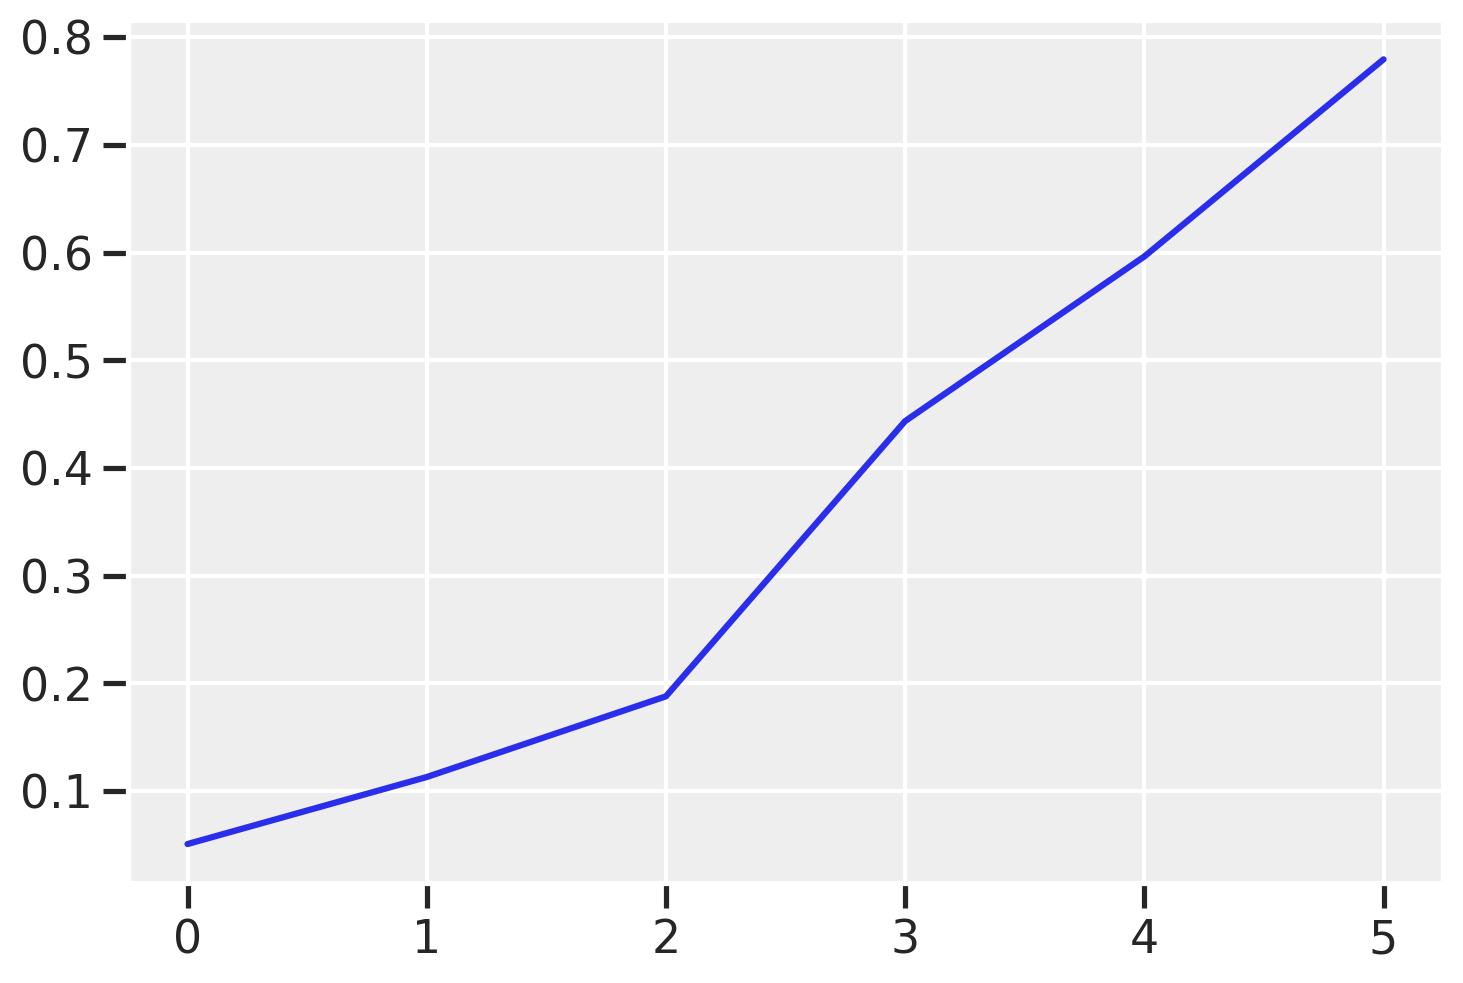

<IPython.core.display.Javascript object>

In [49]:
f, ax1 = plt.subplots()
ax1.plot(p_obs.iloc[0, :])

In [40]:
# Counterfactual cases:
cases_df = pd.DataFrame(
    np.array([[0, 0, 0], [0, 0, 1], [1, 0, 0], [1, 0, 1], [0, 1, 0], [0, 1, 1]]),
    columns=["action", "contact", "intention"],
)
cases_df

action  contact  intention
0       0        0          0
1       0        0          1
2       1        0          0
3       1        0          1
4       0        1          0
5       0        1          1

<IPython.core.display.Javascript object>

In [41]:
with m12_5:
    pm.set_data(
        {
            "A": cases_df.action.values,
            "C": cases_df.contact.values,
            "I": cases_df.intention.values,
        }
    )
    pp_phi = pm.sample_posterior_predictive(
        trace_12_5, var_names=["phi"], random_seed=RANDOM_SEED
    )["phi"]

<IPython.core.display.Javascript object>

In [52]:
pp_phi

array([[-0.        , -0.32781511, -0.50514052, -1.25842574, -0.31880184,
        -1.79663537],
       [-0.        , -0.30497069, -0.43482973, -1.16432285, -0.45798883,
        -1.86823832],
       [-0.        , -0.32604677, -0.45021825, -1.22297916, -0.37751014,
        -1.91681543],
       ...,
       [-0.        , -0.31649199, -0.51758153, -1.23487916, -0.31441999,
        -1.86091079],
       [-0.        , -0.24608546, -0.46204498, -1.16929504, -0.3795551 ,
        -1.85152211],
       [-0.        , -0.23015046, -0.46778073, -1.14086975, -0.29713445,
        -1.79953398]])

<IPython.core.display.Javascript object>

In [88]:
def p_ord_logit(responses: range, phi: np.ndarray, a: np.ndarray):
    """
    For the given posterior sample, computes the cumulative probabilities
    of each response in each of the counterfactual values of the predictors.

    responses: range of possible responses in the experiment
    phi: posterior phi for each counterfactual case
    a: posterior intercept for each response
    """
    p = pd.DataFrame(index=range(len(cases_df)), columns=responses)
    for case in p.index:
        p.loc[case] = logistic(a - phi[case])

    p = (
        pd.concat([cases_df, p], axis=1)
        .set_index(["action", "contact", "intention"])
        .sort_index()
    )
    p.index.name = "case"
    p.columns.name = "response"

    return p

<IPython.core.display.Javascript object>

In [92]:
[print(i) for i in trace_12_5_df.columns]

chain
draw
('posterior', 'bA')
('posterior', 'bC')
('posterior', 'bI')
('posterior', 'bIA')
('posterior', 'bIC')
('posterior', 'cutpoints[0]', 0)
('posterior', 'cutpoints[1]', 1)
('posterior', 'cutpoints[2]', 2)
('posterior', 'cutpoints[3]', 3)
('posterior', 'cutpoints[4]', 4)
('posterior', 'cutpoints[5]', 5)
('posterior', 'phi[0]', 0)
('posterior', 'phi[1000]', 1000)
('posterior', 'phi[1001]', 1001)
('posterior', 'phi[1002]', 1002)
('posterior', 'phi[1003]', 1003)
('posterior', 'phi[1004]', 1004)
('posterior', 'phi[1005]', 1005)
('posterior', 'phi[1006]', 1006)
('posterior', 'phi[1007]', 1007)
('posterior', 'phi[1008]', 1008)
('posterior', 'phi[1009]', 1009)
('posterior', 'phi[100]', 100)
('posterior', 'phi[1010]', 1010)
('posterior', 'phi[1011]', 1011)
('posterior', 'phi[1012]', 1012)
('posterior', 'phi[1013]', 1013)
('posterior', 'phi[1014]', 1014)
('posterior', 'phi[1015]', 1015)
('posterior', 'phi[1016]', 1016)
('posterior', 'phi[1017]', 1017)
('posterior', 'phi[1018]', 1018)
('po

('posterior', 'phi[2554]', 2554)
('posterior', 'phi[2555]', 2555)
('posterior', 'phi[2556]', 2556)
('posterior', 'phi[2557]', 2557)
('posterior', 'phi[2558]', 2558)
('posterior', 'phi[2559]', 2559)
('posterior', 'phi[255]', 255)
('posterior', 'phi[2560]', 2560)
('posterior', 'phi[2561]', 2561)
('posterior', 'phi[2562]', 2562)
('posterior', 'phi[2563]', 2563)
('posterior', 'phi[2564]', 2564)
('posterior', 'phi[2565]', 2565)
('posterior', 'phi[2566]', 2566)
('posterior', 'phi[2567]', 2567)
('posterior', 'phi[2568]', 2568)
('posterior', 'phi[2569]', 2569)
('posterior', 'phi[256]', 256)
('posterior', 'phi[2570]', 2570)
('posterior', 'phi[2571]', 2571)
('posterior', 'phi[2572]', 2572)
('posterior', 'phi[2573]', 2573)
('posterior', 'phi[2574]', 2574)
('posterior', 'phi[2575]', 2575)
('posterior', 'phi[2576]', 2576)
('posterior', 'phi[2577]', 2577)
('posterior', 'phi[2578]', 2578)
('posterior', 'phi[2579]', 2579)
('posterior', 'phi[257]', 257)
('posterior', 'phi[2580]', 2580)
('posterior', 'p

('posterior', 'phi[3904]', 3904)
('posterior', 'phi[3905]', 3905)
('posterior', 'phi[3906]', 3906)
('posterior', 'phi[3907]', 3907)
('posterior', 'phi[3908]', 3908)
('posterior', 'phi[3909]', 3909)
('posterior', 'phi[390]', 390)
('posterior', 'phi[3910]', 3910)
('posterior', 'phi[3911]', 3911)
('posterior', 'phi[3912]', 3912)
('posterior', 'phi[3913]', 3913)
('posterior', 'phi[3914]', 3914)
('posterior', 'phi[3915]', 3915)
('posterior', 'phi[3916]', 3916)
('posterior', 'phi[3917]', 3917)
('posterior', 'phi[3918]', 3918)
('posterior', 'phi[3919]', 3919)
('posterior', 'phi[391]', 391)
('posterior', 'phi[3920]', 3920)
('posterior', 'phi[3921]', 3921)
('posterior', 'phi[3922]', 3922)
('posterior', 'phi[3923]', 3923)
('posterior', 'phi[3924]', 3924)
('posterior', 'phi[3925]', 3925)
('posterior', 'phi[3926]', 3926)
('posterior', 'phi[3927]', 3927)
('posterior', 'phi[3928]', 3928)
('posterior', 'phi[3929]', 3929)
('posterior', 'phi[392]', 392)
('posterior', 'phi[3930]', 3930)
('posterior', 'p

('posterior', 'phi[5253]', 5253)
('posterior', 'phi[5254]', 5254)
('posterior', 'phi[5255]', 5255)
('posterior', 'phi[5256]', 5256)
('posterior', 'phi[5257]', 5257)
('posterior', 'phi[5258]', 5258)
('posterior', 'phi[5259]', 5259)
('posterior', 'phi[525]', 525)
('posterior', 'phi[5260]', 5260)
('posterior', 'phi[5261]', 5261)
('posterior', 'phi[5262]', 5262)
('posterior', 'phi[5263]', 5263)
('posterior', 'phi[5264]', 5264)
('posterior', 'phi[5265]', 5265)
('posterior', 'phi[5266]', 5266)
('posterior', 'phi[5267]', 5267)
('posterior', 'phi[5268]', 5268)
('posterior', 'phi[5269]', 5269)
('posterior', 'phi[526]', 526)
('posterior', 'phi[5270]', 5270)
('posterior', 'phi[5271]', 5271)
('posterior', 'phi[5272]', 5272)
('posterior', 'phi[5273]', 5273)
('posterior', 'phi[5274]', 5274)
('posterior', 'phi[5275]', 5275)
('posterior', 'phi[5276]', 5276)
('posterior', 'phi[5277]', 5277)
('posterior', 'phi[5278]', 5278)
('posterior', 'phi[5279]', 5279)
('posterior', 'phi[527]', 527)
('posterior', 'p

('posterior', 'phi[6754]', 6754)
('posterior', 'phi[6755]', 6755)
('posterior', 'phi[6756]', 6756)
('posterior', 'phi[6757]', 6757)
('posterior', 'phi[6758]', 6758)
('posterior', 'phi[6759]', 6759)
('posterior', 'phi[675]', 675)
('posterior', 'phi[6760]', 6760)
('posterior', 'phi[6761]', 6761)
('posterior', 'phi[6762]', 6762)
('posterior', 'phi[6763]', 6763)
('posterior', 'phi[6764]', 6764)
('posterior', 'phi[6765]', 6765)
('posterior', 'phi[6766]', 6766)
('posterior', 'phi[6767]', 6767)
('posterior', 'phi[6768]', 6768)
('posterior', 'phi[6769]', 6769)
('posterior', 'phi[676]', 676)
('posterior', 'phi[6770]', 6770)
('posterior', 'phi[6771]', 6771)
('posterior', 'phi[6772]', 6772)
('posterior', 'phi[6773]', 6773)
('posterior', 'phi[6774]', 6774)
('posterior', 'phi[6775]', 6775)
('posterior', 'phi[6776]', 6776)
('posterior', 'phi[6777]', 6777)
('posterior', 'phi[6778]', 6778)
('posterior', 'phi[6779]', 6779)
('posterior', 'phi[677]', 677)
('posterior', 'phi[6780]', 6780)
('posterior', 'p

('posterior', 'phi[8402]', 8402)
('posterior', 'phi[8403]', 8403)
('posterior', 'phi[8404]', 8404)
('posterior', 'phi[8405]', 8405)
('posterior', 'phi[8406]', 8406)
('posterior', 'phi[8407]', 8407)
('posterior', 'phi[8408]', 8408)
('posterior', 'phi[8409]', 8409)
('posterior', 'phi[840]', 840)
('posterior', 'phi[8410]', 8410)
('posterior', 'phi[8411]', 8411)
('posterior', 'phi[8412]', 8412)
('posterior', 'phi[8413]', 8413)
('posterior', 'phi[8414]', 8414)
('posterior', 'phi[8415]', 8415)
('posterior', 'phi[8416]', 8416)
('posterior', 'phi[8417]', 8417)
('posterior', 'phi[8418]', 8418)
('posterior', 'phi[8419]', 8419)
('posterior', 'phi[841]', 841)
('posterior', 'phi[8420]', 8420)
('posterior', 'phi[8421]', 8421)
('posterior', 'phi[8422]', 8422)
('posterior', 'phi[8423]', 8423)
('posterior', 'phi[8424]', 8424)
('posterior', 'phi[8425]', 8425)
('posterior', 'phi[8426]', 8426)
('posterior', 'phi[8427]', 8427)
('posterior', 'phi[8428]', 8428)
('posterior', 'phi[8429]', 8429)
('posterior', 

('posterior', 'phi[9753]', 9753)
('posterior', 'phi[9754]', 9754)
('posterior', 'phi[9755]', 9755)
('posterior', 'phi[9756]', 9756)
('posterior', 'phi[9757]', 9757)
('posterior', 'phi[9758]', 9758)
('posterior', 'phi[9759]', 9759)
('posterior', 'phi[975]', 975)
('posterior', 'phi[9760]', 9760)
('posterior', 'phi[9761]', 9761)
('posterior', 'phi[9762]', 9762)
('posterior', 'phi[9763]', 9763)
('posterior', 'phi[9764]', 9764)
('posterior', 'phi[9765]', 9765)
('posterior', 'phi[9766]', 9766)
('posterior', 'phi[9767]', 9767)
('posterior', 'phi[9768]', 9768)
('posterior', 'phi[9769]', 9769)
('posterior', 'phi[976]', 976)
('posterior', 'phi[9770]', 9770)
('posterior', 'phi[9771]', 9771)
('posterior', 'phi[9772]', 9772)
('posterior', 'phi[9773]', 9773)
('posterior', 'phi[9774]', 9774)
('posterior', 'phi[9775]', 9775)
('posterior', 'phi[9776]', 9776)
('posterior', 'phi[9777]', 9777)
('posterior', 'phi[9778]', 9778)
('posterior', 'phi[9779]', 9779)
('posterior', 'phi[977]', 977)
('posterior', 'p

('log_likelihood', 'resp_obs[0,2581]', 0, 2581)
('log_likelihood', 'resp_obs[0,2582]', 0, 2582)
('log_likelihood', 'resp_obs[0,2583]', 0, 2583)
('log_likelihood', 'resp_obs[0,2584]', 0, 2584)
('log_likelihood', 'resp_obs[0,2585]', 0, 2585)
('log_likelihood', 'resp_obs[0,2586]', 0, 2586)
('log_likelihood', 'resp_obs[0,2587]', 0, 2587)
('log_likelihood', 'resp_obs[0,2588]', 0, 2588)
('log_likelihood', 'resp_obs[0,2589]', 0, 2589)
('log_likelihood', 'resp_obs[0,258]', 0, 258)
('log_likelihood', 'resp_obs[0,2590]', 0, 2590)
('log_likelihood', 'resp_obs[0,2591]', 0, 2591)
('log_likelihood', 'resp_obs[0,2592]', 0, 2592)
('log_likelihood', 'resp_obs[0,2593]', 0, 2593)
('log_likelihood', 'resp_obs[0,2594]', 0, 2594)
('log_likelihood', 'resp_obs[0,2595]', 0, 2595)
('log_likelihood', 'resp_obs[0,2596]', 0, 2596)
('log_likelihood', 'resp_obs[0,2597]', 0, 2597)
('log_likelihood', 'resp_obs[0,2598]', 0, 2598)
('log_likelihood', 'resp_obs[0,2599]', 0, 2599)
('log_likelihood', 'resp_obs[0,259]', 0, 2

('log_likelihood', 'resp_obs[0,3928]', 0, 3928)
('log_likelihood', 'resp_obs[0,3929]', 0, 3929)
('log_likelihood', 'resp_obs[0,392]', 0, 392)
('log_likelihood', 'resp_obs[0,3930]', 0, 3930)
('log_likelihood', 'resp_obs[0,3931]', 0, 3931)
('log_likelihood', 'resp_obs[0,3932]', 0, 3932)
('log_likelihood', 'resp_obs[0,3933]', 0, 3933)
('log_likelihood', 'resp_obs[0,3934]', 0, 3934)
('log_likelihood', 'resp_obs[0,3935]', 0, 3935)
('log_likelihood', 'resp_obs[0,3936]', 0, 3936)
('log_likelihood', 'resp_obs[0,3937]', 0, 3937)
('log_likelihood', 'resp_obs[0,3938]', 0, 3938)
('log_likelihood', 'resp_obs[0,3939]', 0, 3939)
('log_likelihood', 'resp_obs[0,393]', 0, 393)
('log_likelihood', 'resp_obs[0,3940]', 0, 3940)
('log_likelihood', 'resp_obs[0,3941]', 0, 3941)
('log_likelihood', 'resp_obs[0,3942]', 0, 3942)
('log_likelihood', 'resp_obs[0,3943]', 0, 3943)
('log_likelihood', 'resp_obs[0,3944]', 0, 3944)
('log_likelihood', 'resp_obs[0,3945]', 0, 3945)
('log_likelihood', 'resp_obs[0,3946]', 0, 39

('log_likelihood', 'resp_obs[0,5313]', 0, 5313)
('log_likelihood', 'resp_obs[0,5314]', 0, 5314)
('log_likelihood', 'resp_obs[0,5315]', 0, 5315)
('log_likelihood', 'resp_obs[0,5316]', 0, 5316)
('log_likelihood', 'resp_obs[0,5317]', 0, 5317)
('log_likelihood', 'resp_obs[0,5318]', 0, 5318)
('log_likelihood', 'resp_obs[0,5319]', 0, 5319)
('log_likelihood', 'resp_obs[0,531]', 0, 531)
('log_likelihood', 'resp_obs[0,5320]', 0, 5320)
('log_likelihood', 'resp_obs[0,5321]', 0, 5321)
('log_likelihood', 'resp_obs[0,5322]', 0, 5322)
('log_likelihood', 'resp_obs[0,5323]', 0, 5323)
('log_likelihood', 'resp_obs[0,5324]', 0, 5324)
('log_likelihood', 'resp_obs[0,5325]', 0, 5325)
('log_likelihood', 'resp_obs[0,5326]', 0, 5326)
('log_likelihood', 'resp_obs[0,5327]', 0, 5327)
('log_likelihood', 'resp_obs[0,5328]', 0, 5328)
('log_likelihood', 'resp_obs[0,5329]', 0, 5329)
('log_likelihood', 'resp_obs[0,532]', 0, 532)
('log_likelihood', 'resp_obs[0,5330]', 0, 5330)
('log_likelihood', 'resp_obs[0,5331]', 0, 53

('log_likelihood', 'resp_obs[0,6805]', 0, 6805)
('log_likelihood', 'resp_obs[0,6806]', 0, 6806)
('log_likelihood', 'resp_obs[0,6807]', 0, 6807)
('log_likelihood', 'resp_obs[0,6808]', 0, 6808)
('log_likelihood', 'resp_obs[0,6809]', 0, 6809)
('log_likelihood', 'resp_obs[0,680]', 0, 680)
('log_likelihood', 'resp_obs[0,6810]', 0, 6810)
('log_likelihood', 'resp_obs[0,6811]', 0, 6811)
('log_likelihood', 'resp_obs[0,6812]', 0, 6812)
('log_likelihood', 'resp_obs[0,6813]', 0, 6813)
('log_likelihood', 'resp_obs[0,6814]', 0, 6814)
('log_likelihood', 'resp_obs[0,6815]', 0, 6815)
('log_likelihood', 'resp_obs[0,6816]', 0, 6816)
('log_likelihood', 'resp_obs[0,6817]', 0, 6817)
('log_likelihood', 'resp_obs[0,6818]', 0, 6818)
('log_likelihood', 'resp_obs[0,6819]', 0, 6819)
('log_likelihood', 'resp_obs[0,681]', 0, 681)
('log_likelihood', 'resp_obs[0,6820]', 0, 6820)
('log_likelihood', 'resp_obs[0,6821]', 0, 6821)
('log_likelihood', 'resp_obs[0,6822]', 0, 6822)
('log_likelihood', 'resp_obs[0,6823]', 0, 68

('log_likelihood', 'resp_obs[0,8359]', 0, 8359)
('log_likelihood', 'resp_obs[0,835]', 0, 835)
('log_likelihood', 'resp_obs[0,8360]', 0, 8360)
('log_likelihood', 'resp_obs[0,8361]', 0, 8361)
('log_likelihood', 'resp_obs[0,8362]', 0, 8362)
('log_likelihood', 'resp_obs[0,8363]', 0, 8363)
('log_likelihood', 'resp_obs[0,8364]', 0, 8364)
('log_likelihood', 'resp_obs[0,8365]', 0, 8365)
('log_likelihood', 'resp_obs[0,8366]', 0, 8366)
('log_likelihood', 'resp_obs[0,8367]', 0, 8367)
('log_likelihood', 'resp_obs[0,8368]', 0, 8368)
('log_likelihood', 'resp_obs[0,8369]', 0, 8369)
('log_likelihood', 'resp_obs[0,836]', 0, 836)
('log_likelihood', 'resp_obs[0,8370]', 0, 8370)
('log_likelihood', 'resp_obs[0,8371]', 0, 8371)
('log_likelihood', 'resp_obs[0,8372]', 0, 8372)
('log_likelihood', 'resp_obs[0,8373]', 0, 8373)
('log_likelihood', 'resp_obs[0,8374]', 0, 8374)
('log_likelihood', 'resp_obs[0,8375]', 0, 8375)
('log_likelihood', 'resp_obs[0,8376]', 0, 8376)
('log_likelihood', 'resp_obs[0,8377]', 0, 83

('log_likelihood', 'resp_obs[0,9813]', 0, 9813)
('log_likelihood', 'resp_obs[0,9814]', 0, 9814)
('log_likelihood', 'resp_obs[0,9815]', 0, 9815)
('log_likelihood', 'resp_obs[0,9816]', 0, 9816)
('log_likelihood', 'resp_obs[0,9817]', 0, 9817)
('log_likelihood', 'resp_obs[0,9818]', 0, 9818)
('log_likelihood', 'resp_obs[0,9819]', 0, 9819)
('log_likelihood', 'resp_obs[0,981]', 0, 981)
('log_likelihood', 'resp_obs[0,9820]', 0, 9820)
('log_likelihood', 'resp_obs[0,9821]', 0, 9821)
('log_likelihood', 'resp_obs[0,9822]', 0, 9822)
('log_likelihood', 'resp_obs[0,9823]', 0, 9823)
('log_likelihood', 'resp_obs[0,9824]', 0, 9824)
('log_likelihood', 'resp_obs[0,9825]', 0, 9825)
('log_likelihood', 'resp_obs[0,9826]', 0, 9826)
('log_likelihood', 'resp_obs[0,9827]', 0, 9827)
('log_likelihood', 'resp_obs[0,9828]', 0, 9828)
('log_likelihood', 'resp_obs[0,9829]', 0, 9829)
('log_likelihood', 'resp_obs[0,982]', 0, 982)
('log_likelihood', 'resp_obs[0,9830]', 0, 9830)
('log_likelihood', 'resp_obs[0,9831]', 0, 98

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

<IPython.core.display.Javascript object>

KeyError: 'cutpoints'

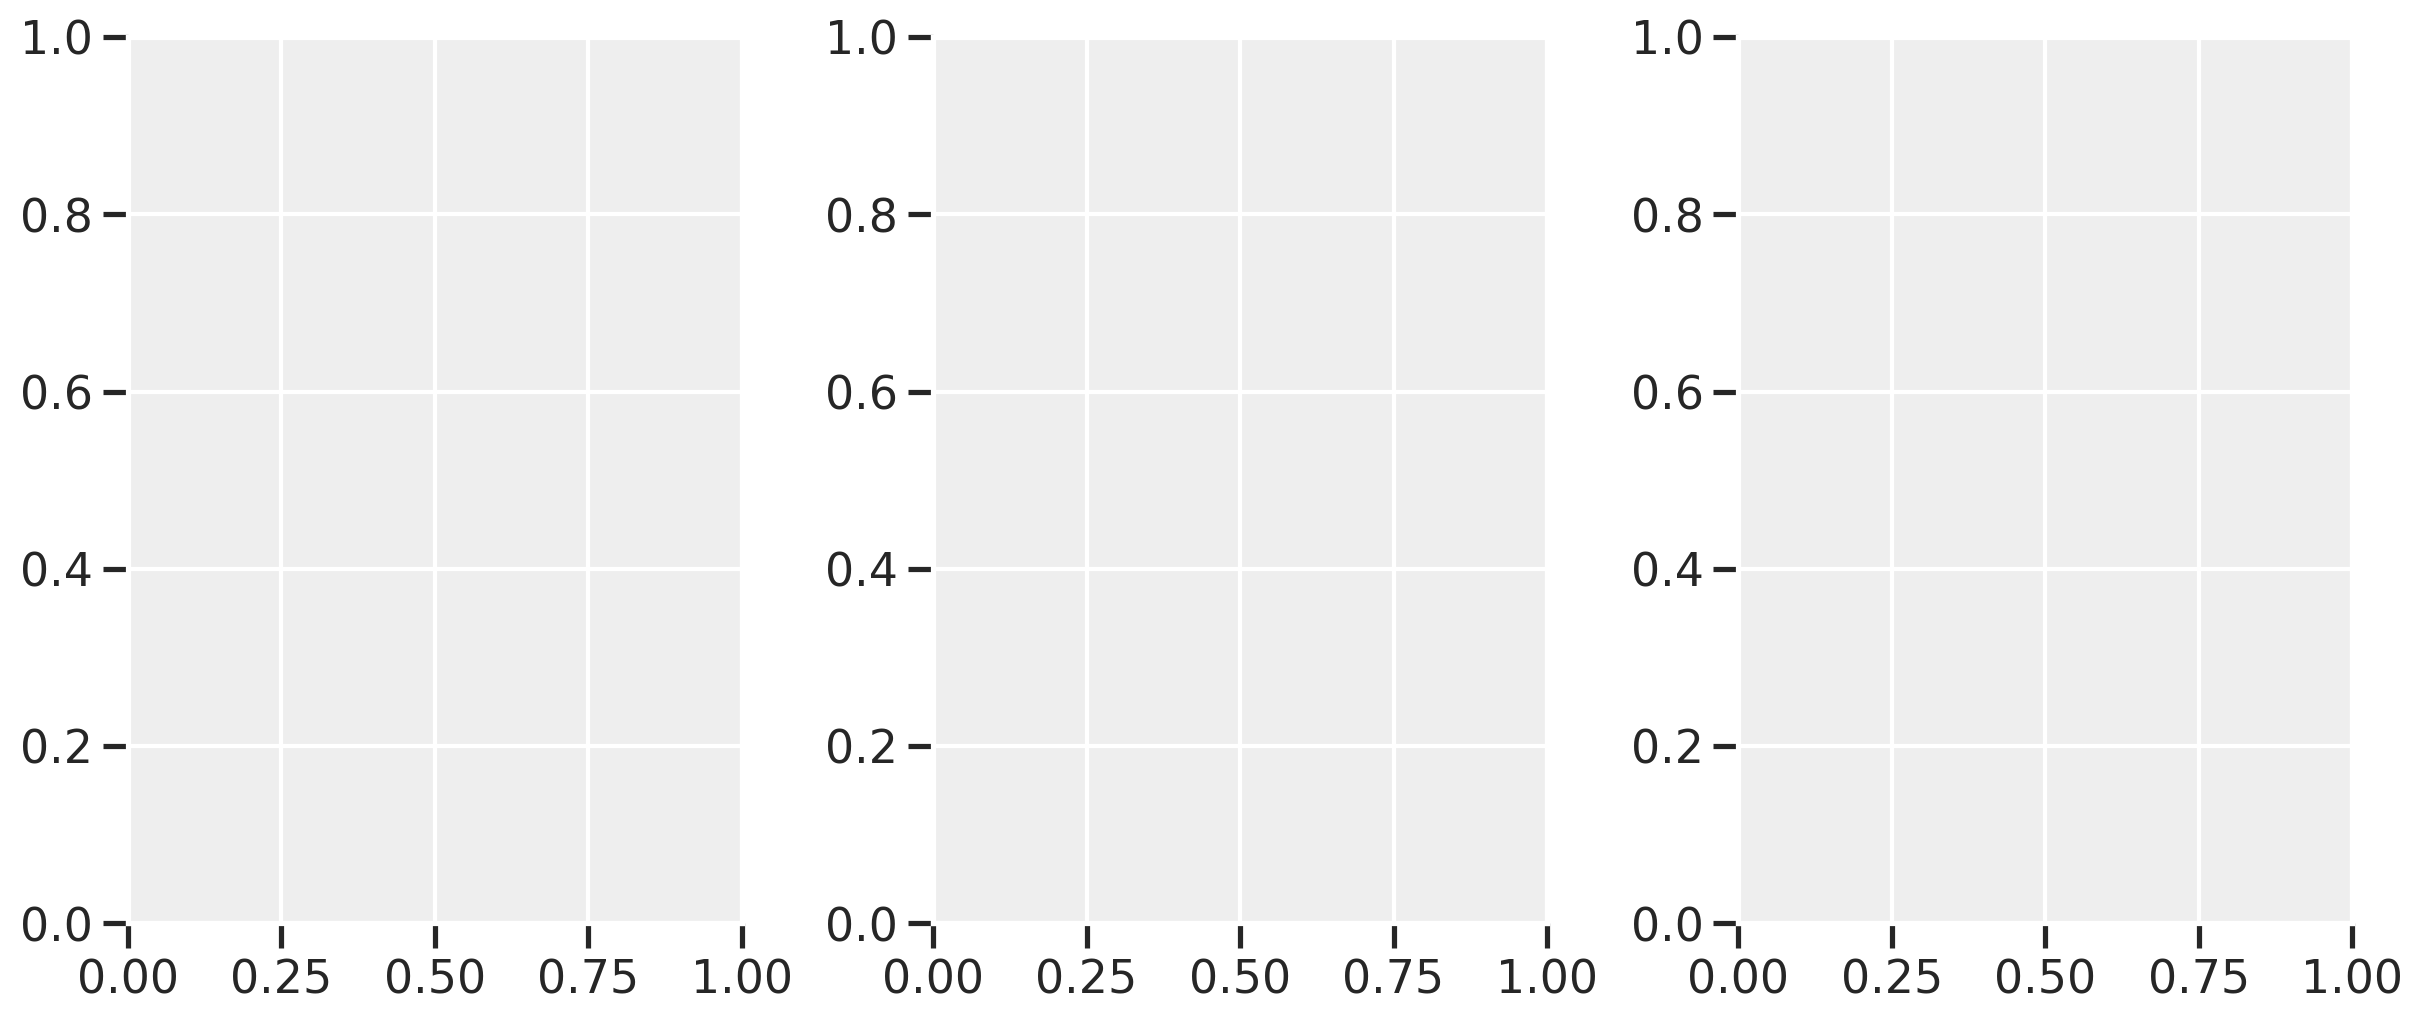

<IPython.core.display.Javascript object>

In [89]:
_, axes = plt.subplots(1, 3, figsize=(12, 5))

for s in range(50):
    p = p_ord_logit(responses=range(6), phi=pp_phi[s], a=trace_12_5["cutpoints"][s])

    cur_ax = 0
    for (action, contact), _ in p.groupby(level=["action", "contact"]):
        axes[cur_ax].plot([0, 1], p.loc[action, contact], lw=0.6, c="k", alpha=0.1)

        if s == 0:
            axes[cur_ax].plot([0, 1], p_obs.loc[action, contact], "ob", alpha=0.4)
            axes[cur_ax].set_xticks([0, 1])
            axes[cur_ax].set_xlabel("intention")
            axes[cur_ax].set_ylabel("probablity")
            axes[cur_ax].set_ylim([0, 1])
            axes[cur_ax].set_title(f"action={action}, contact={contact}")

        cur_ax += 1
plt.tight_layout()

# Question 2 (11H8)

Consider one more variable in the Trolley data: Gender. Suppose that gender might influence education as well as response directly. Draw the DAG now that includes response, education, age, and gender.

Using only the DAG, is it possible that the inferences from Problem 1 are confounded by gender? If so, define any additional models you need to infer the causal influence of education on response. What do you conclude?

## New DAG

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


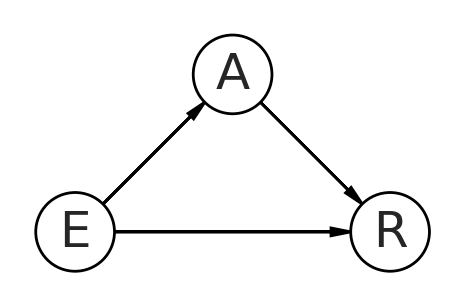

<IPython.core.display.Javascript object>

In [31]:
pipe_dag = CausalGraphicalModel(
    nodes=["E", "A", "R"],
    edges=[
        ("E", "A"),
        ("A", "R"),
        ("E", "R"),
    ],
)
pgm = daft.PGM()

coordinates = {
    "E": (0, 0),
    "A": (1, 1),
    "R": (2, 0),
}
for node in pipe_dag.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in pipe_dag.dag.edges:
    pgm.add_edge(*edge)
pgm.render()


/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


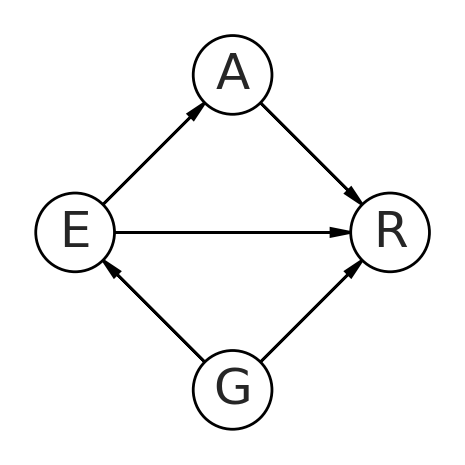

<IPython.core.display.Javascript object>

In [32]:
pipe_dag = CausalGraphicalModel(
    nodes=["E", "G", "A", "R"],
    edges=[
        ("E", "A"),
        ("A", "R"),
        ("E", "R"),
        ("G", "R"),
        ("G", "E"),
    ],
)
pgm = daft.PGM()

coordinates = {
    "E": (0, 0),
    "A": (1, 1),
    "R": (2, 0),
    "G": (1, -1),
}
for node in pipe_dag.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in pipe_dag.dag.edges:
    pgm.add_edge(*edge)
pgm.render()


**Update**

In terms of the paths of G to A, we now have the following:

- G > A (direct)
- G > D > A (D acts as a pipe)
- G > D < US > A (D acts as a collider)

Therefore, we're "hurt" by the fact that we can't answer our question with satisfaction since there are problems whether we condition on D or not.

McElreath's suggestion: "What can be done in these situations? The best thing is to stop analyzing convenient,
confounded data and instead design a real study."

In [37]:
np.array([[1, 2], [3, 4]])**2

array([[ 1,  4],
       [ 9, 16]])

<IPython.core.display.Javascript object>

Appendix: Environment and system parameters

In [33]:
%watermark -n -u -v -iv -w

Last updated: Fri Jul 02 2021

Python implementation: CPython
Python version       : 3.8.6
IPython version      : 7.20.0

pandas    : 1.2.1
matplotlib: 3.3.4
arviz     : 0.11.1
pymc3     : 3.11.0
daft      : 0.1.0
json      : 2.0.9
numpy     : 1.20.1
seaborn   : 0.11.1
scipy     : 1.6.0

Watermark: 2.1.0



<IPython.core.display.Javascript object>